# A Clustering Approach to Evaluate Exercise Needs in Women with Breast Cancer

In [52]:
# Import global dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date, timedelta
from math import floor, isnan

# Plot condiguration
plot_scale_factor = 3/4 
plt.rcParams['figure.figsize'] = (16*plot_scale_factor,9*plot_scale_factor)
sns.set_theme(style="whitegrid")

# Fix seed
np.random.seed(42)

## Load data
Load clean records of ATOPE+ measures and Fitbit's physical activity and sleep from `records-clean.csv`. Demographics data are loaded from `demographics-clean.csv`.

In [53]:
# Load data
daily_records = pd.read_csv('./data/atope+breast/records-clean.csv')
demographics = pd.read_csv('./data/atope+breast/demographics-clean.csv')

## Data analysis

### Description of data
#### Measure count
This section describes the data collected. The available data depends on the data sources used and combined together. Availability is also shown for every patient individually.

In [54]:
# Conditions for data filtering based on variables from ATOPE+ and Fitbit  sources
condition_hrv = daily_records['cv_lnrmssd'].notna()
condition_steps = daily_records['steps_total_yesterday'].notna()
condition_sleep = daily_records['sleep_total'].notna()

print('Data with complete ATOPE+ measures: ' + str(condition_hrv.sum()))
print('Data with complete ATOPE+ measures and Fitbit steps: ' + str((condition_hrv & condition_steps).sum()))
print('Data with complete ATOPE+ measures and Fitbit steps and sleep: ' + str((condition_hrv & condition_steps & condition_sleep).sum()))

Data with complete ATOPE+ measures: 681
Data with complete ATOPE+ measures and Fitbit steps: 488
Data with complete ATOPE+ measures and Fitbit steps and sleep: 328


In [55]:
# Count measures
count_hrv = daily_records.loc[condition_hrv, ['username', 'cv_lnrmssd']].groupby('username').count()
count_hrv_steps = daily_records.loc[(condition_hrv & condition_steps), ['username', 'cv_lnrmssd']].groupby('username').count()
count_hrv_steps_sleep = daily_records.loc[(condition_hrv & condition_steps & condition_sleep), ['username', 'cv_lnrmssd']].groupby('username').count()

# Change column names
count_hrv = count_hrv.rename({'cv_lnrmssd':'HRV'}, axis=1)
count_hrv_steps = count_hrv_steps.rename({'cv_lnrmssd':'HRV+steps'}, axis=1)
count_hrv_steps_sleep = count_hrv_steps_sleep.rename({'cv_lnrmssd':'HRV+steps+sleep'}, axis=1)
# Merge and show
pd.concat([count_hrv, count_hrv_steps, count_hrv_steps_sleep], axis=1)

HRV  HRV+steps  HRV+steps+sleep
AT101   36       34.0             27.0
AT102   70        NaN              NaN
AT103    6        5.0              4.0
AT59    40       28.0             22.0
AT62    17       17.0             17.0
AT63     1        1.0              NaN
AT65    50       33.0             17.0
AT66    25       12.0             12.0
AT68   106       93.0             17.0
AT73    33       33.0             32.0
AT75    44       41.0             37.0
AT76    49       47.0             38.0
AT77    10        2.0              2.0
AT82    14        5.0              4.0
AT85    22       22.0             22.0
AT86    55       36.0             32.0
AT88    32       32.0             26.0
AT89    11        9.0              8.0
AT93     7        7.0              7.0
AT94    11        5.0              3.0
AT95    36       26.0              1.0
AT99     6        NaN              NaN

#### Training sessions
Description of training sessions. First are the preparatory sessions, that is, those given in the first week or two to start preparing the patient. Next are the adjusted training sessions, in which the exercise dose is adjusted according to ATOPE+ data.

In [56]:
# Fix s3 input
daily_records['session_type'] = daily_records['session_type'].replace('s3', 'S3')

# Get preparatory and session indexes
training_session = daily_records['session_type'].str.match('adjusted_training')
preparatory_session = daily_records['session_type'].str.match('preparatory_training')

# Fix indexes
training_session = training_session.replace(np.nan, False)
preparatory_session = preparatory_session.replace(np.nan, False)

# Print output
print('Preparatory sessions: ' + str(sum(preparatory_session.dropna())))
print('Preparatory sessions with valid HRV measure: '+str(sum(preparatory_session & condition_hrv)))
print('Training sessions: ' + str(sum(training_session.dropna())))
print('Training sessions with valid HRV measure: '+str(sum(training_session & condition_hrv)))

Preparatory sessions: 110
Preparatory sessions with valid HRV measure: 56
Training sessions: 196
Training sessions with valid HRV measure: 148


In [57]:
# Preparatory sessions
daily_records.loc[preparatory_session, ['username', 'training_borg']].groupby('username').describe()

training_borg                                                  
                 count      mean       std  min    25%   50%    75%  max
username                                                                
AT102              5.0  5.800000  0.447214  5.0  6.000  6.00  6.000  6.0
AT103              6.0  5.166667  0.408248  5.0  5.000  5.00  5.000  6.0
AT59               8.0  6.000000  0.925820  4.0  6.000  6.00  6.250  7.0
AT62               6.0  6.333333  0.816497  6.0  6.000  6.00  6.000  8.0
AT63               6.0  6.416667  1.020621  5.0  6.000  6.25  6.875  8.0
AT65               6.0  5.916667  0.204124  5.5  6.000  6.00  6.000  6.0
AT66               6.0  6.333333  0.516398  6.0  6.000  6.00  6.750  7.0
AT68               8.0  6.000000  0.000000  6.0  6.000  6.00  6.000  6.0
AT73               3.0  6.000000  0.000000  6.0  6.000  6.00  6.000  6.0
AT75               6.0  6.333333  0.408248  6.0  6.000  6.25  6.500  7.0
AT76               6.0  5.583333  0.376386  5.0  5.500  5.50  5.875  6.0
AT77               6.0  5.000000  0.000000  5.0  5.000  5.00  5.000  5.0
AT82               3.0  6.000000  0.000000  6.0  6.000  6.00  6.000  6.0
AT85               3.0  6.000000  0.000000  6.0  6.000  6.00  6.000  6.0
AT86               3.0  6.000000  0.000000  6.0  6.000  6.00  6.000  6.0
AT88               6.0  6.166667  0.683130  5.0  6.000  6.25  6.500  7.0
AT89               6.0  6.833333  0.683130  6.0  6.500  6.75  7.000  8.0
AT91               2.0  6.000000  0.000000  6.0  6.000  6.00  6.000  6.0
AT93               6.0  6.500000  0.447214  6.0  6.125  6.50  6.875  7.0
AT94               5.0  5.400000  0.547723  5.0  5.000  5.00  6.000  6.0
AT95               4.0  6.125000  0.750000  5.0  6.125  6.50  6.500  6.5

In [58]:
# Adjusted sessions
daily_records.loc[training_session, ['username', 'training_borg']].groupby('username').describe()

training_borg                                                  
                 count      mean       std  min    25%   50%    75%  max
username                                                                
AT101             13.0  6.461538  0.967418  5.0  6.000  6.00  7.000  8.0
AT102             18.0  6.722222  1.251143  3.0  6.500  7.00  7.000  9.0
AT103              4.0  7.125000  1.030776  6.0  6.375  7.25  8.000  8.0
AT59              15.0  7.100000  1.183216  5.0  6.250  7.00  8.000  9.0
AT62               2.0  7.500000  0.707107  7.0  7.250  7.50  7.750  8.0
AT65               6.0  6.916667  0.861201  5.5  6.625  7.00  7.375  8.0
AT66              17.0  6.911765  0.870260  5.0  6.500  7.00  8.000  8.0
AT68              13.0  7.307692  1.128023  6.0  6.500  7.00  8.500  9.0
AT73              17.0  6.705882  0.587868  6.0  6.000  7.00  7.000  8.0
AT75              17.0  7.352941  0.996317  6.0  6.500  7.00  8.500  9.0
AT76              15.0  6.366667  0.441858  5.0  6.500  6.50  6.500  7.0
AT82               8.0  7.125000  0.876275  5.5  7.000  7.00  7.250  8.5
AT85              15.0  7.033333  1.575104  5.0  5.500  7.00  8.500  9.5
AT86               2.0  6.500000  0.707107  6.0  6.250  6.50  6.750  7.0
AT88              13.0  6.461538  1.050031  5.0  6.000  6.50  7.000  8.0
AT93               4.0  6.500000  1.224745  5.0  6.125  6.50  6.875  8.0
AT95              17.0  7.000000  1.369306  5.0  6.000  7.00  7.000  9.5

Number of LOW training sessions with valid HRV measure: 0
Number of MEDIUM training sessions with valid HRV measure: 162
Number of HIGH training sessions with valid HRV measure: 42


<AxesSubplot:>

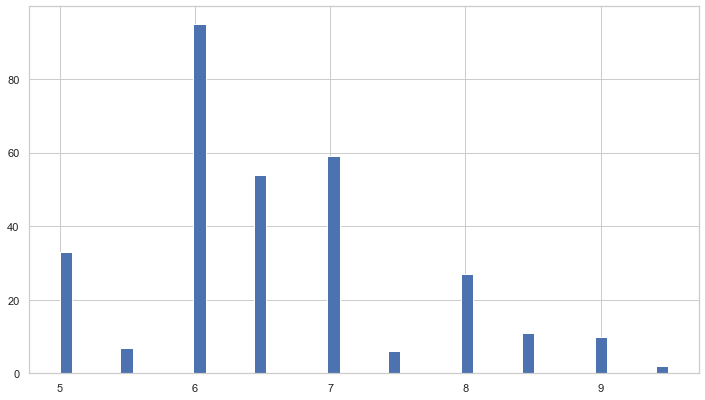

In [59]:
# Thresholds selected according to histogram
training_thresholds = [1,5,7.5]  # [) intervals (cerrado izquierda, abierto derecha)
is_training_low = (daily_records['training_borg'] >= training_thresholds[0]) & (daily_records['training_borg'] < training_thresholds[1])
is_training_medium = (daily_records['training_borg'] >= training_thresholds[1]) & (daily_records['training_borg'] < training_thresholds[2])
is_training_high = (daily_records['training_borg'] >= training_thresholds[2]) & (daily_records['training_borg'] <= 10)
print('Number of LOW training sessions with valid HRV measure: '+str(sum(is_training_low & condition_hrv)))
print('Number of MEDIUM training sessions with valid HRV measure: '+str(sum(is_training_medium & condition_hrv)))
print('Number of HIGH training sessions with valid HRV measure: '+str(sum(is_training_high & condition_hrv)))

daily_records.loc[(is_training_medium | is_training_high), 'training_borg'].hist(bins=50)

#### Individual Visualizations
##### Longitudinal

/home/dollo/Workspace/atope-breast-clustering-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


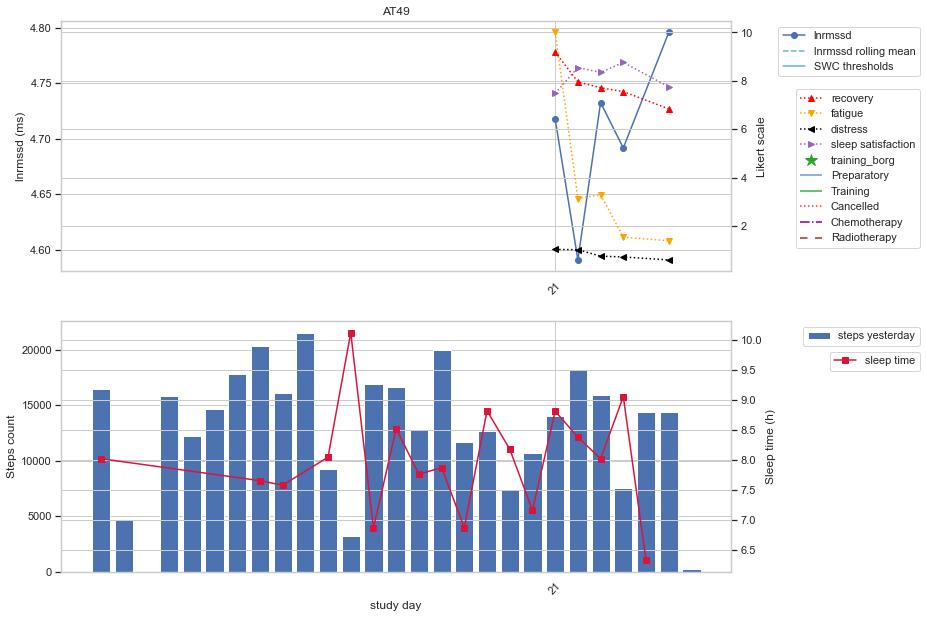

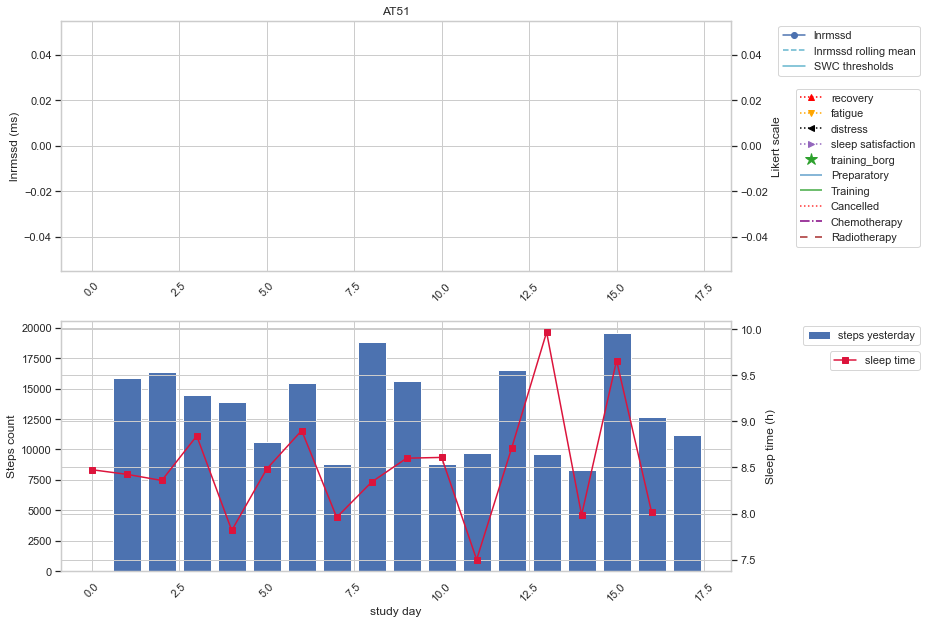

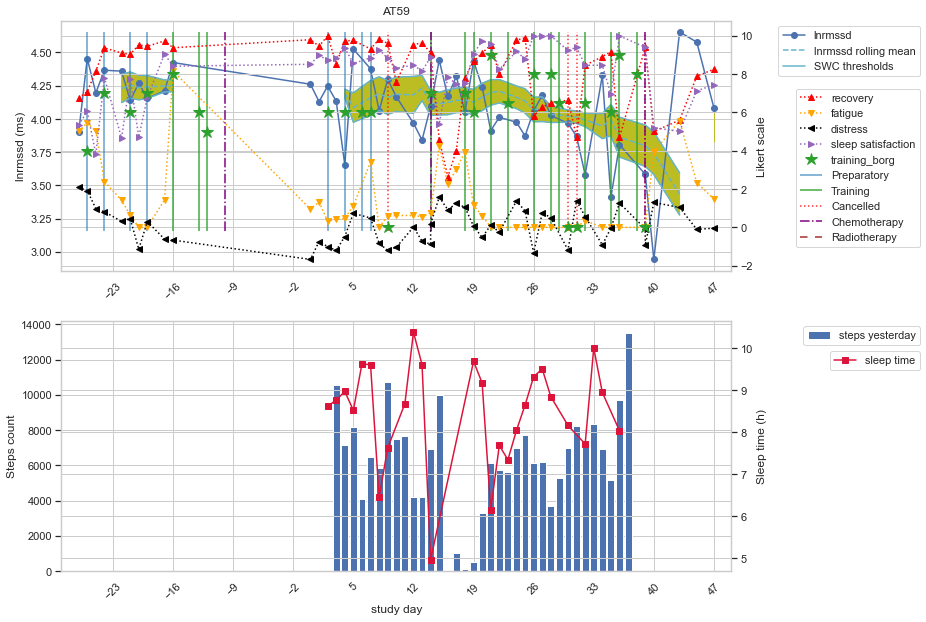

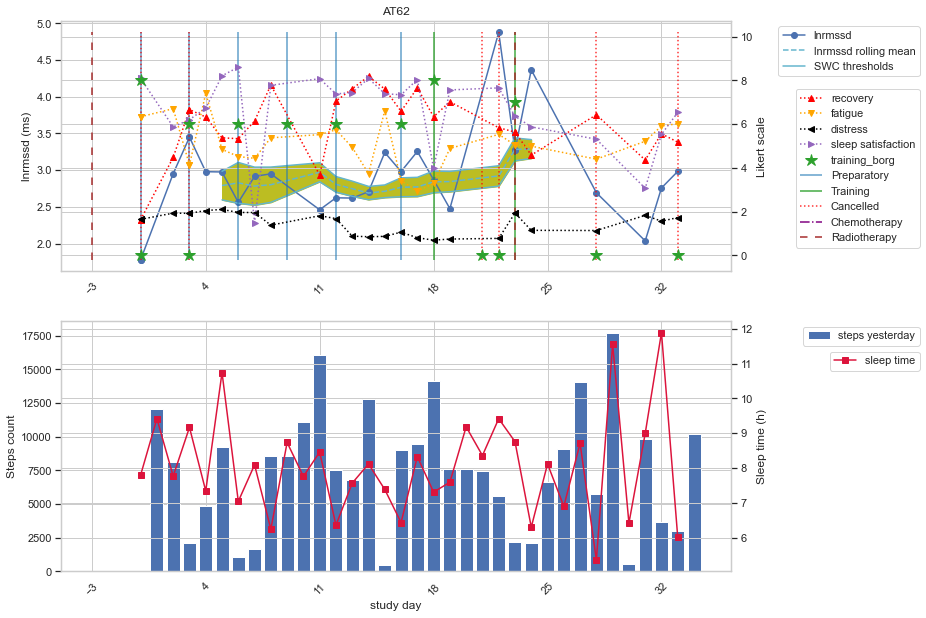

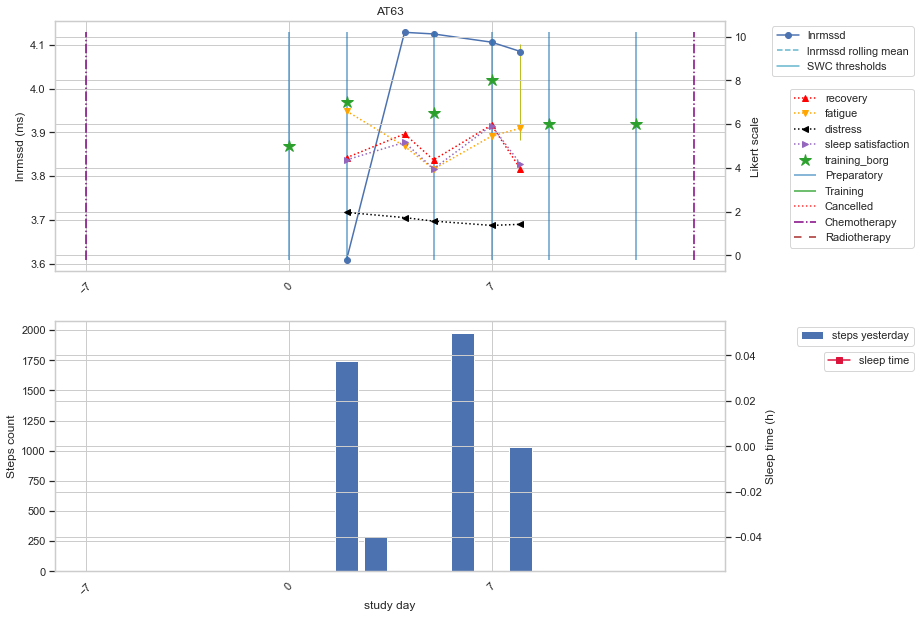

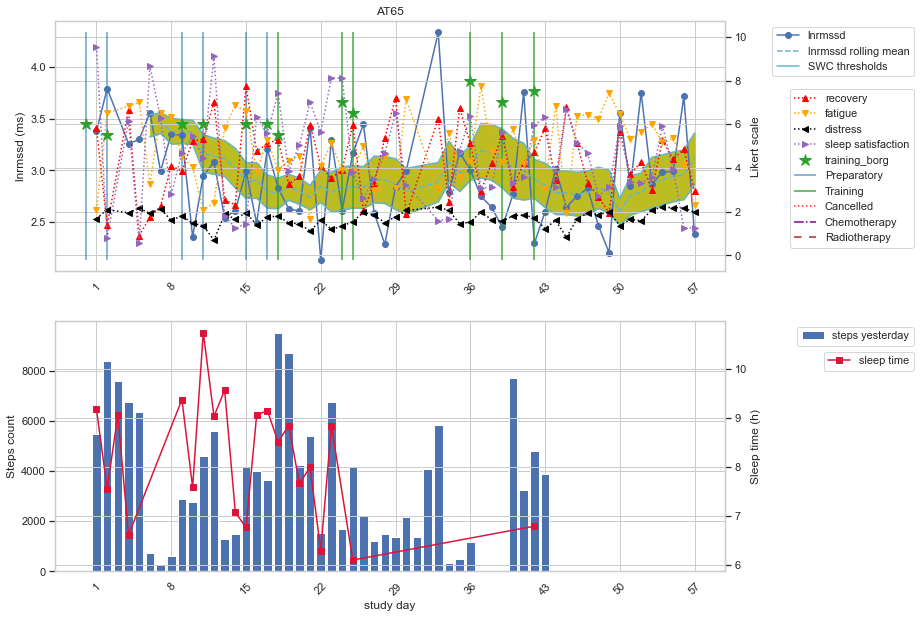

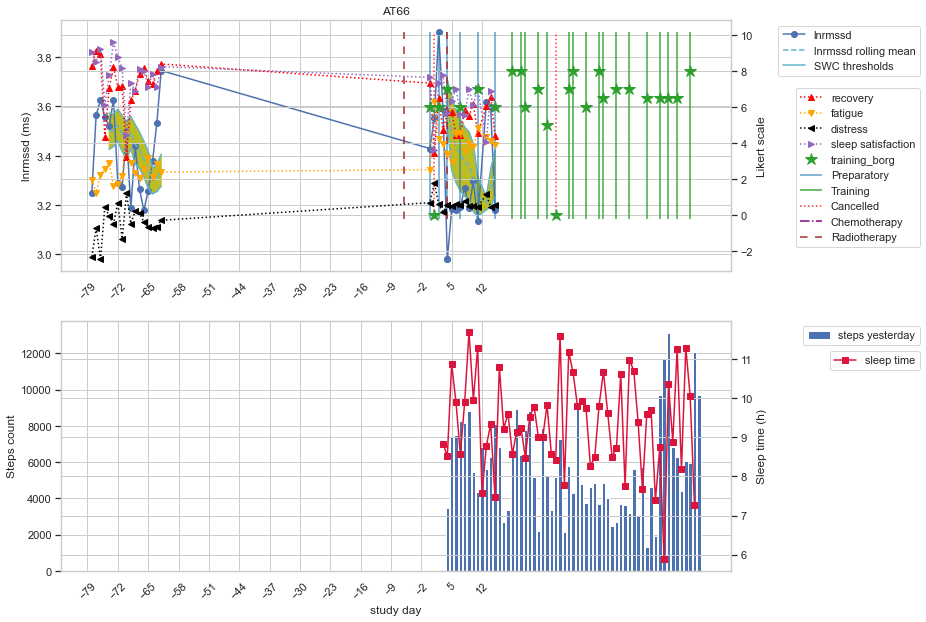

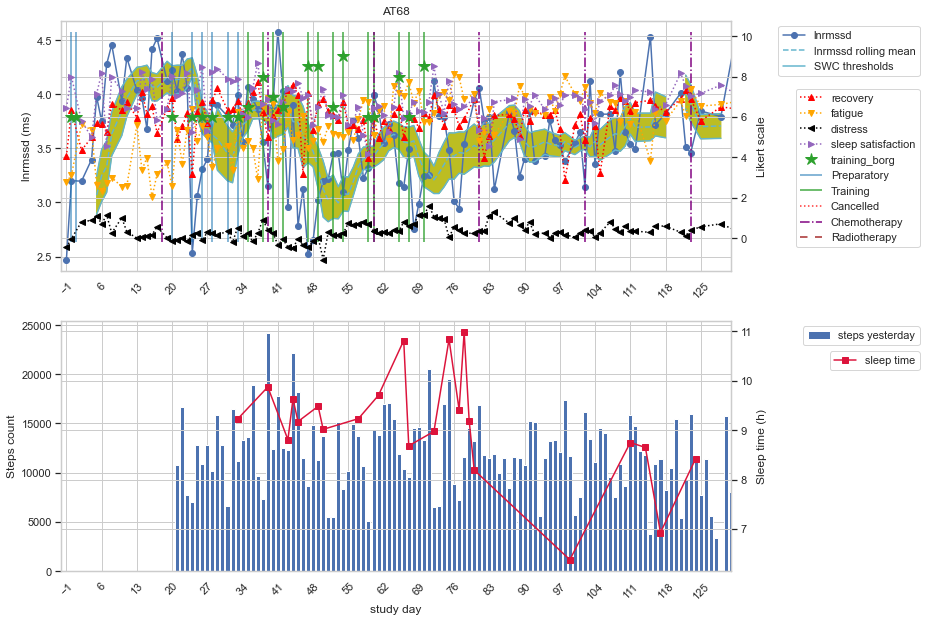

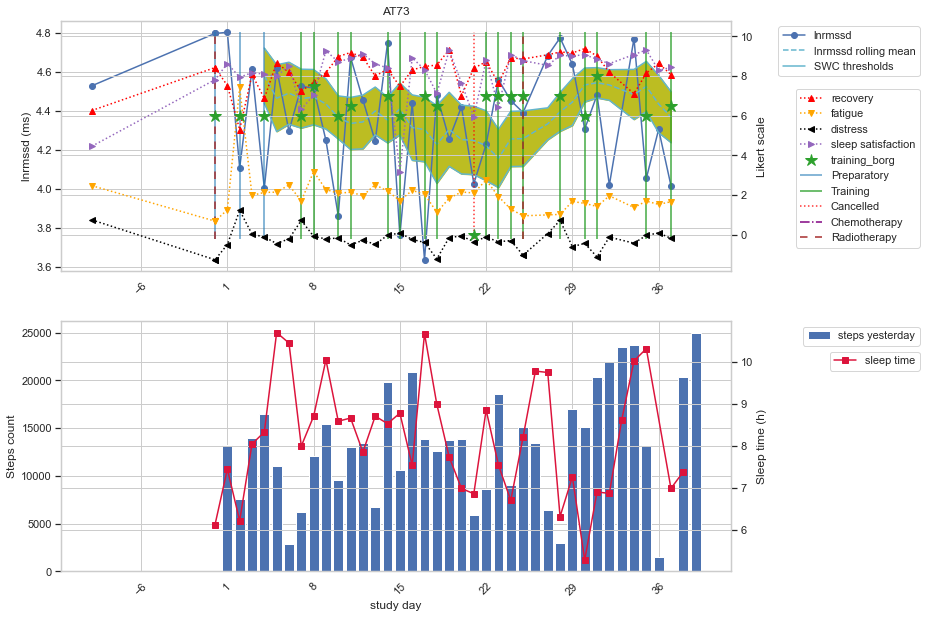

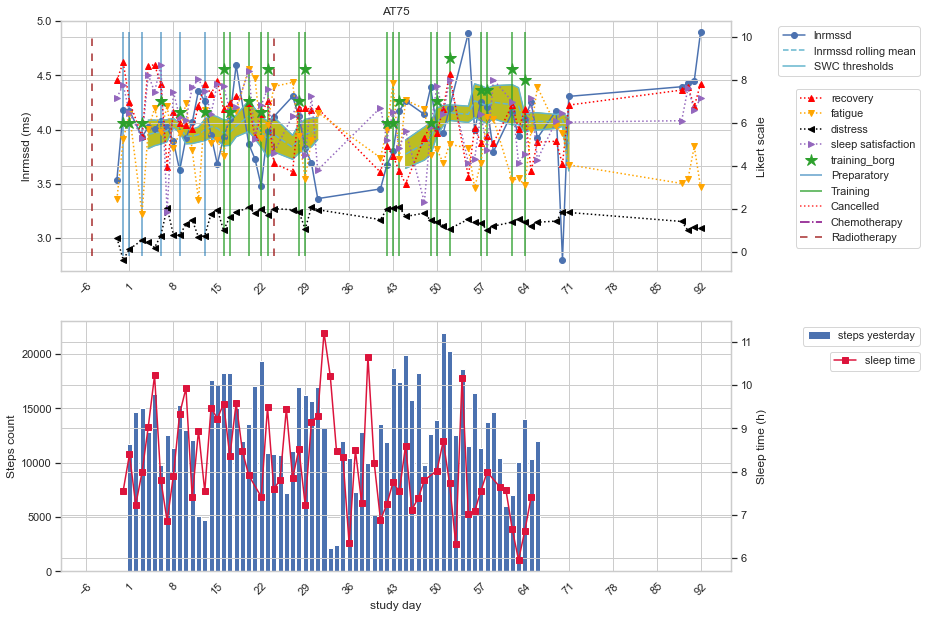

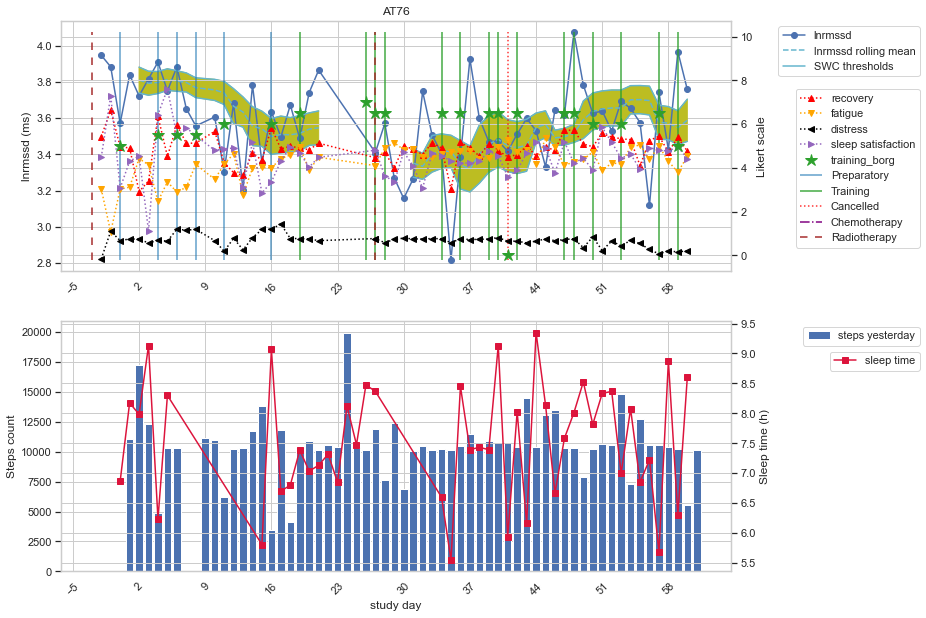

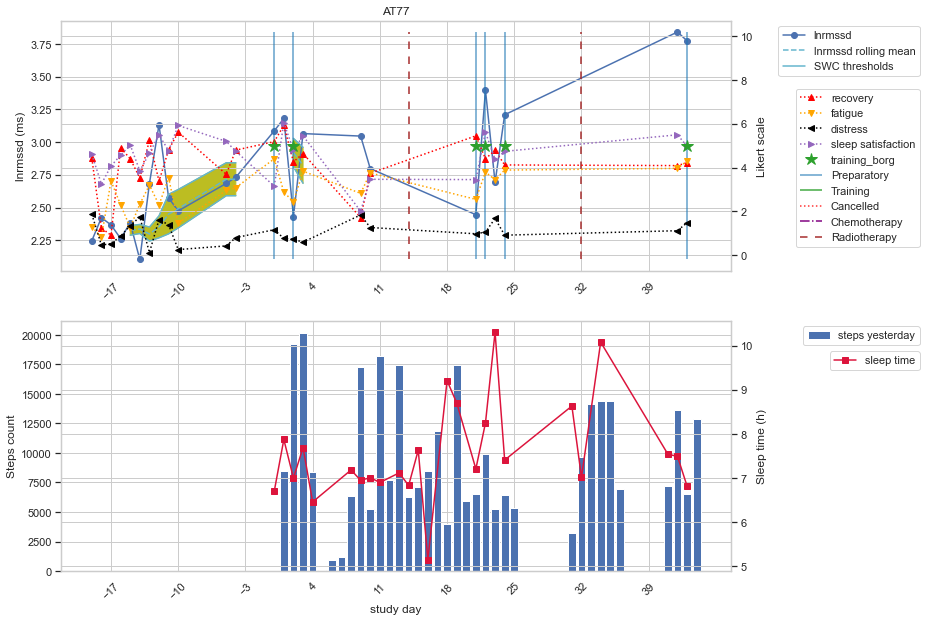

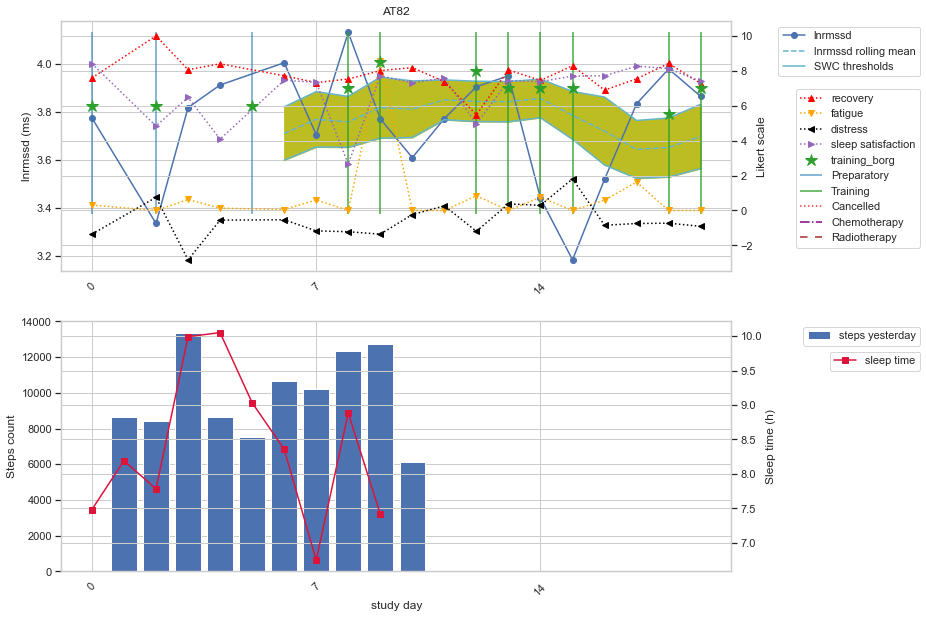

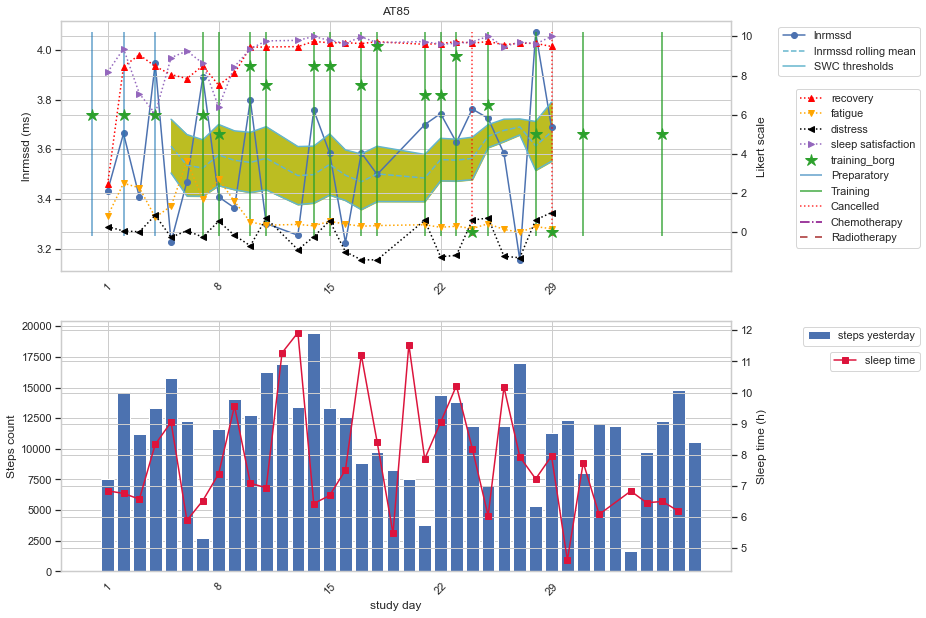

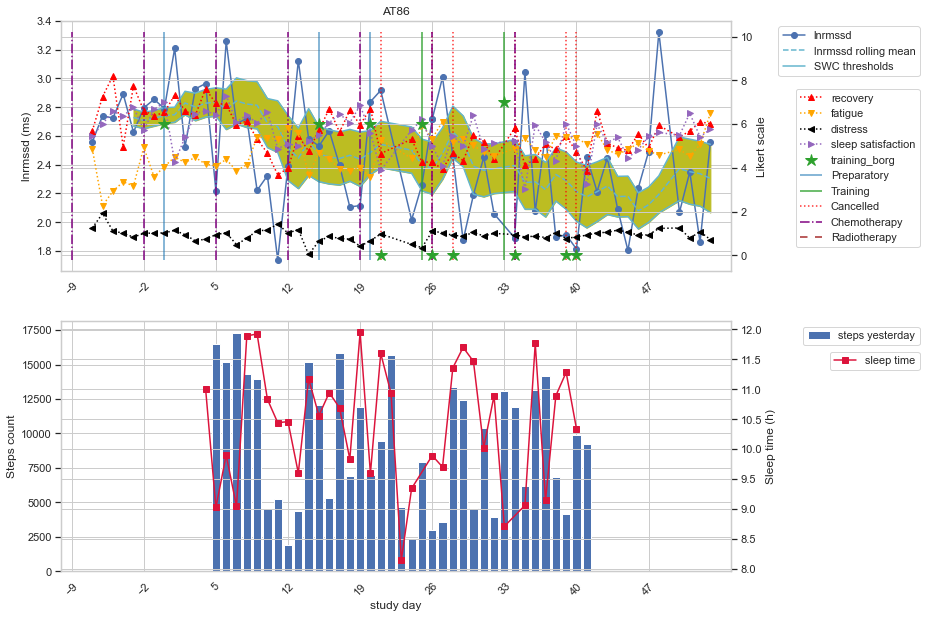

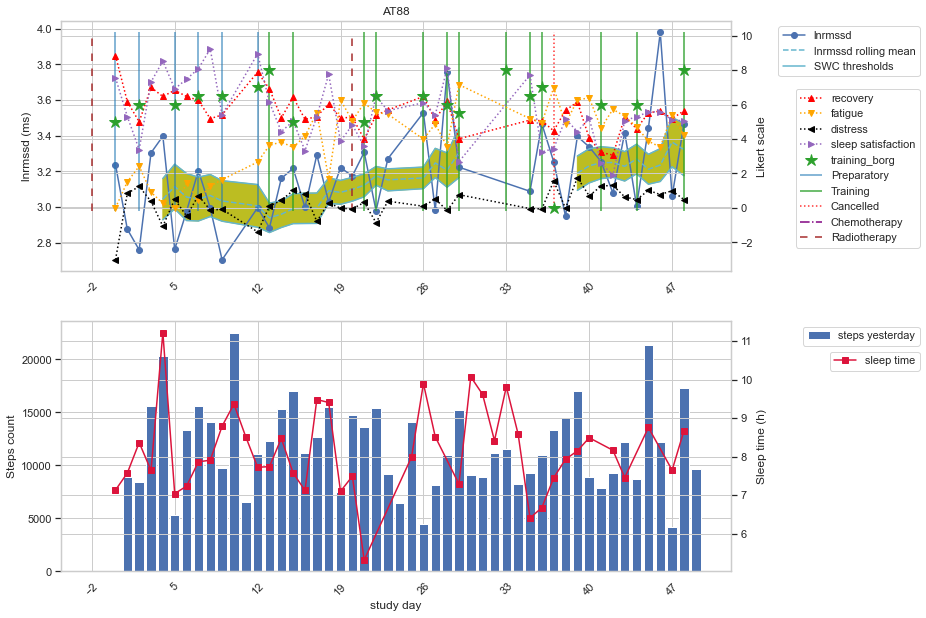

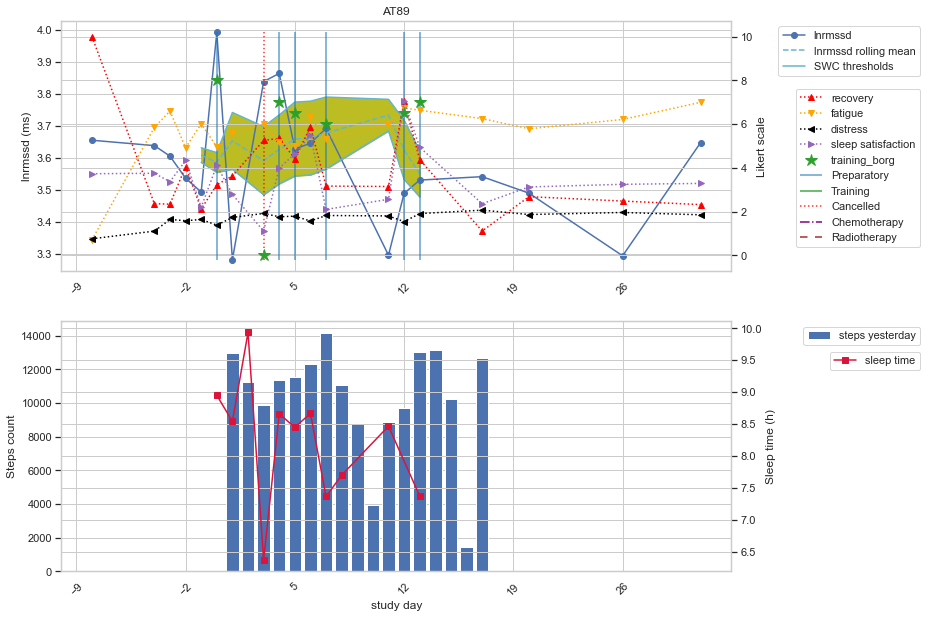

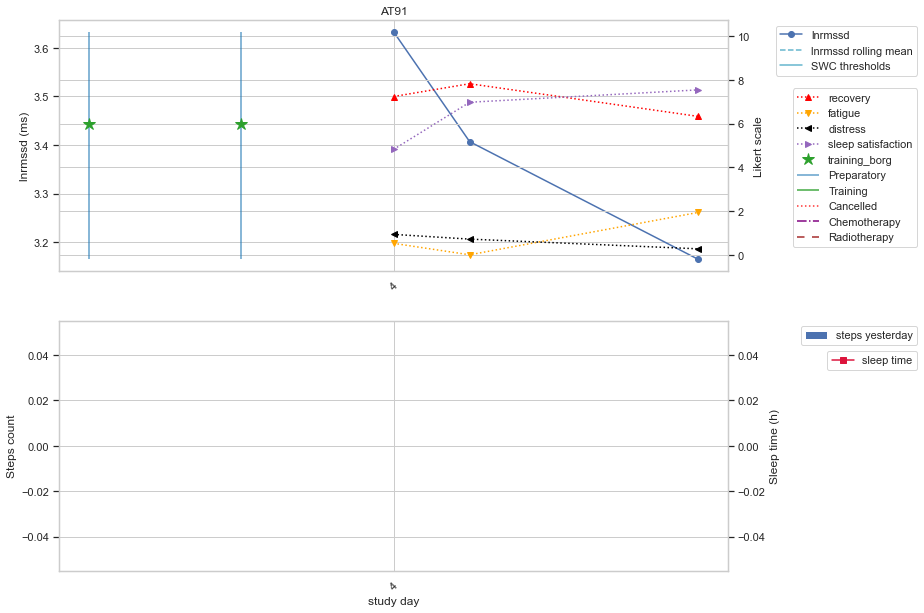

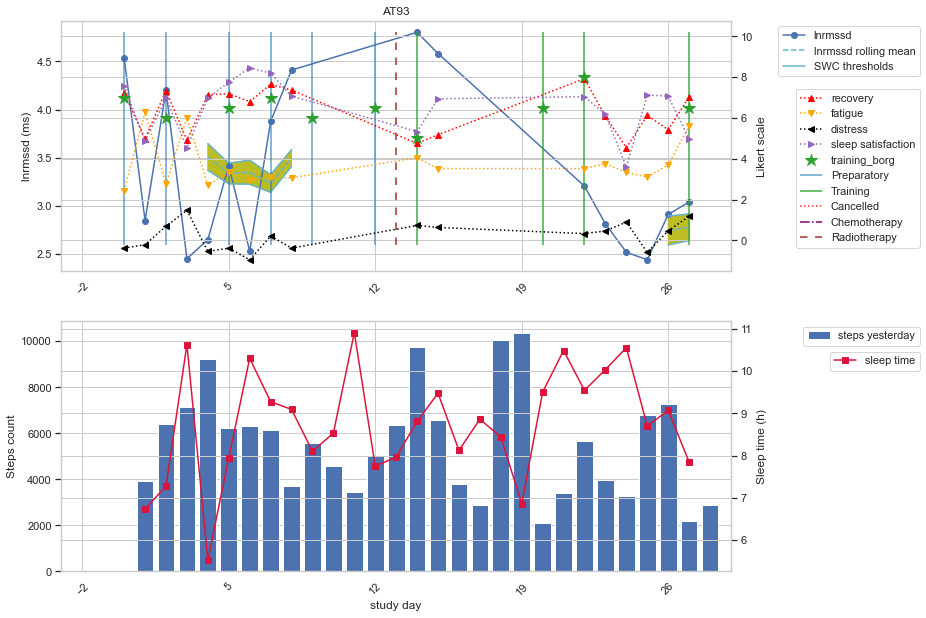

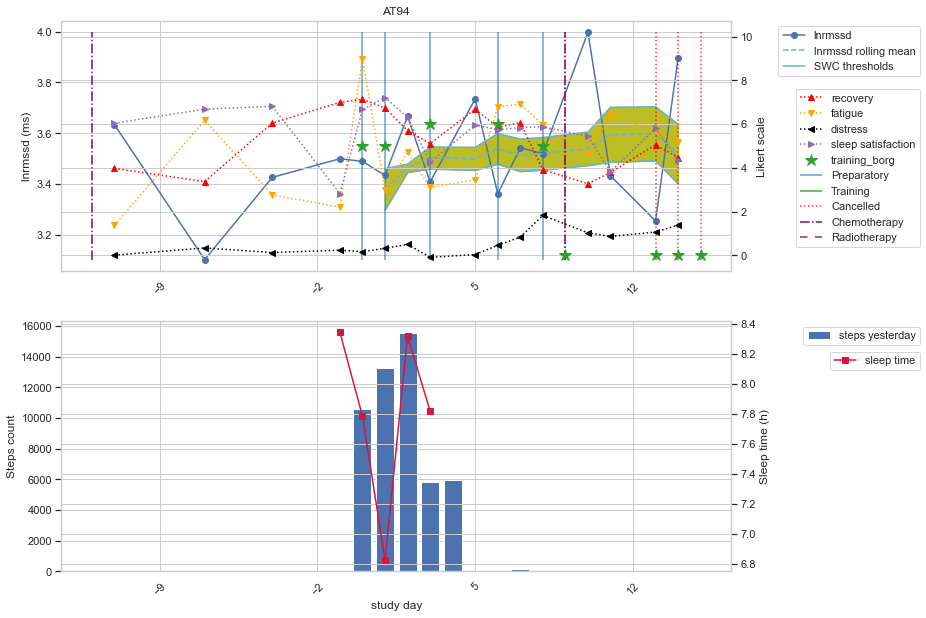

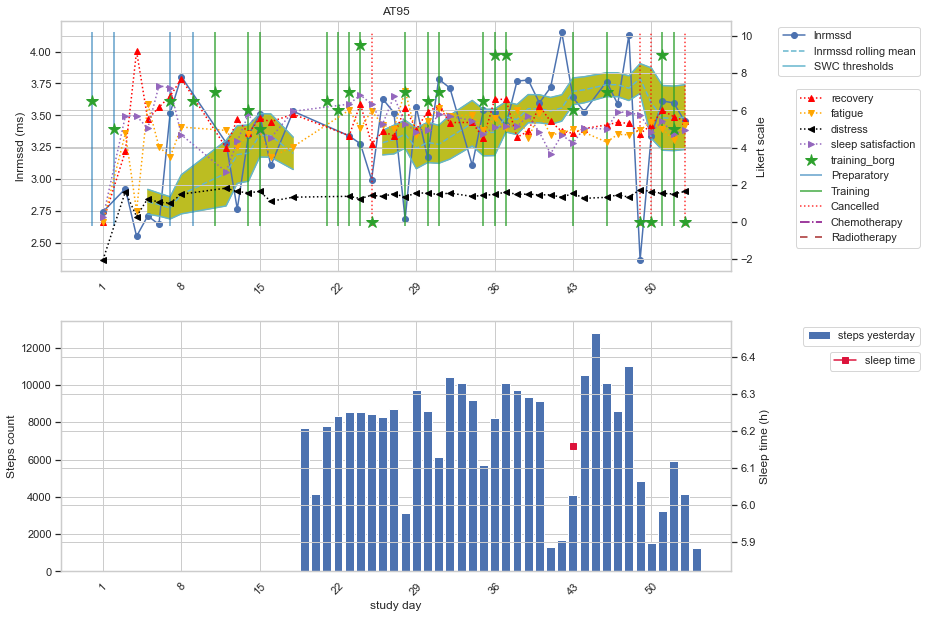

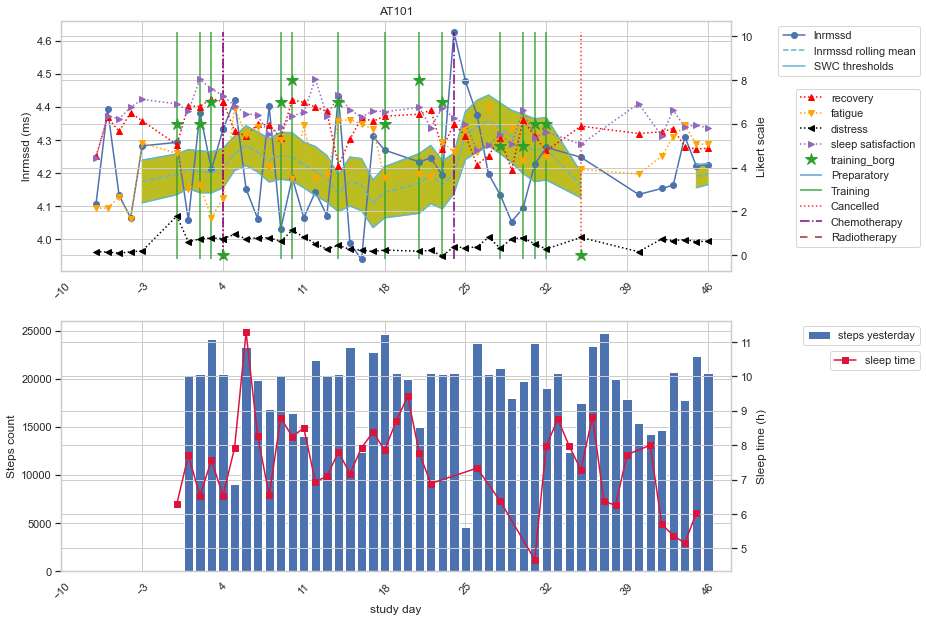

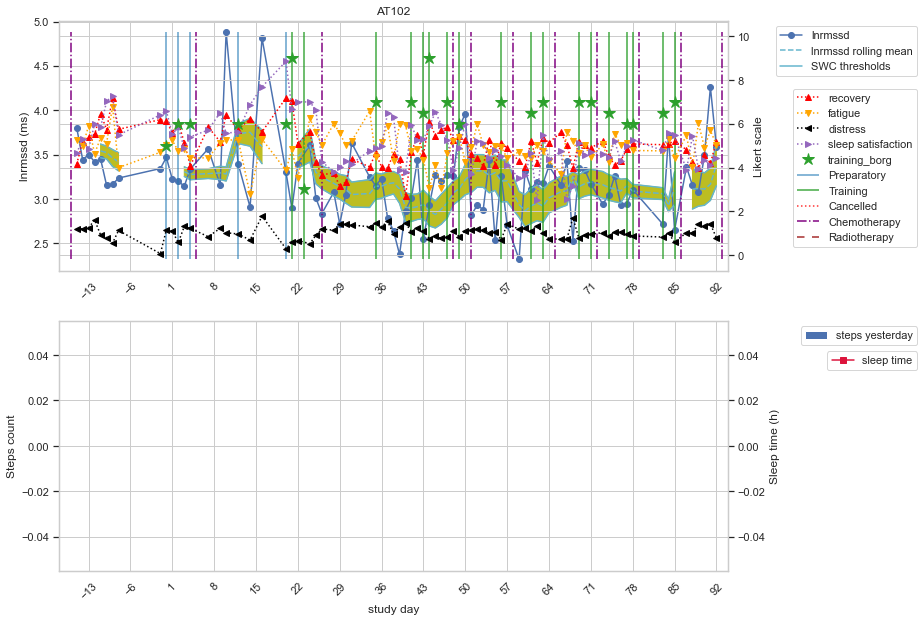

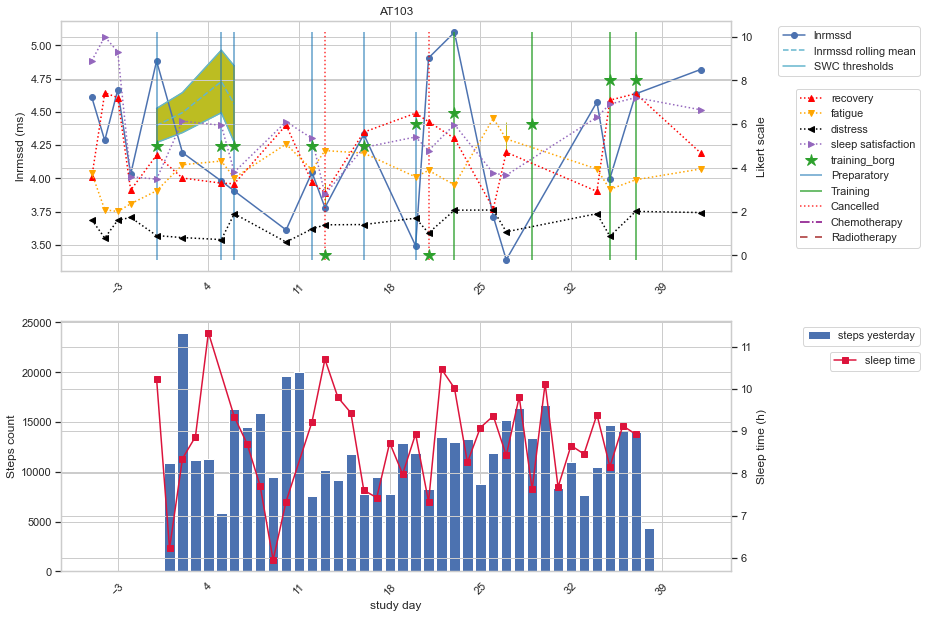

In [60]:
# import matplotlib.dates as mdates
import matplotlib.ticker as ticker

plot_scale_factor = 3/4 
plt.rcParams['figure.figsize'] = (16*plot_scale_factor,9*1.5*plot_scale_factor)

selectedusers = ['AT49', 'AT51', 'AT59', 'AT62',
       'AT63', 'AT65', 'AT66', 'AT68', 'AT73', 'AT75',
       'AT76', 'AT77', 'AT82', 'AT85', 'AT86', 'AT88',
       'AT89', 'AT91', 'AT93',
       'AT94', 'AT95',
       'AT101', 'AT102', 'AT103'
    ]

# The following users are not included due to not having enough and valid HRV data to plot
# removed_users = ['AT91']


for selecteduser in selectedusers:
    # selecteduser = 'AT68'

    selection = (daily_records['username'] == selecteduser)
    x = daily_records.loc[selection, 'study_day']
    y = daily_records.loc[selection, 'lnrmssd']
    y_ref = daily_records.loc[selection, 'lnrmssd_ref_mean']
    # y_ref_up = daily_records.loc[selection, 'lnrmssd_ref_mean']+0.5*np.exp(daily_records.loc[selection, 'lnrmssd_ref_std']) 
    # y_ref_down = daily_records.loc[selection, 'lnrmssd_ref_mean']-0.5*np.exp(daily_records.loc[selection, 'lnrmssd_ref_std'])
    y_ref_up = daily_records.loc[selection, 'lnrmssd_ref_mean']+0.5*(daily_records.loc[selection, 'lnrmssd_ref_std'])
    y_ref_down = daily_records.loc[selection, 'lnrmssd_ref_mean']-0.5*(daily_records.loc[selection, 'lnrmssd_ref_std'])

    # Set up plot
    fig, ax = plt.subplots(2,1, sharex=True)
    ax[0].tick_params('x', labelbottom=True)
    ax[1].tick_params('x', labelbottom=True)

    # Plot HRV values
    ax[0].plot(x, y, marker='o', linestyle='-', label='lnrmssd')
    ax[0].plot(x, y_ref, 'c--', label = 'lnrmssd rolling mean')
    ax[0].plot(x, y_ref_up, 'c-', label = 'SWC thresholds')
    ax[0].plot(x, y_ref_down, 'c-')
    ax[0].fill_between(x, y_ref_up, y_ref_down, color='tab:olive')

    # Plot ATOPE values + session intensity (borg)
    ax0twin = ax[0].twinx()
    y_rec = daily_records.loc[selection, 'recovery']
    y_fat = daily_records.loc[selection, 'fatigue']
    y_dis = daily_records.loc[selection, 'distress']
    y_sle = daily_records.loc[selection, 'sleep_satisfaction']
    y_borg = daily_records.loc[selection, 'training_borg']
    ax0twin.plot(x, y_rec, label='recovery', color='red', marker='^', linestyle=':')
    ax0twin.plot(x, y_fat, label='fatigue', color='orange', marker='v', linestyle=':')
    ax0twin.plot(x, y_dis, label='distress', color='black', marker='<', linestyle=':')
    ax0twin.plot(x, y_sle, label='sleep satisfaction', color='tab:purple', marker='>', linestyle=':')
    ax0twin.plot(x, y_borg, label='training_borg', color='tab:green', marker='*', linestyle='', markersize=12)

    # Plot intervention days
    ispreparation = daily_records['session_type'].str.match('preparatory_training')  # match('^P.*')
    isintervention = daily_records['session_type'].str.match('adjusted_training')  # match('^S.*')
    isfailure = daily_records['session_type'].str.match('miss_\w+')
    ischemo = daily_records['session_type'].str.match('chemo_\w+')
    isradio = daily_records['session_type'].str.match('radio_\w+')
    miny = np.min(y)
    maxy = np.max(y)

    ax0twin.vlines(x=daily_records.loc[(selection & ispreparation), 'study_day'], ymax=10.2, ymin=-0.2, color='tab:blue', alpha=0.7, label='Preparatory', linestyle='solid')
    ax0twin.vlines(x=daily_records.loc[(selection & isintervention), 'study_day'], ymax=10.2, ymin=-0.2, color='tab:green', alpha=0.9, label='Training', linestyle='solid')
    ax0twin.vlines(x=daily_records.loc[(selection & isfailure), 'study_day'], ymax=10.2, ymin=-0.2, color='red', alpha=0.8, label='Cancelled', linestyle='dotted')
    ax0twin.vlines(x=daily_records.loc[(selection & ischemo), 'study_day'], ymax=10.2, ymin=-0.2, color='purple', label='Chemotherapy', linestyle='dashdot')
    ax0twin.vlines(x=daily_records.loc[(selection & isradio), 'study_day'], ymax=10.2, ymin=-0.2, color='brown', label='Radiotherapy', linestyle=(0, (5,5)))

    # Set up ticks and grid
    # ax[0].grid()
    # ax[0].xaxis.set_major_locator(mdates.WeekdayLocator()) # Select date tickers with mdates (https://matplotlib.org/stable/api/dates_api.html)
    ax[0].tick_params(axis='x', rotation=45)

    # Steps
    thereisactivity = (daily_records['steps_total_yesterday']>0) & (daily_records['steps_total_yesterday'].notna())
    x_steps = daily_records.loc[(selection & thereisactivity), 'study_day']
    y_steps = daily_records.loc[(selection & thereisactivity), 'steps_total_yesterday']

    # Plot steps
    ax[1].bar(x_steps, y_steps, label='steps yesterday')

    # Sleep
    thereissleep = (daily_records['sleep_total']>0)
    x_sleep = daily_records.loc[(selection & thereissleep), 'study_day']
    y_sleep = daily_records.loc[(selection & thereissleep), 'sleep_total']/3600
    df_sleep = pd.DataFrame([x_sleep,y_sleep]).T.sort_values('study_day').drop_duplicates()

    # Plot sleep
    ax1twin = ax[1].twinx()
    ax1twin.plot(df_sleep['study_day'].values, df_sleep['sleep_total'].values, label='sleep time', marker='s', color='crimson')

    # # Set up ticks and grid
    # ax[1].grid()
    # ax[1].xaxis.set_major_locator(mdates.WeekdayLocator()) # Select date tickers with mdates (https://matplotlib.org/stable/api/dates_api.html)
    ax[1].tick_params(axis='x', rotation=45)


    # # X limits
    xlimselection = (daily_records['username'] == selecteduser) & (daily_records['cv_lnrmssd'].notna())
    xlimvalues = daily_records.loc[xlimselection, 'study_day']
    if selecteduser in ['AT59', 'AT68', 'AT86', 'AT93', 'AT101', 'AT102']:
        ax[0].set_xlim(xlimvalues.min()-7, xlimvalues.max()+2)

    # Axes labels and titles
    ax[0].set_title(selecteduser)
    ax[1].set_xlabel('study day')
    ax[0].set_ylabel('lnrmssd (ms)')
    ax[1].set_ylabel('Steps count')
    ax0twin.set_ylabel('Likert scale')
    ax1twin.set_ylabel('Sleep time (h)')
    #ax1twin.set_ylabel('Activity time (min)')

    # Legend
    ax[0].legend(bbox_to_anchor=(1.29, 1))
    #ax0twin.legend(bbox_to_anchor=(1.26325, 0.75))
    ax0twin.legend(bbox_to_anchor=(1.29, 0.75))
    ax[1].legend(bbox_to_anchor=(1.29, 1))
    ax1twin.legend(bbox_to_anchor=(1.29, 0.9))

    # This was for DATES
    # ax[0].xaxis.set_major_locator(mdates.WeekdayLocator()) # Select date tickers with mdates (https://matplotlib.org/stable/api/dates_api.html)
    # ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    # ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO)) # Select date tickers with mdates (https://matplotlib.org/stable/api/dates_api.html)

    # For STUDY DAY
    if selecteduser!='AT51':
        ax[0].xaxis.set_major_locator(ticker.IndexLocator(base=7, offset=np.min(x)))

    # fig.tight_layout()
    fig.savefig('viz/'+selecteduser+'.pdf', bbox_inches='tight')

plot_scale_factor = 3/4 
plt.rcParams['figure.figsize'] = (16*plot_scale_factor,9*plot_scale_factor)

### Feature Selection
Feature selection using maximum variance and correlation thresholds.

##### Maximum variance method
Maximum variance set with threshold equal to p(1-p) where p=0.8.

In [61]:
# Add treatment column in daily_records
for index, row in demographics.iterrows():
    u = row['username']
    t = row['treatment']
    i = (daily_records['username'] == u) # rows for each username
    daily_records.loc[i, 'treatment'] = t

daily_records['treatment'].value_counts()

chemo              630
radio              470
treatment-naive    142
Name: treatment, dtype: int64

In [62]:
# Feature selection by Variance
from sklearn.feature_selection import VarianceThreshold

print('Columns available:')
print(daily_records.columns)

# Remove string and dummy features from variance analysis
columns_initial_discard = ['username', 'study_day', 'session_type', 'treatment']

# columns_categorical = ['swc_lnrmssd_ok', 'cv_lnrmssd_ok']
df = daily_records.drop(columns_initial_discard, axis=1)
columns_var = df.columns

# Train model
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit(df)

# Get get columns selected and removed
mask = sel.get_support()
columns_var_selected = columns_var[mask]
columns_var_removed = columns_var[~mask]
print('\nColumns selected:')
print(columns_var_selected)
print('\nColumns removed:')
print(columns_var_removed)

Columns available:
Index(['username', 'study_day', 'session_type', 'session_number',
       'training_borg', 'swc_lnrmssd_ok', 'cv_lnrmssd_ok', 'lnrmssd',
       'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 'cv_lnrmssd',
       'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio',
       'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 'min_hr',
       'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'ratio_sd2_sd1',
       'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 'sleep_satisfaction',
       'sleep_time', 'distress', 'recovery', 'fatigue', 'sleep_deep',
       'sleep_light', 'sleep_rem', 'sleep_wake', 'sleep_total',
       'steps_light_yesterday', 'steps_moderate_yesterday',
       'steps_total_yesterday', 'steps_vigorous_yesterday',
       'sleep_satisfaction_zscored', 'sleep_time_zscored', 'distress_zscored',
       'recovery_zscored', 'fatigue_zscored', 'treatment'],
      dtype='object')

Columns selected:
Index(['session_number', 'training_

##### Maximum correlation method
Maximum correlation set to 0.8. Several plots are shown to ease the process of feature selection. This is the process:
1. Remove features strongly correlated with lnrmssd (most important feature in bibliogrphy)
2. 

lnrmssd    16
sd1        16
sdsd       16
cvsd       16
hf         16
dtype: int64


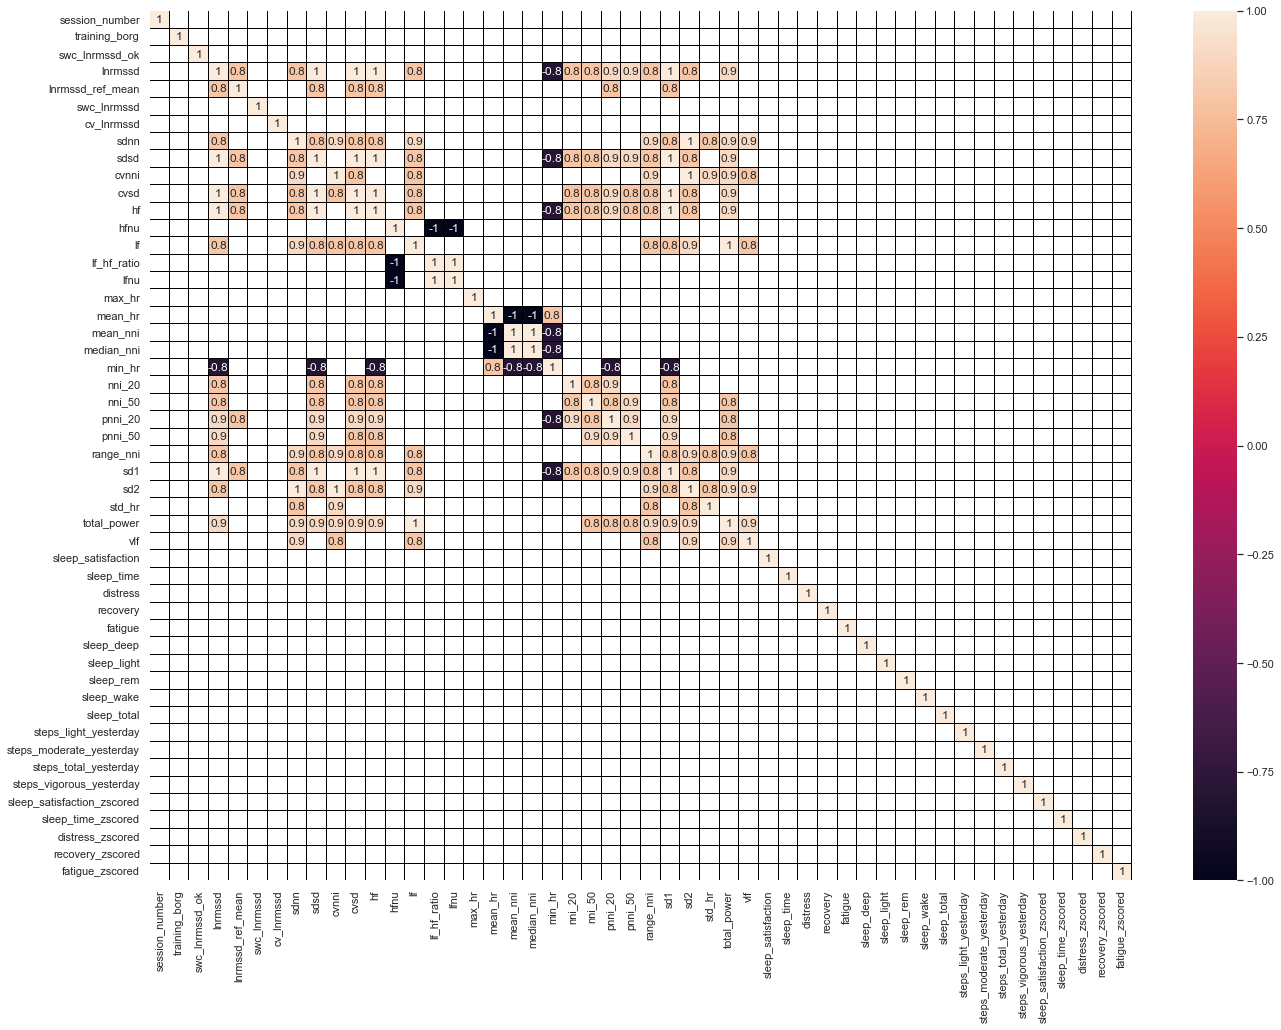

In [63]:
# Correlation analysis
columns_correlation_removed = columns_initial_discard + columns_var_removed.values.tolist()
df = daily_records.drop(columns_correlation_removed, axis=1)

corr = df.corr()
corr = corr.round(1)
mask = (corr >= 0.8) | (corr <= -0.8)

fig, ax = plt.subplots(figsize=(22,16))
sns.heatmap(corr[mask].round(1), annot=True, linewidths=0.01, linecolor='black', ax=ax)
print(pd.Series(mask.sum()).sort_values(ascending=False).head())

hfnu           3
lf_hf_ratio    3
median_nni     3
mean_nni       3
mean_hr        3
dtype: int64


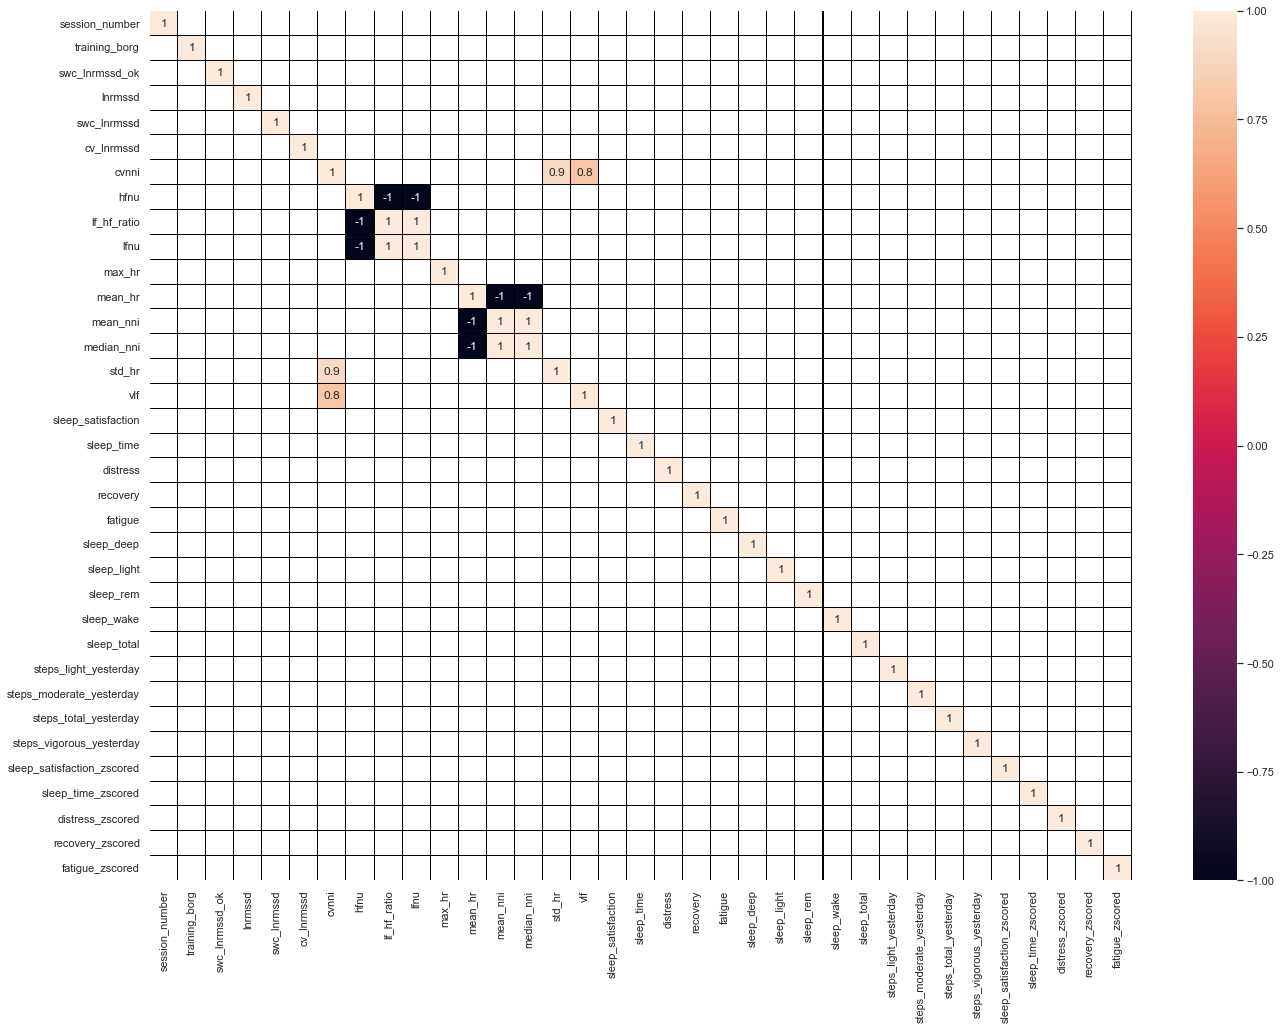

In [64]:
# Select all the columns with correlation >= 0.8
## Keep lnrmssd
columns_like_lnrmssd = ['sdnn', 'sdsd', 'cvsd', 'hf', 'lf', 'min_hr', 'nni_20',
    'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'sd1', 'sd2', 'total_power', 'lnrmssd_ref_mean']

# Remove lnrmssd-correlated features
columns_correlation_removed = columns_initial_discard # + columns_categorical
columns_correlation_removed = columns_correlation_removed + columns_var_removed.values.tolist() + columns_like_lnrmssd
df = daily_records.drop(columns_correlation_removed, axis=1)

corr = df.corr().round(1)
mask = (corr >= 0.8) | (corr <= -0.8)

fig, ax = plt.subplots(figsize=(22,16))
sns.heatmap(corr[mask].round(1), annot=True, linewidths=0.01, linecolor='black', ax=ax)
print(pd.Series(mask.sum()).sort_values(ascending=False).head())

fatigue_zscored    1
recovery           1
training_borg      1
swc_lnrmssd_ok     1
lnrmssd            1
swc_lnrmssd        1
cv_lnrmssd         1
cvnni              1
lf_hf_ratio        1
max_hr             1
dtype: int64


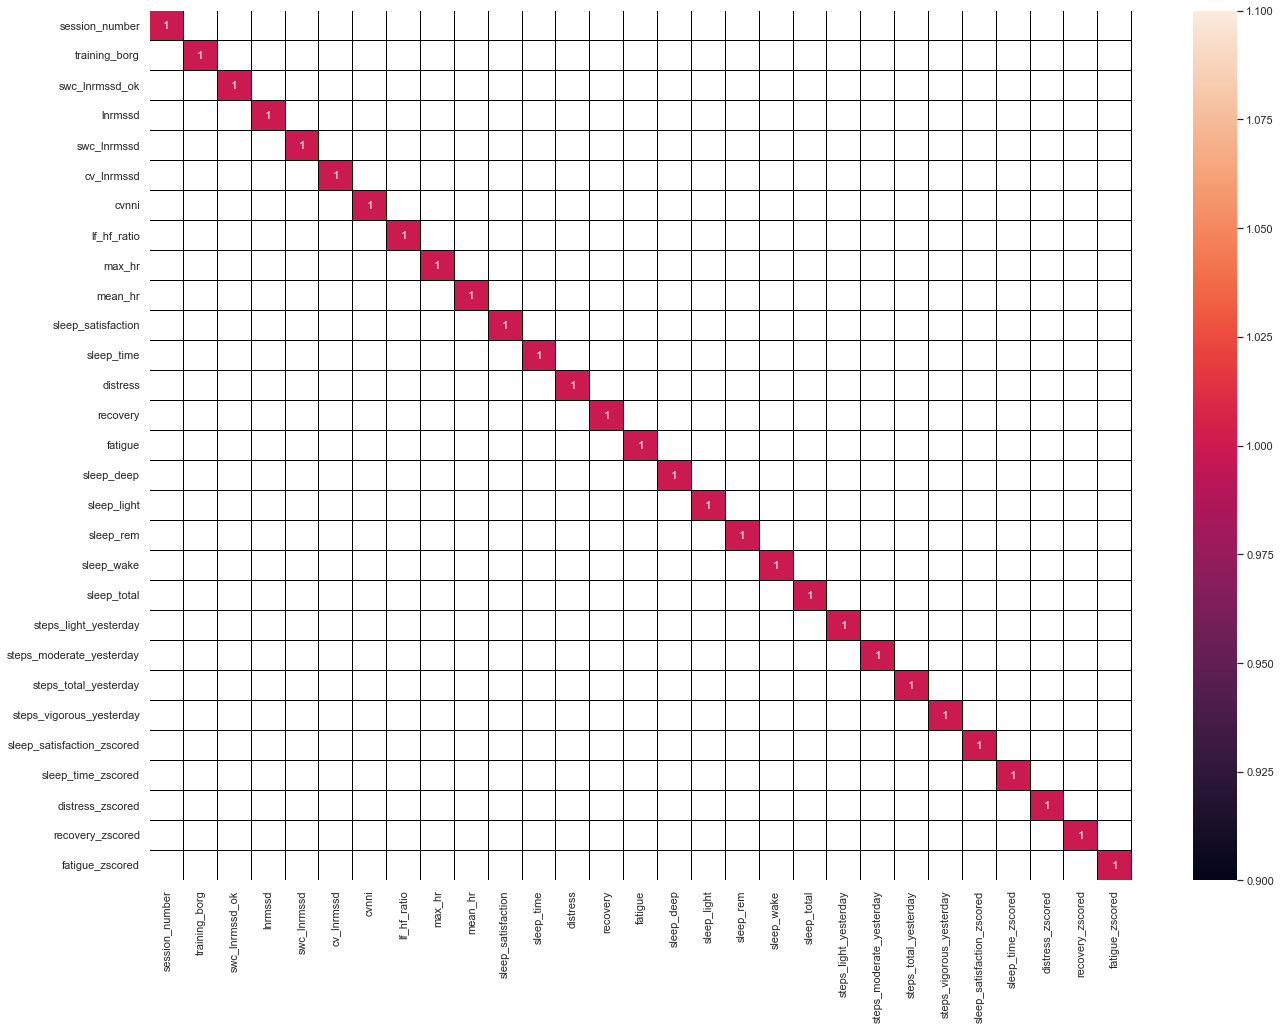

In [65]:
# Keep cvnni, lf_hf_ratio, mean_hr
columns_correlated_step2 = ['vlf', 'std_hr', 'hfnu', 'lfnu', 
    'mean_nni', 'median_nni']


# Remove sd2-like features
columns_correlation_removed = columns_initial_discard# + columns_categorical
columns_correlation_removed = columns_correlation_removed + columns_var_removed.values.tolist() + columns_like_lnrmssd + columns_correlated_step2
df = daily_records.drop(columns_correlation_removed, axis=1)

corr = df.corr().round(1)
mask = (corr >= 0.8) | (corr <= -0.8)

fig, ax = plt.subplots(figsize=(22,16))
sns.heatmap(corr[mask].round(1), annot=True, linewidths=0.01, linecolor='black', ax=ax)
print(pd.Series(mask.sum()).sort_values(ascending=False).head(10))

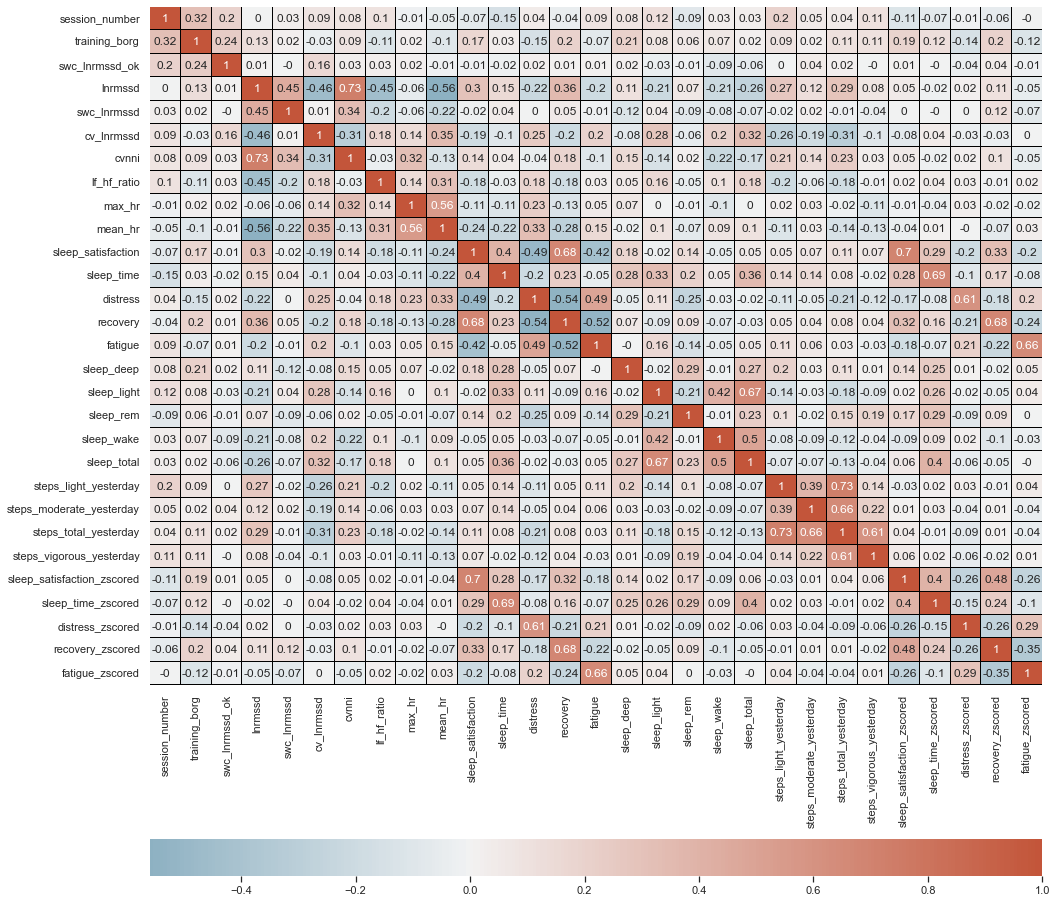

In [66]:
# Compute full correlation analysis
corr = df.corr()


# Plot
grid_kws = {"height_ratios": (.9, .05), "hspace": .43}
fig, (ax, cbar_ax) = plt.subplots(2, figsize=(16,16), gridspec_kw=grid_kws) # 
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr.round(2), annot=True, linewidths=0.01, linecolor='black', 
            cmap=cmap, center=0, ax=ax, 
            cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})
fig.savefig('viz/correlation-analysis.pdf', bbox_inches='tight')

### Analysis by Intervention Arm
#### Group by Treatment
This first analysis compares the data between intervention arms, as it is usually done.

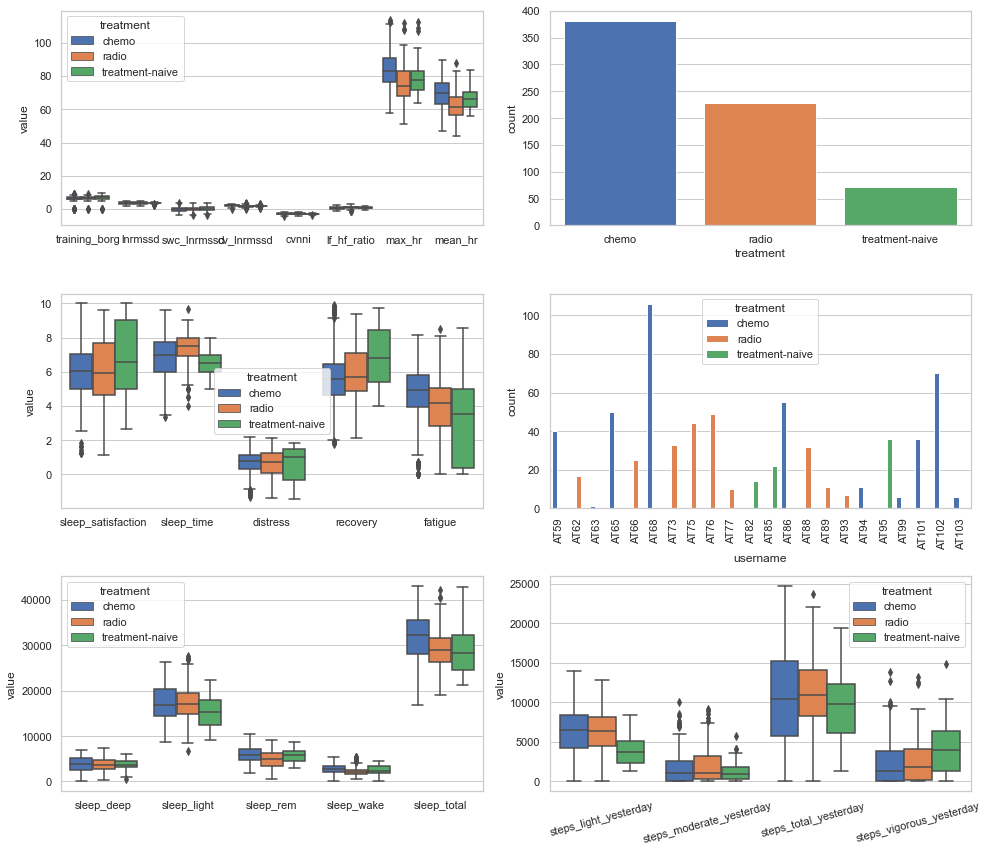

In [67]:
# Filter data
hrv_variables = ['training_borg', 'lnrmssd', 'swc_lnrmssd', 'cv_lnrmssd', 'cvnni', 'lf_hf_ratio', 'max_hr', 'mean_hr']
wellness_variables = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue']
fitbit_sleep_variables = ['sleep_deep', 'sleep_light', 'sleep_rem', 'sleep_wake', 'sleep_total']
fitbit_steps_variables = ['steps_light_yesterday', 'steps_moderate_yesterday',
       'steps_total_yesterday', 'steps_vigorous_yesterday']


# Work on copy for visualization
condition = daily_records['cv_lnrmssd'].notna()
df_plot = daily_records[condition].copy()

# First plot
id_vars = ['treatment', 'username']
variables = hrv_variables
df_cluster = df_plot.melt(id_vars=id_vars).dropna()
condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
df_cluster = df_cluster[condition_cluster]

fig, ax = plt.subplots(3,2,  figsize=(14,12)) #gridspec_kw={'width_ratios': [6, 4]})
sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
            #showmeans=True,
            ax=ax[0,0], saturation=1)
ax[0,0].set_xlabel('')
# ax[0,0].tick_params('x', rotation=45)


# Second plot
id_vars = ['treatment', 'username']
variables = wellness_variables
df_cluster = df_plot.melt(id_vars=id_vars).dropna()
condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
df_cluster = df_cluster[condition_cluster]

sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
            #showmeans=True, 
            ax=ax[1,0], saturation=1)
ax[1,0].set_xlabel('')
# ax[1,0].tick_params('x', rotation=45)

# Fifth plot
id_vars = ['treatment', 'username']
variables = fitbit_sleep_variables
df_cluster = df_plot.melt(id_vars=id_vars).dropna()
condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
df_cluster = df_cluster[condition_cluster]

sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
              #showmeans=True, 
              ax=ax[2,0], saturation=1)
ax[2,0].set_xlabel('')
# ax[2,0].tick_params('x', rotation=45)

# Sixth plot
id_vars = ['treatment', 'username']
variables = fitbit_steps_variables
df_cluster = df_plot.melt(id_vars=id_vars).dropna()
condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
df_cluster = df_cluster[condition_cluster]

sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
              #showmeans=True, 
              ax=ax[2,1], saturation=1)
ax[2,1].set_xlabel('')
ax[2,1].tick_params('x', rotation=15)


# Third plot
df_cluster = df_plot
sns.countplot(x='treatment', data=df_cluster,
                saturation=1, ax=ax[0,1])

# Fourth plot
sns.countplot(x='username', hue='treatment', data=df_cluster,
                saturation=1, ax=ax[1,1])
ax[1,1].tick_params('x', rotation=90)

fig.tight_layout()
fig.savefig('viz/treatment-analysis-3.pdf', bbox_inches='tight')


In [68]:
# Normality: rejected for most variables
from scipy import stats

# Filters
condition_valid = daily_records['cv_lnrmssd'].notna()
condition_chemo = daily_records['treatment']=='chemo'
condition_radio = daily_records['treatment']=='radio'
condition_naive = daily_records['treatment']=='treatment-naive'

# Variable setup
variables = hrv_variables + wellness_variables + fitbit_sleep_variables + fitbit_steps_variables

# Prepare dataframe
columns = ['chemo', 'radio', 'treatment-naive']
sh = pd.DataFrame(columns=columns)

for v in variables:
    x = daily_records.loc[condition_valid & condition_chemo, v].dropna()
    y = daily_records.loc[condition_valid & condition_radio, v].dropna()
    z = daily_records.loc[condition_valid & condition_naive, v].dropna()

    # Compute stats
    sh.loc[v,columns[0]] = (stats.shapiro(x)).pvalue
    sh.loc[v,columns[1]] = (stats.shapiro(y)).pvalue
    sh.loc[v,columns[2]] = (stats.shapiro(z)).pvalue

# Plot
sh
sh[sh<0.05]

chemo        radio treatment-naive
training_borg             9.07418e-12  2.74977e-12     6.30232e-06
lnrmssd                   0.000140599          NaN     0.000628786
swc_lnrmssd                 0.0073899     0.037049             NaN
cv_lnrmssd                1.52014e-08    9.479e-07     0.000343161
cvnni                             NaN    0.0238694             NaN
lf_hf_ratio                 0.0023532          NaN             NaN
max_hr                    2.48592e-05    0.0111789      7.5853e-05
mean_hr                      0.035364          NaN       0.0256817
sleep_satisfaction                NaN  0.000210602     0.000130554
sleep_time                1.03657e-06  2.83981e-06       0.0108061
distress                  0.000334352   0.00125248     3.82816e-07
recovery                  1.04943e-06   0.00192495     4.11857e-05
fatigue                   3.62784e-12          NaN     7.97716e-07
sleep_deep                        NaN          NaN             NaN
sleep_light                       NaN          NaN             NaN
sleep_rem                         NaN          NaN             NaN
sleep_wake                        NaN   1.8075e-09             NaN
sleep_total                       NaN          NaN             NaN
steps_light_yesterday      0.00111441          NaN      0.00521246
steps_moderate_yesterday  9.75655e-16  1.27817e-14     4.48929e-05
steps_total_yesterday     0.000173414          NaN             NaN
steps_vigorous_yesterday  9.06586e-16  1.09594e-12      0.00647556

In [69]:
# Kruskal wallis
from scipy import stats

# Filters
condition_valid = daily_records['cv_lnrmssd'].notna()
condition_chemo = daily_records['treatment']=='chemo'
condition_radio = daily_records['treatment']=='radio'
condition_naive = daily_records['treatment']=='treatment-naive'

# Variable setup
variables = hrv_variables + wellness_variables + fitbit_sleep_variables + fitbit_steps_variables

# Prepare dataframe
columns = ['chemo vs radio', 'chemo vs t.naive', 'radio vs t.naive']
kw = pd.DataFrame(columns=columns)

for v in variables:
    x = daily_records.loc[condition_valid & condition_chemo, v].dropna()
    y = daily_records.loc[condition_valid & condition_radio, v].dropna()
    z = daily_records.loc[condition_valid & condition_naive, v].dropna()

    # Compute stats
    kw.loc[v,columns[0]] = (stats.kruskal(x,y)).pvalue
    kw.loc[v,columns[1]] = (stats.kruskal(x,z)).pvalue
    kw.loc[v,columns[2]] = (stats.kruskal(y,z)).pvalue

# Plot
kw
#kw[kw<0.05]

chemo vs radio chemo vs t.naive radio vs t.naive
training_borg                 0.0672841        0.0414236         0.213175
lnrmssd                     0.000169649        0.0681807         0.521851
swc_lnrmssd                    0.498597         0.156645         0.400927
cv_lnrmssd                  1.45525e-12       0.00244395       0.00691988
cvnni                          0.900023       0.00964016        0.0402835
lf_hf_ratio                    0.132885        0.0421628       0.00119582
max_hr                      9.99988e-22      2.89369e-05       0.00463136
mean_hr                     3.75182e-24      0.000329185      2.47595e-05
sleep_satisfaction             0.820798       0.00919603       0.00603497
sleep_time                  1.24038e-06      4.74763e-05      1.76519e-15
distress                       0.054357         0.961638         0.991296
recovery                      0.0114292      5.65964e-08      7.40217e-05
fatigue                     1.27737e-07      6.35455e-08       0.00150116
sleep_deep                     0.422523          0.83389         0.778846
sleep_light                    0.860098          0.04143        0.0153549
sleep_rem                   4.78945e-05         0.992307        0.0138891
sleep_wake                  1.14262e-06         0.597562        0.0336316
sleep_total                  9.4535e-06       0.00949862         0.448448
steps_light_yesterday          0.707806      7.37283e-08      1.01719e-09
steps_moderate_yesterday       0.104534         0.824248         0.260852
steps_total_yesterday          0.220806         0.231716        0.0118881
steps_vigorous_yesterday         0.1089       5.8545e-05      0.000900769

In [70]:
# Save to latex input
kw.round(2).to_latex('./tab/kruskal-wallis-treatment-3.tex')

#### Group by radio and treatment naive
Patients with chemotherapy may have a different response to training adaptation due toxicity treatment, hence can be compared to radio/treatment-naive at the same time

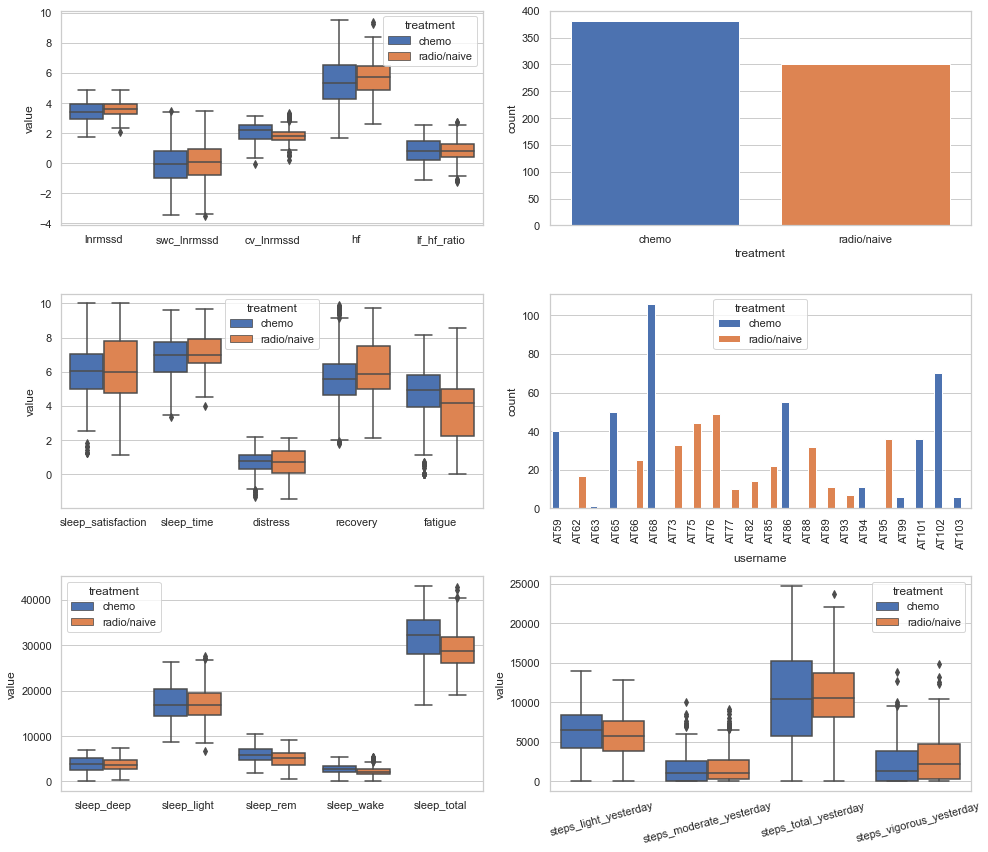

In [71]:
# Filter data
hrv_variables = ['lnrmssd', 'swc_lnrmssd', 'cv_lnrmssd', 'hf', 'lf_hf_ratio']
wellness_variables = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue']
fitbit_sleep_variables = ['sleep_deep', 'sleep_light', 'sleep_rem', 'sleep_wake', 'sleep_total']
fitbit_steps_variables = ['steps_light_yesterday', 'steps_moderate_yesterday',
       'steps_total_yesterday', 'steps_vigorous_yesterday']


# Work on copy for visualization
condition = daily_records['cv_lnrmssd'].notna()
df_plot = daily_records[condition].copy()

## Group radio and prechemo groups
is_naive = (df_plot['treatment'] == 'treatment-naive')
is_radio = (df_plot['treatment'] == 'radio')
df_plot.loc[(is_radio | is_naive), 'treatment'] = 'radio/naive'

# First plot
id_vars = ['treatment', 'username']
variables = hrv_variables
df_cluster = df_plot.melt(id_vars=id_vars).dropna()
condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
df_cluster = df_cluster[condition_cluster]

fig, ax = plt.subplots(3,2,  figsize=(14,12)) #gridspec_kw={'width_ratios': [6, 4]})
sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
            #showmeans=True,
            ax=ax[0,0], saturation=1)
ax[0,0].set_xlabel('')
# ax[0,0].tick_params('x', rotation=45)


# Second plot
id_vars = ['treatment', 'username']
variables = wellness_variables
df_cluster = df_plot.melt(id_vars=id_vars).dropna()
condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
df_cluster = df_cluster[condition_cluster]

sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
            #showmeans=True, 
            ax=ax[1,0], saturation=1)
ax[1,0].set_xlabel('')
# ax[1,0].tick_params('x', rotation=45)

# Fifth plot
id_vars = ['treatment', 'username']
variables = fitbit_sleep_variables
df_cluster = df_plot.melt(id_vars=id_vars).dropna()
condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
df_cluster = df_cluster[condition_cluster]

sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
              #showmeans=True, 
              ax=ax[2,0], saturation=1)
ax[2,0].set_xlabel('')
# ax[2,0].tick_params('x', rotation=45)

# Sixth plot
id_vars = ['treatment', 'username']
variables = fitbit_steps_variables
df_cluster = df_plot.melt(id_vars=id_vars).dropna()
condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
df_cluster = df_cluster[condition_cluster]

sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
              #showmeans=True, 
              ax=ax[2,1], saturation=1)
ax[2,1].set_xlabel('')
ax[2,1].tick_params('x', rotation=15)


# Third plot
df_cluster = df_plot
sns.countplot(x='treatment', data=df_cluster,
                saturation=1, ax=ax[0,1])

# Fourth plot
sns.countplot(x='username', hue='treatment', data=df_cluster,
                saturation=1, ax=ax[1,1])
ax[1,1].tick_params('x', rotation=90)

fig.tight_layout()
fig.savefig('viz/treatment-analysis-2.pdf', bbox_inches='tight')


In [72]:
# Kruskal wallis
from scipy import stats

# Filters
condition_chemo = df_plot['treatment']=='chemo'
condition_radionaive = df_plot['treatment']=='radio/naive'

# Variable setup
variables = hrv_variables + wellness_variables + fitbit_sleep_variables + fitbit_steps_variables

# Prepare dataframe
columns = ['chemo vs radio/naive']
kw = pd.DataFrame(columns=columns)

for v in variables:
    x = df_plot.loc[condition_valid & condition_chemo, v].dropna()
    y = df_plot.loc[condition_valid & condition_radionaive, v].dropna()

    # Compute stats
    kw.loc[v,columns[0]] = (stats.kruskal(x,y)).pvalue

# Plot
kw
kw[kw<0.05]

chemo vs radio/naive
lnrmssd                           0.000128482
swc_lnrmssd                               NaN
cv_lnrmssd                        1.82268e-12
hf                                  0.0172388
lf_hf_ratio                               NaN
sleep_satisfaction                        NaN
sleep_time                          0.0176766
distress                                  NaN
recovery                           2.0863e-05
fatigue                           7.18644e-11
sleep_deep                                NaN
sleep_light                               NaN
sleep_rem                         0.000281299
sleep_wake                        7.52242e-06
sleep_total                       4.34254e-06
steps_light_yesterday               0.0272219
steps_moderate_yesterday                  NaN
steps_total_yesterday                     NaN
steps_vigorous_yesterday           0.00586845

In [73]:
# Save to latex input
kw.round(2).to_latex('./tab/kruskal-wallis-treatment-2.tex')

### K-Means clustering

#### ATOPE+ Data (Wellness and HRV)

In [74]:
# These are the preselected columns looking at correlations
preselected_columns = daily_records.drop(columns_correlation_removed, axis=1).columns
preselected_columns

Index(['session_number', 'training_borg', 'swc_lnrmssd_ok', 'lnrmssd',
       'swc_lnrmssd', 'cv_lnrmssd', 'cvnni', 'lf_hf_ratio', 'max_hr',
       'mean_hr', 'sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue', 'sleep_deep', 'sleep_light', 'sleep_rem', 'sleep_wake',
       'sleep_total', 'steps_light_yesterday', 'steps_moderate_yesterday',
       'steps_total_yesterday', 'steps_vigorous_yesterday',
       'sleep_satisfaction_zscored', 'sleep_time_zscored', 'distress_zscored',
       'recovery_zscored', 'fatigue_zscored'],
      dtype='object')

In [75]:
columns_basic = ['username']

columns_training = ['session_number', 'training_borg']

columns_hrv_categorical = ['swc_lnrmssd_ok'] # 'cv_lnrmssd_ok' removed
columns_hrv_continuous = ['cv_lnrmssd',  'swc_lnrmssd', 'lnrmssd', 'cvnni', 
       'lf_hf_ratio', 'max_hr', 'mean_hr']

columns_questions = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue']
columns_questions_zscored = [name + '_zscored' for name in columns_questions]

columns_fitbit_steps = ['steps_total_yesterday', 'steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_sleep = ['sleep_total', 'sleep_deep', 'sleep_light', 'sleep_rem',
       'sleep_wake']

##### All variables: HRV, Wellness, and Fitbit (C01)
Bias is present in the clusetering very clearly. These are two of the main issues:
- The different groups conformed predominant for some patients.
- Shilouette coefficients are very low, finding the highest for three clusters. Although one group clearly differs (high recovery eand so on), the remaining two are very similar.

In [76]:
# Prepare filters
condition_hrv = daily_records['cv_lnrmssd'].notna()
condition_fitbit_steps = daily_records['steps_total_yesterday'].notna()
condition_fitbit_sleep = daily_records['sleep_total'].notna()

condition = condition_hrv & condition_fitbit_sleep & condition_fitbit_steps

print('Total sample:')
n_samples = sum(condition)
print(n_samples)

# Select columns
columns = columns_basic + columns_hrv_continuous + columns_questions + \
    columns_fitbit_steps + columns_fitbit_sleep + columns_questions_zscored

Total sample:
328


n_clusters  silhouette
0           2    0.113564
1           3    0.111387
2           4    0.105895
3           5    0.101964

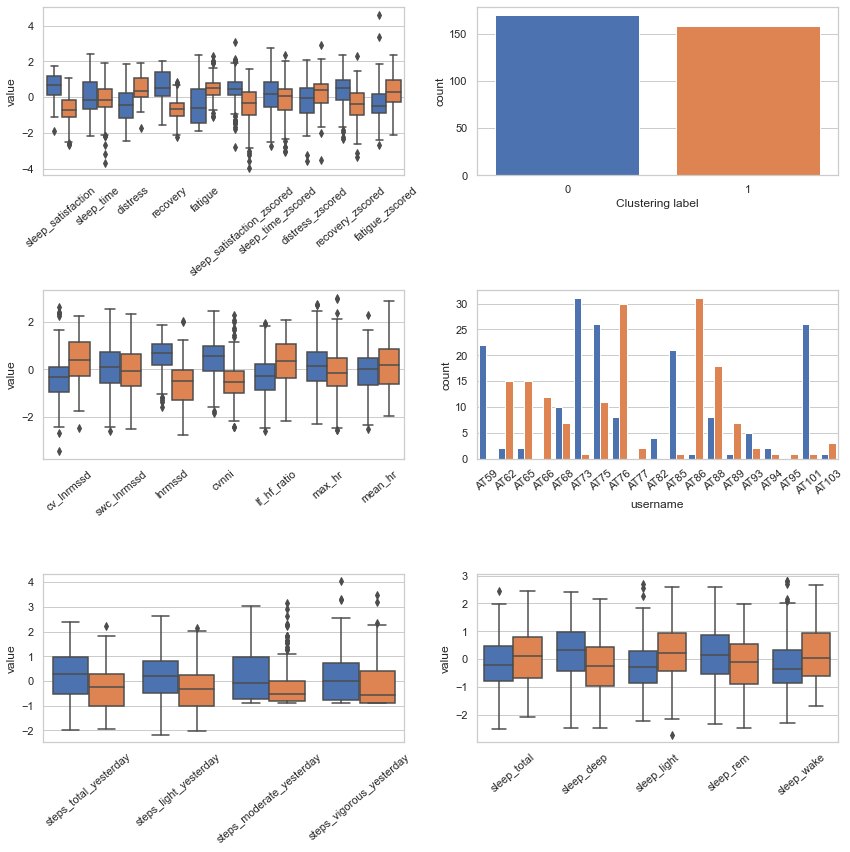

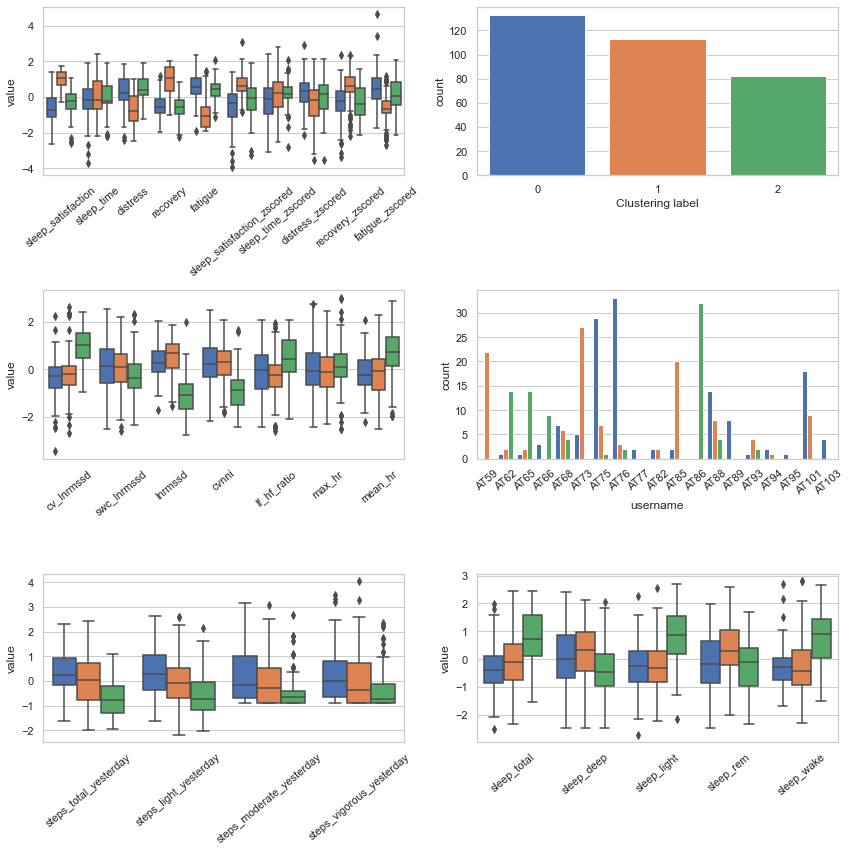

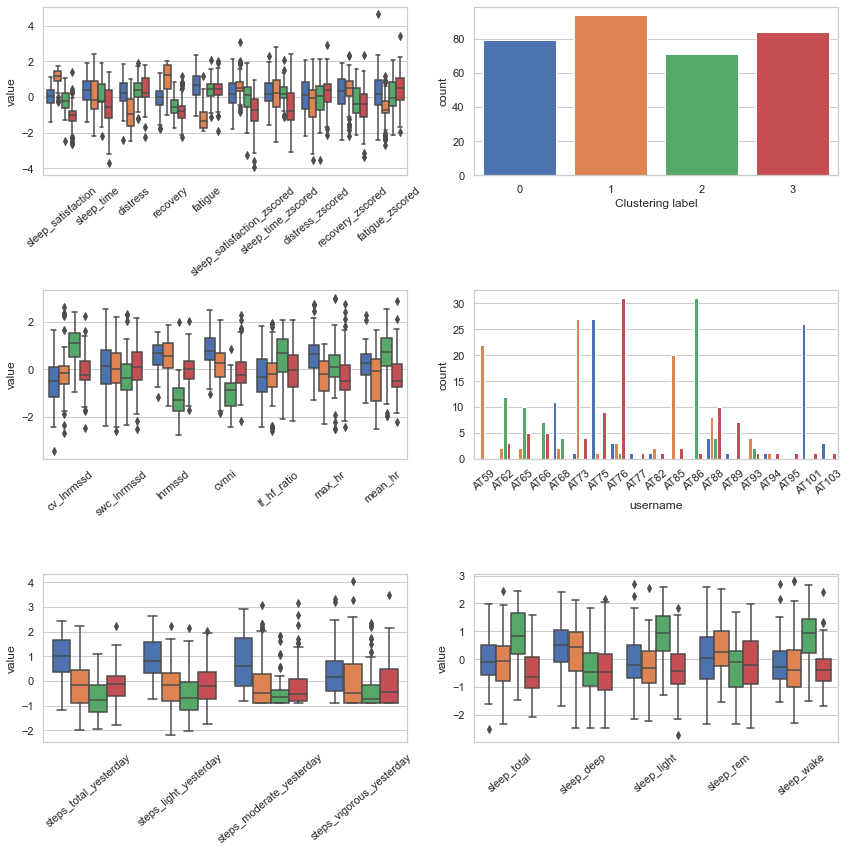

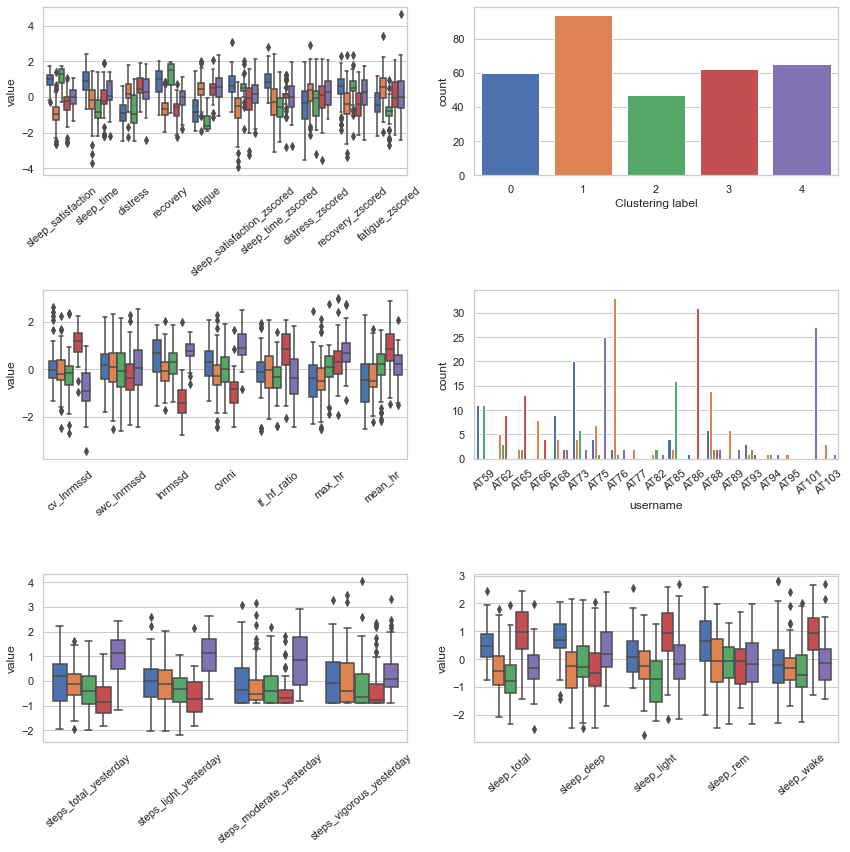

In [77]:
# Filter data
df = daily_records.loc[condition, columns]

# Standardization (zero mean and unit variance)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df.drop('username', axis=1).values)
df_standardized = scaler.transform(df.drop('username', axis=1).values)

df_standardized = pd.DataFrame(df_standardized, columns=df.columns.values[1:])
df_standardized['username'] = df['username'].values
df_plot = df_standardized.copy()

## K-means
from sklearn.cluster import KMeans
df_silhouette = pd.DataFrame() # prepare for metrics

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))

    # Assign new label to dataset
    df_plot['label'] = kmeans.labels_

    # First plot
    id_vars = ['label', 'username']
    variables = columns_questions+columns_questions_zscored
    df_cluster = df_plot.melt(id_vars=id_vars).dropna()
    condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
    df_cluster = df_cluster[condition_cluster]

    fig, axes = plt.subplots(3,2,  figsize=(12,12)) #gridspec_kw={'width_ratios': [6, 4]})
    ax = axes[0,0]
    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True,
                ax=ax, saturation=1)
    ax.set_xlabel('')
    ax.get_legend().remove()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
    

    # Second plot
    id_vars = ['label', 'username']
    variables = columns_hrv_continuous
    df_cluster = df_plot.melt(id_vars=id_vars).dropna()
    condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
    df_cluster = df_cluster[condition_cluster]

    ax = axes[1,0]
    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax, saturation=1)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
    ax.get_legend().remove()

    # Fifth plot
    id_vars = ['label', 'username']
    variables = columns_fitbit_steps
    df_cluster = df_plot.melt(id_vars=id_vars).dropna()
    condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
    df_cluster = df_cluster[condition_cluster]

    ax = axes[2,0]
    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax, saturation=1)
    ax.set_xlabel('')
    ax.get_legend().remove()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

    # Sixth plot
    ax = axes[2,1]
    id_vars = ['label', 'username']
    variables = columns_fitbit_sleep
    df_cluster = df_plot.melt(id_vars=id_vars).dropna()
    condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
    df_cluster = df_cluster[condition_cluster]

    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax, saturation=1)
    ax.set_xlabel('')
    ax.get_legend().remove()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)


    # Third plot
    df_cluster = df_plot
    ax = axes[0,1]
    sns.countplot(x='label', data=df_cluster,
                  saturation=1, ax=ax)
    ax.set_xlabel('Clustering label')

    # Fourth plot
    ax = axes[1,1]
    sns.countplot(x='username', hue='label', data=df_cluster,
                  saturation=1, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
    ax.get_legend().remove()

    fig.tight_layout()
    fig.savefig('viz/clustering-c01-'+str(n_clusters)+'.pdf', bbox_inches='tight')

    ## Model Performance
    from sklearn.metrics import silhouette_score
    silh = silhouette_score(df_standardized.drop('username', axis=1), 
                            kmeans.labels_, metric='euclidean')
    df_silhouette.loc[n_clusters, 'silhouette'] = silh

df_silhouette.index.name='n_clusters'
df_silhouette = df_silhouette.reset_index()
df_silhouette.to_latex('tab/silhouette-c01.tex', index=False)
df_silhouette

##### Wellness and HRV (C02)

In [78]:
# These are the preselected columns looking at correlations
preselected_columns = daily_records.drop(columns_correlation_removed, axis=1).columns
preselected_columns

Index(['session_number', 'training_borg', 'swc_lnrmssd_ok', 'lnrmssd',
       'swc_lnrmssd', 'cv_lnrmssd', 'cvnni', 'lf_hf_ratio', 'max_hr',
       'mean_hr', 'sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue', 'sleep_deep', 'sleep_light', 'sleep_rem', 'sleep_wake',
       'sleep_total', 'steps_light_yesterday', 'steps_moderate_yesterday',
       'steps_total_yesterday', 'steps_vigorous_yesterday',
       'sleep_satisfaction_zscored', 'sleep_time_zscored', 'distress_zscored',
       'recovery_zscored', 'fatigue_zscored'],
      dtype='object')

In [79]:
columns_basic = ['username']

columns_training = ['session_number', 'training_borg']

columns_hrv_categorical = ['swc_lnrmssd_ok'] # 'cv_lnrmssd_ok' removed
columns_hrv_continuous = ['cv_lnrmssd',  'swc_lnrmssd', 'lnrmssd', 'cvnni', 
       'lf_hf_ratio', 'max_hr', 'mean_hr']

columns_questions = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue']
columns_questions_zscored = [name + '_zscored' for name in columns_questions]

columns_fitbit_steps = ['steps_total_yesterday', 'steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_sleep = ['sleep_total', 'sleep_deep', 'sleep_light', 'sleep_rem',
       'sleep_wake']

In [80]:
# Prepare filters
condition_hrv = daily_records['cv_lnrmssd'].notna()
condition = condition_hrv 

print('Total sample:')
n_samples = sum(condition)
print(n_samples)

# Select columns
columns = columns_basic + columns_hrv_continuous + columns_questions + \
    columns_questions_zscored

Total sample:
681


n_clusters  silhouette
0           2    0.155735
1           3    0.136509
2           4    0.130735
3           5    0.114407

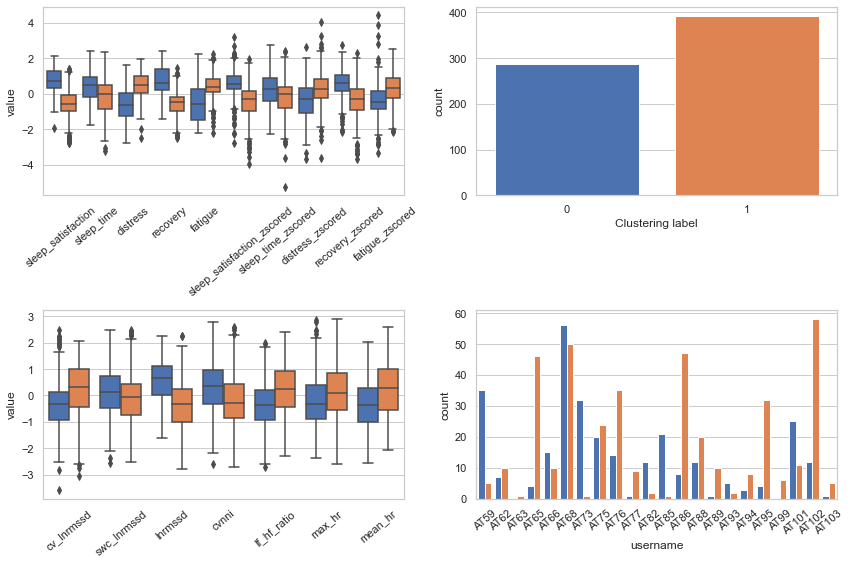

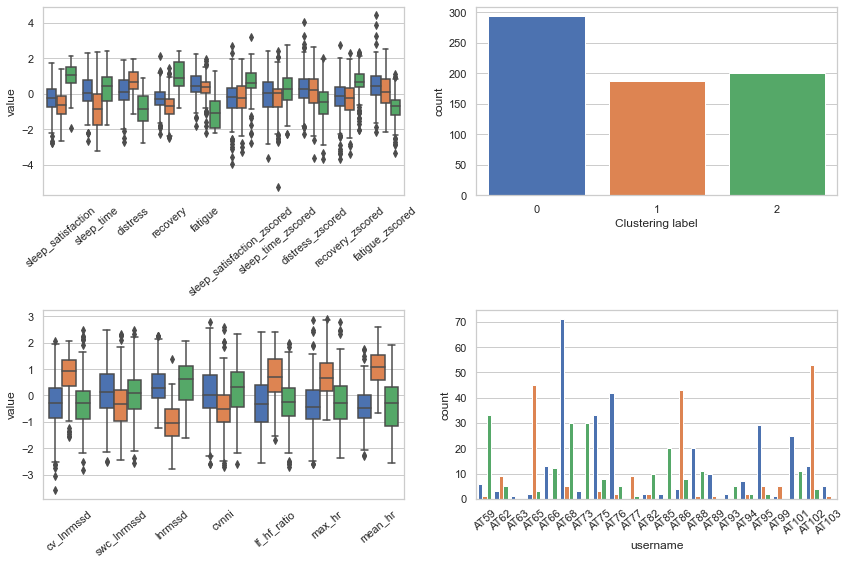

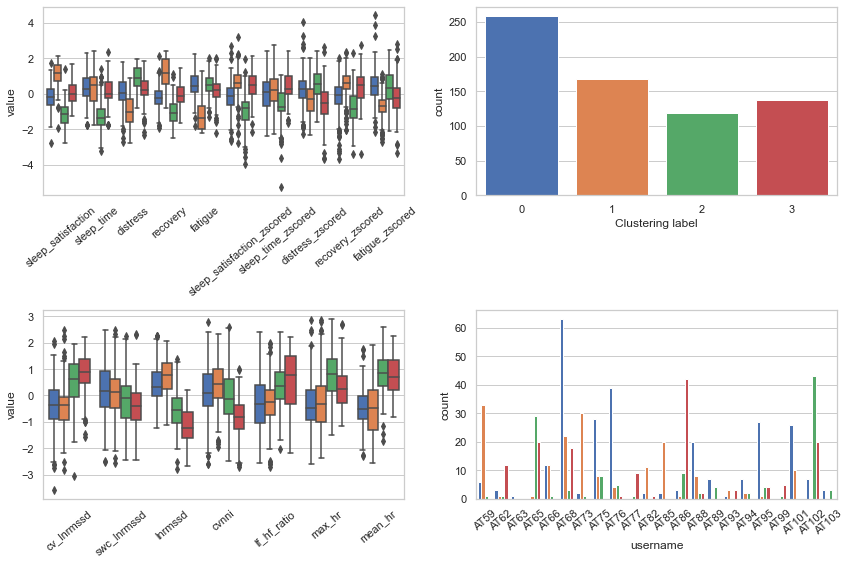

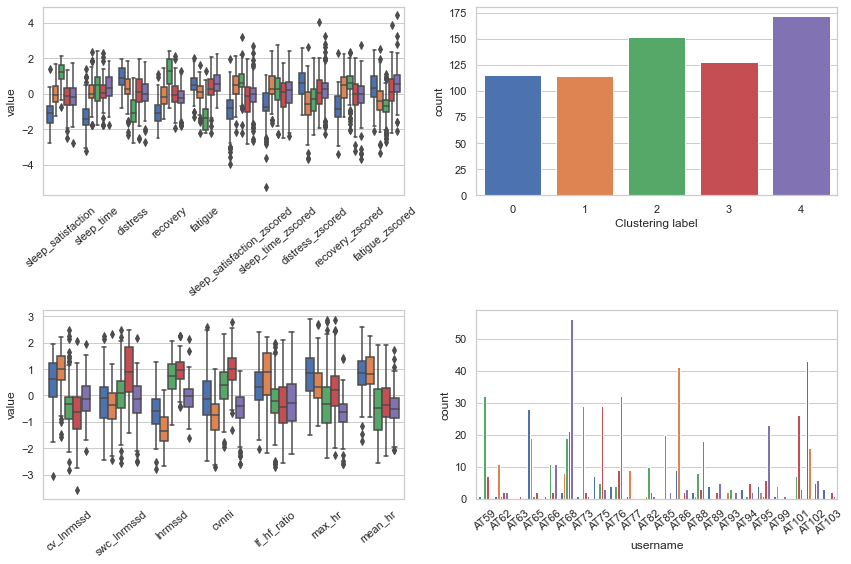

In [81]:
# Filter data
df = daily_records.loc[condition, columns]

# Standardization (zero mean and unit variance)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df.drop('username', axis=1).values)
df_standardized = scaler.transform(df.drop('username', axis=1).values)

df_standardized = pd.DataFrame(df_standardized, columns=df.columns.values[1:])
df_standardized['username'] = df['username'].values
df_plot = df_standardized.copy()

## K-means
from sklearn.cluster import KMeans
df_silhouette = pd.DataFrame() # prepare for metrics

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))

    # Assign new label to dataset
    df_plot['label'] = kmeans.labels_

    # First plot
    id_vars = ['label', 'username']
    variables = columns_questions+columns_questions_zscored
    df_cluster = df_plot.melt(id_vars=id_vars).dropna()
    condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
    df_cluster = df_cluster[condition_cluster]

    fig, axes = plt.subplots(2,2,  figsize=(12,8)) #gridspec_kw={'width_ratios': [6, 4]})
    ax = axes[0,0]
    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True,
                ax=ax, saturation=1)
    ax.set_xlabel('')
    ax.get_legend().remove()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
    

    # Second plot
    id_vars = ['label', 'username']
    variables = columns_hrv_continuous
    df_cluster = df_plot.melt(id_vars=id_vars).dropna()
    condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
    df_cluster = df_cluster[condition_cluster]

    ax = axes[1,0]
    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax, saturation=1)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
    ax.get_legend().remove()

    # # Fifth plot
    # id_vars = ['label', 'username']
    # variables = columns_fitbit_steps
    # df_cluster = df_plot.melt(id_vars=id_vars).dropna()
    # condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
    # df_cluster = df_cluster[condition_cluster]

    # ax = axes[2,0]
    # sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
    #             #showmeans=True, 
    #             ax=ax, saturation=1)
    # ax.set_xlabel('')
    # ax.get_legend().remove()
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

    # # Sixth plot
    # ax = axes[2,1]
    # id_vars = ['label', 'username']
    # variables = columns_fitbit_sleep
    # df_cluster = df_plot.melt(id_vars=id_vars).dropna()
    # condition_cluster = df_cluster['variable'].map(lambda v: v in variables)
    # df_cluster = df_cluster[condition_cluster]

    # sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
    #             #showmeans=True, 
    #             ax=ax, saturation=1)
    # ax.set_xlabel('')
    # ax.get_legend().remove()
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=40)


    # Third plot
    df_cluster = df_plot
    ax = axes[0,1]
    sns.countplot(x='label', data=df_cluster,
                  saturation=1, ax=ax)
    ax.set_xlabel('Clustering label')

    # Fourth plot
    ax = axes[1,1]
    sns.countplot(x='username', hue='label', data=df_cluster,
                  saturation=1, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
    ax.get_legend().remove()

    fig.tight_layout()
    fig.savefig('viz/clustering-c02-'+str(n_clusters)+'.pdf', bbox_inches='tight')

    ## Model Performance
    from sklearn.metrics import silhouette_score
    silh = silhouette_score(df_standardized.drop('username', axis=1), 
                            kmeans.labels_, metric='euclidean')
    df_silhouette.loc[n_clusters, 'silhouette'] = silh

df_silhouette.index.name='n_clusters'
df_silhouette = df_silhouette.reset_index()
df_silhouette.to_latex('tab/silhouette-c02.tex', index=False)
df_silhouette

###### Feature Importance

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Random forests models
clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                            max_depth=5, min_samples_leaf=5, 
                            min_samples_split=10, max_features='auto',
                            bootstrap=True,oob_score=True,
                            random_state=42,
                            class_weight='balanced'
                            )

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.8696235974994879


In [83]:
fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = e.feature_importances_
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-c02-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                              \
                                              CV1    CV2    CV3    CV4    CV5   
cv_lnrmssd                                   4.72   6.98   3.31   5.58   6.25   
swc_lnrmssd                                  0.84   1.05   0.90   0.91   0.79   
lnrmssd                                     13.03  12.76  11.13  13.95  14.34   
cvnni                                        1.39   1.03   0.81   1.21   1.45   
lf_hf_ratio                                  2.41   1.60   2.28   2.24   1.92   
max_hr                                       4.73   4.59   5.72   2.98   4.40   
mean_hr                                     15.48  13.66  13.83  16.58  13.87   
sleep_satisfaction                          10.59   7.31   7.49   9.61   9.82   
sleep_time                                   2.56   2.32   3.20   2.54   2.45   
distress                                     7.93   8.18   8.32   6.50   8.10   
recovery                                    12.96  14.72  11.58  12.81  12.40   
fatigue                                     10.39  15.13  13.97  11.31  12.99   
sleep_satisfaction_zscored                   2.56   2.77   3.01   2.36   2.73   
sleep_time_zscored                           0.62   0.75   0.39   0.79   0.48   
distress_zscored                             1.11   0.96   1.54   1.46   1.16   
recovery_zscored                             1.90   2.34   2.13   2.94   1.24   
fatigue_zscored                              6.77   3.86  10.39   6.24   5.64   

                                   
                             Mean  
cv_lnrmssd                   5.37  
swc_lnrmssd                  0.90  
lnrmssd                     13.04  
cvnni                        1.18  
lf_hf_ratio                  2.09  
max_hr                       4.48  
mean_hr                     14.68  
sleep_satisfaction           8.96  
sleep_time                   2.61  
distress                     7.81  
recovery                    12.89  
fatigue                     12.76  
sleep_satisfaction_zscored   2.68  
sleep_time_zscored           0.60  
distress_zscored             1.25  
recovery_zscored             2.11  
fatigue_zscored              6.58

### Layered K-Means clustering

#### HRV Only (L01)
The following points address the conclusion of each analysis:

1. All variables: Parameters like mean and maximum HR are difficult to change in an intervention of some weeks. They are going to hardly tell us which in which state is the patient it, therefore, they should be removed.
2. Max and mean hr removed: lnrmssd and cvnni represent the same dimension of change in rr intervals and they are highly correlated (0.7). It may be interesting to diversify the feature importance for both. Either that, or give full support to lnrmssd by removing cvnni.
3. Clearest and most separated clusters here.

##### All HRV variables (L01A)

In [84]:
columns_basic = ['username']

columns_training = ['session_number', 'training_borg']

columns_hrv_categorical = ['swc_lnrmssd_ok'] # 'cv_lnrmssd_ok' removed
columns_hrv_continuous = ['cv_lnrmssd',  'swc_lnrmssd', 'lnrmssd', 'cvnni', 
       'lf_hf_ratio', 'max_hr', 'mean_hr']

columns_questions = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue']
columns_questions_zscored = [name + '_zscored' for name in columns_questions]

columns_fitbit_steps = ['steps_total_yesterday', 'steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_sleep = ['sleep_total', 'sleep_deep', 'sleep_light', 'sleep_rem',
       'sleep_wake']

In [85]:
# Prepare filters
condition_hrv = daily_records['cv_lnrmssd'].notna()
# condition_fitbit_steps = daily_records['steps_total_yesterday'].notna()
# condition_fitbit_sleep = daily_records['sleep_total'].notna()

condition = condition_hrv # & condition_fitbit_sleep & condition_fitbit_steps

print('Total sample:')
n_samples = sum(condition)
print(n_samples)

# Select columns
columns = columns_basic + columns_hrv_continuous #+ columns_questions + \
    # columns_fitbit_steps + columns_fitbit_sleep

Total sample:
681


n_clusters  silhouette
0           2    0.252863
1           3    0.212174
2           4    0.187604
3           5    0.177786

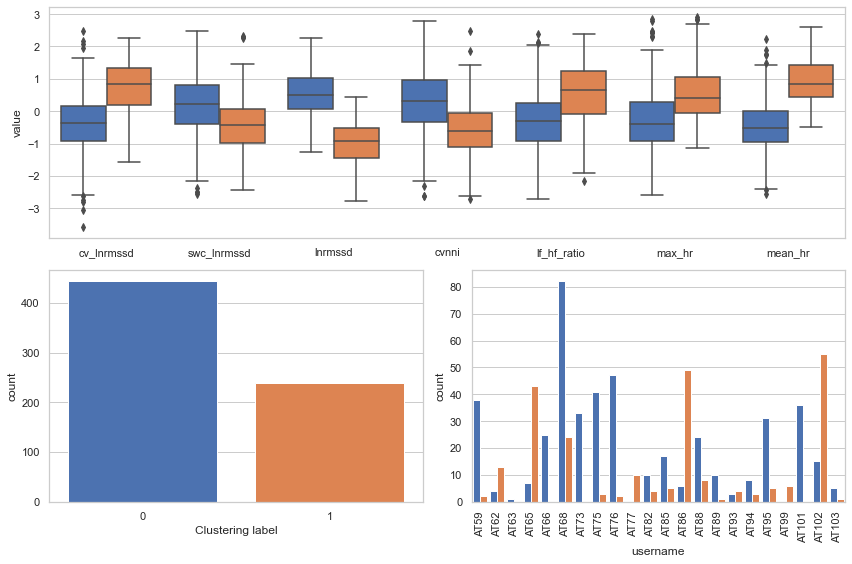

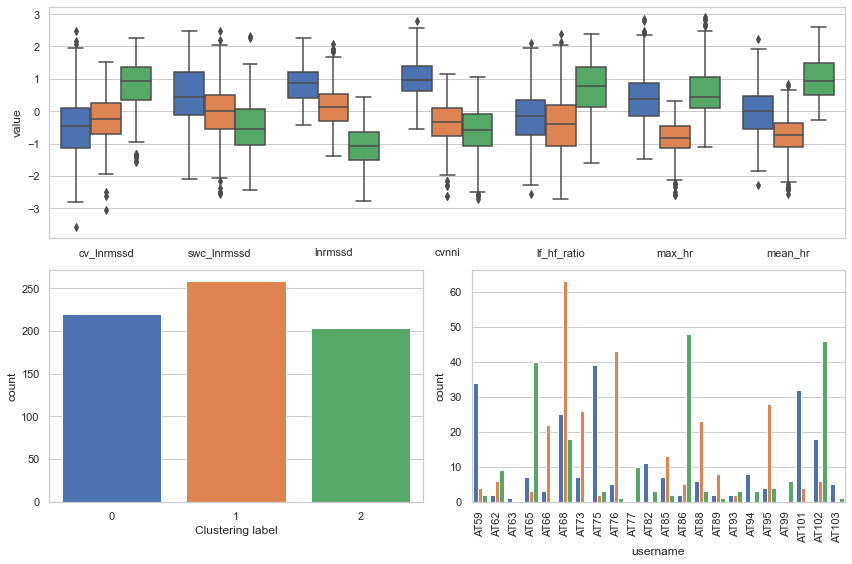

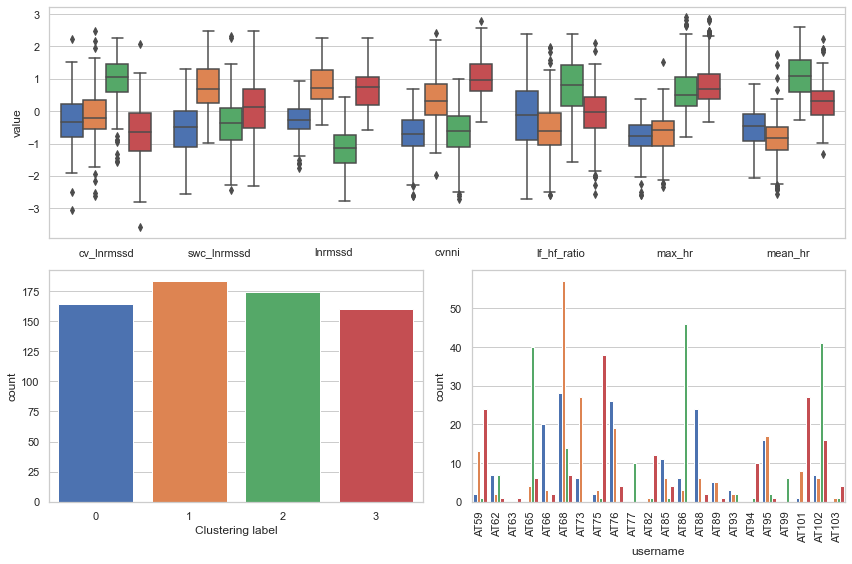

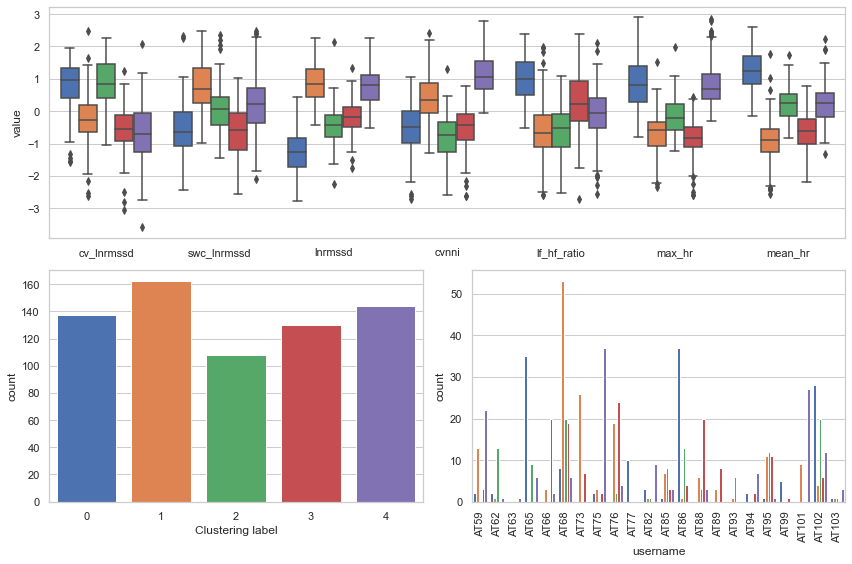

In [86]:
import matplotlib.gridspec as gridspec

## Filter data
df = daily_records.loc[condition, columns]

# Standardization (zero mean and unit variance)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df.drop('username', axis=1).values)
df_standardized = scaler.transform(df.drop('username', axis=1).values)

df_standardized = pd.DataFrame(df_standardized, columns=df.columns.values[1:])
df_standardized['username'] = df['username'].values
df_plot = df_standardized.copy()

df_silhouette = pd.DataFrame()

## K-means
from sklearn.cluster import KMeans

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))

    # Assign new label to dataset
    df_plot['label'] = kmeans.labels_

    if n_clusters == 4:
        labels_hrv_all = kmeans.labels_

    # Create 2x2 sub plots
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(12,8)) #gridspec_kw={'width_ratios': [6, 4]})
    ax1 = fig.add_subplot(gs[0, :]) # row 0, col 0
    ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
    ax3 = fig.add_subplot(gs[1, 1]) # row 1, span all columns
    

    # Main plot
    id_vars = ['label', 'username']
    variables = columns_hrv_continuous
    df_cluster = df_plot.melt(id_vars=id_vars, value_vars=variables).dropna()

    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax1, saturation=1)
    ax1.get_legend().remove()
    ax1.set_xlabel('')

    # Label count plot
    df_cluster = df_plot
    sns.countplot(x='label', data=df_cluster,
                  saturation=1, ax=ax2)
    ax2.set_xlabel('Clustering label')

    # Label count by patient plot
    sns.countplot(x='username', hue='label', data=df_cluster,
                  saturation=1, ax=ax3)
    ax3.tick_params('x', rotation=90)
    ax3.get_legend().remove()

    fig.tight_layout()
    fig.savefig('viz/clustering-l01a-'+str(n_clusters)+'.pdf', bbox_inches='tight')

    ## Model Performance
    from sklearn.metrics import silhouette_score
    silh = silhouette_score(df_standardized.drop('username', axis=1), kmeans.labels_, metric='euclidean')
    df_silhouette.loc[n_clusters, 'silhouette'] = silh

df_silhouette.index.name='n_clusters'
df_silhouette = df_silhouette.reset_index()
df_silhouette.to_latex('tab/silhouette-l01a.tex', index=False)
df_silhouette

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Random forests models
clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                            max_depth=5, min_samples_leaf=5, 
                            min_samples_split=10, max_features='auto',
                            bootstrap=True,oob_score=True,
                            random_state=42,
                            class_weight='balanced'
                            )

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.8762781087141753


In [88]:
# Feature importance

fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = e.feature_importances_
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-l01a-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                                   
                               CV1    CV2    CV3    CV4    CV5   Mean
cv_lnrmssd                    9.43  10.41   7.64   6.78  11.59   9.17
swc_lnrmssd                   9.36   6.45   9.96   9.42   6.92   8.42
lnrmssd                      24.72  24.40  21.38  24.85  24.22  23.91
cvnni                        15.21  16.17  16.44  15.62  13.88  15.46
lf_hf_ratio                   3.08   3.76   3.58   4.26   3.91   3.72
max_hr                       22.53  23.69  24.90  24.72  25.54  24.28
mean_hr                      15.67  15.12  16.10  14.34  13.95  15.04

In [89]:
# Value ranges
df_description = df.reset_index(drop=True).copy()
df_description['label'] = df_plot['label']

# Transform variables
columns_to_transform = ['cv_lnrmssd', 'cvnni', 'lf_hf_ratio']
df_description[columns_to_transform] = df_description[columns_to_transform].apply(np.exp)
df_description['cvnni'] = df_description['cvnni']*100
df_description = df_description.rename({'cvnni':'cvnni (x100)'}, axis=1)

#  Describe the clusters by variable
if 'level_0' in df_description.columns:
    df_description = df_description.drop(['level_0'], axis=1)
if 'index' in df_description.columns:
    df_description = df_description.drop(['index'], axis=1)

df_description = df_description.groupby('label').describe().round(2).T
df_description.to_latex('tab/cd-l01a-'+str(n_clusters)+'.tex') # cluster description
df_description

label                    0       1       2       3
cv_lnrmssd   count  164.00  183.00  174.00  160.00
             mean     6.73    7.50   13.19    5.73
             std      3.27    3.91    4.60    3.02
             min      1.26    1.63    2.96    0.94
             25%      4.58    5.24   10.03    3.55
             50%      5.92    6.32   12.91    4.99
             75%      8.10    8.76   16.33    6.93
             max     25.07   28.92   25.74   23.09
swc_lnrmssd  count  164.00  183.00  174.00  160.00
             mean    -0.74    1.12   -0.54    0.21
             std      1.11    1.09    1.15    1.34
             min     -3.49   -1.35   -3.36   -3.18
             25%     -1.49    0.37   -1.21   -0.69
             50%     -0.63    0.98   -0.49    0.22
             75%      0.04    1.83    0.16    0.99
             max      1.85    3.47    3.27    3.48
lnrmssd      count  164.00  183.00  174.00  160.00
             mean     3.29    3.98    2.73    3.88
             std      0.32    0.39    0.40    0.35
             min      2.37    3.21    1.74    3.11
             25%      3.13    3.72    2.48    3.59
             50%      3.30    3.92    2.77    3.94
             75%      3.51    4.27    3.01    4.14
             max      4.05    4.89    3.76    4.88
cvnni (x100) count  164.00  183.00  174.00  160.00
             mean     4.36    7.05    4.58    9.47
             std      1.22    2.27    1.42    2.83
             min      1.85    2.45    1.76    5.00
             25%      3.61    5.46    3.57    7.53
             50%      4.26    6.58    4.45    8.82
             75%      5.14    8.35    5.42   10.95
             max      7.80   16.51    8.90   19.29
lf_hf_ratio  count  164.00  183.00  174.00  160.00
             mean     2.97    1.96    5.03    2.66
             std      2.60    1.65    3.08    1.75
             min      0.28    0.31    0.70    0.32
             25%      1.19    1.03    2.66    1.58
             50%      2.13    1.46    4.41    2.30
             75%      3.77    2.25    7.07    3.25
             max     15.03   10.99   15.06   12.16
max_hr       count  164.00  183.00  174.00  160.00
             mean    71.63   72.61   88.32   90.12
             std      6.17    6.84    8.78    7.86
             min     51.24   53.81   71.60   76.82
             25%     68.42   68.42   82.33   84.71
             50%     71.64   74.07   86.27   88.31
             75%     75.81   76.97   92.59   93.64
             max     84.63   97.72  113.42  112.78
mean_hr      count  164.00  183.00  174.00  160.00
             mean    62.37   59.16   76.30   69.17
             std      5.77    6.30    5.69    5.39
             min     48.54   43.94   64.21   55.05
             25%     58.65   56.09   71.95   65.70
             50%     62.73   59.29   76.26   69.47
             75%     65.88   62.42   80.63   72.07
             max     74.23   82.23   89.63   86.47

##### Remove max and mean HR (L01B)

In [90]:
columns_basic = ['username']

columns_training = ['session_number', 'training_borg']

columns_hrv_categorical = ['swc_lnrmssd_ok'] # 'cv_lnrmssd_ok' removed
columns_hrv_continuous = ['cv_lnrmssd',  'swc_lnrmssd', 'lnrmssd', 'cvnni', 
       'lf_hf_ratio'] # 'max_hr', 'mean_hr' removed

columns_questions = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue']
columns_questions_zscored = [name + '_zscored' for name in columns_questions]

columns_fitbit_steps = ['steps_total_yesterday', 'steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_sleep = ['sleep_total', 'sleep_deep', 'sleep_light', 'sleep_rem',
       'sleep_wake']

In [91]:
# Prepare filters
condition_hrv = daily_records['cv_lnrmssd'].notna()
# condition_fitbit_steps = daily_records['steps_total_yesterday'].notna()
# condition_fitbit_sleep = daily_records['sleep_total'].notna()

condition = condition_hrv # & condition_fitbit_sleep & condition_fitbit_steps

print('Total sample:')
n_samples = sum(condition)
print(n_samples)

# Select columns
columns = columns_basic + columns_hrv_continuous #+ columns_questions + \
    # columns_fitbit_steps + columns_fitbit_sleep

Total sample:
681


n_clusters  silhouette
0           2    0.273946
1           3    0.204155
2           4    0.199767
3           5    0.196936

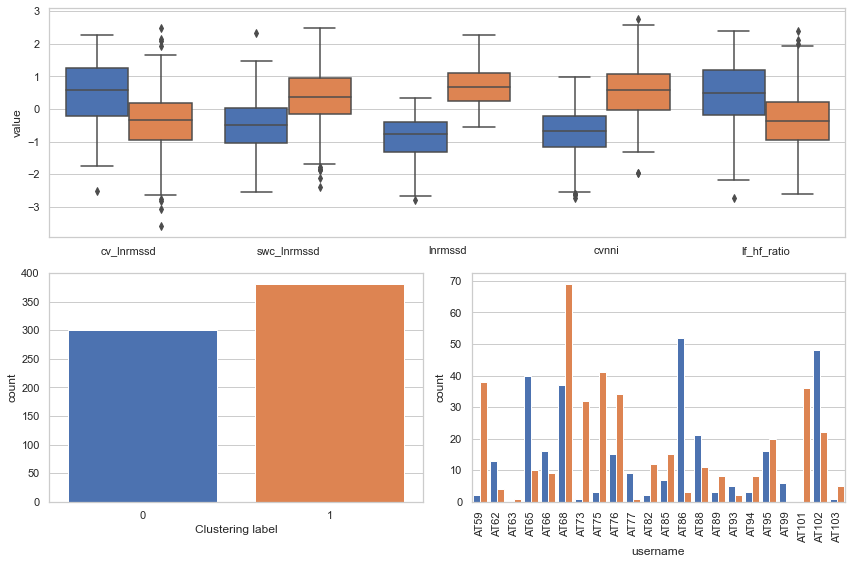

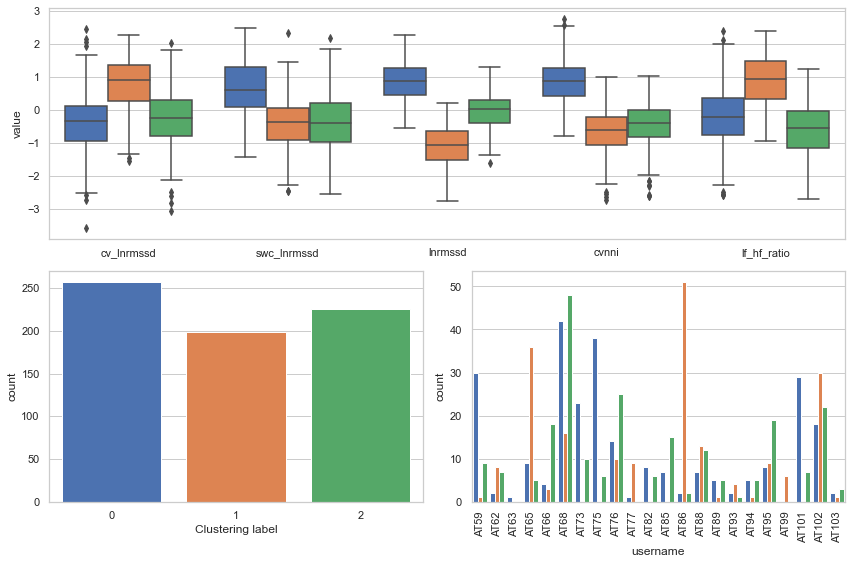

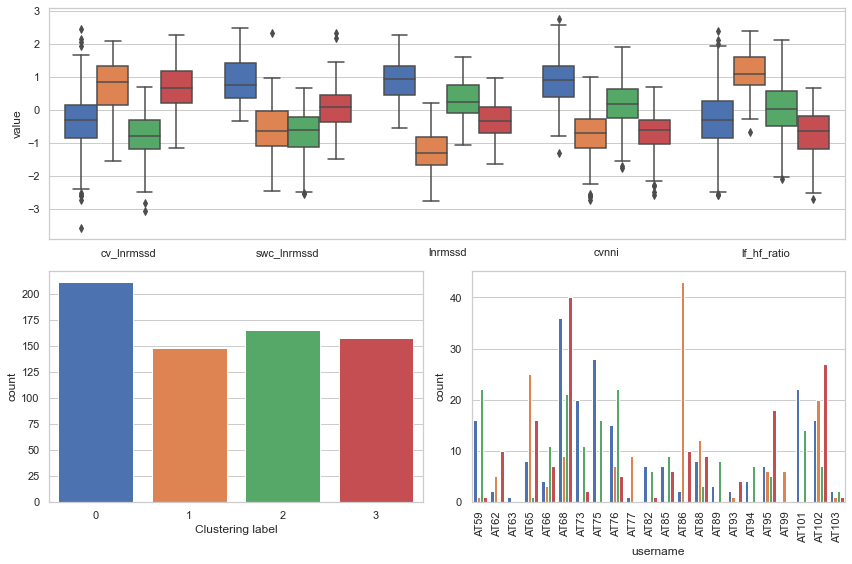

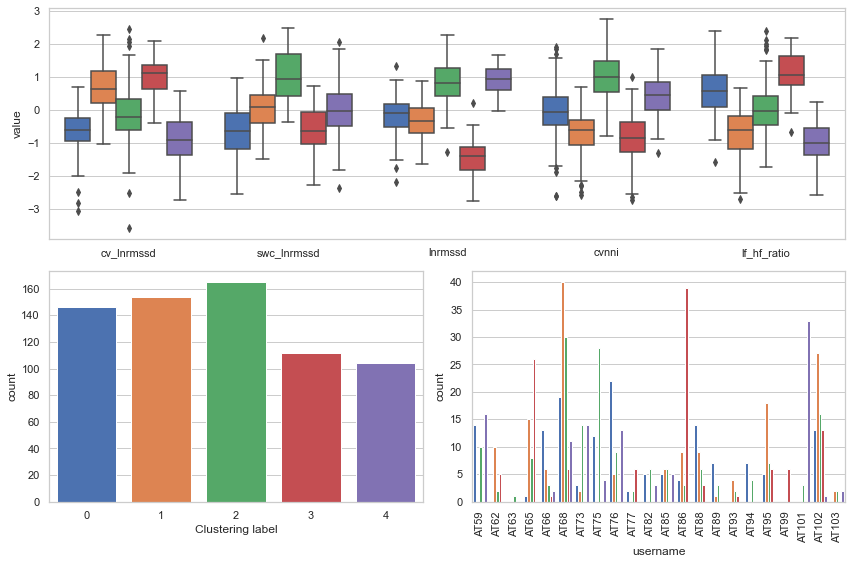

In [92]:
import matplotlib.gridspec as gridspec

## Filter data
df = daily_records.loc[condition, columns]

# Standardization (zero mean and unit variance)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df.drop('username', axis=1).values)
df_standardized = scaler.transform(df.drop('username', axis=1).values)

df_standardized = pd.DataFrame(df_standardized, columns=df.columns.values[1:])
df_standardized['username'] = df['username'].values
df_plot = df_standardized.copy()

df_silhouette = pd.DataFrame()

## K-means
from sklearn.cluster import KMeans

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))

    # Assign new label to dataset
    df_plot['label'] = kmeans.labels_

    if n_clusters == 4:
        labels_hrv_all = kmeans.labels_

    # Create 2x2 sub plots
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(12,8)) #gridspec_kw={'width_ratios': [6, 4]})
    ax1 = fig.add_subplot(gs[0, :]) # row 0, col 0
    ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
    ax3 = fig.add_subplot(gs[1, 1]) # row 1, span all columns
    

    # Main plot
    id_vars = ['label', 'username']
    variables = columns_hrv_continuous
    df_cluster = df_plot.melt(id_vars=id_vars, value_vars=variables).dropna()

    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax1, saturation=1)
    ax1.get_legend().remove()
    ax1.set_xlabel('')

    # Label count plot
    df_cluster = df_plot
    sns.countplot(x='label', data=df_cluster,
                  saturation=1, ax=ax2)
    ax2.set_xlabel('Clustering label')

    # Label count by patient plot
    sns.countplot(x='username', hue='label', data=df_cluster,
                  saturation=1, ax=ax3)
    ax3.tick_params('x', rotation=90)
    ax3.get_legend().remove()

    fig.tight_layout()
    fig.savefig('viz/clustering-l01b-'+str(n_clusters)+'.pdf', bbox_inches='tight')

    ## Model Performance
    from sklearn.metrics import silhouette_score
    silh = silhouette_score(df_standardized.drop('username', axis=1), kmeans.labels_, metric='euclidean')
    df_silhouette.loc[n_clusters, 'silhouette'] = silh

df_silhouette.index.name='n_clusters'
df_silhouette = df_silhouette.reset_index()
df_silhouette.to_latex('tab/silhouette-l01b.tex', index=False)
df_silhouette

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Random forests models
clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                            max_depth=5, min_samples_leaf=5, 
                            min_samples_split=10, max_features='auto',
                            bootstrap=True,oob_score=True,
                            random_state=42,
                            class_weight='balanced'
                            )

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.8892157210263758


In [94]:
# Feature importance

fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = e.feature_importances_
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-l01b-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                                   
                               CV1    CV2    CV3    CV4    CV5   Mean
cv_lnrmssd                   14.51  16.32  15.12  14.17  13.43  14.71
swc_lnrmssd                  22.62  21.43  24.11  20.77  22.19  22.22
lnrmssd                      24.01  26.85  23.68  26.07  25.15  25.15
cvnni                        19.48  15.91  17.75  19.99  20.52  18.73
lf_hf_ratio                  19.38  19.49  19.35  19.00  18.71  19.19

In [95]:
# Value ranges
df_description = df.reset_index(drop=True).copy()
df_description['label'] = df_plot['label']

# Transform variables
columns_to_transform = ['cv_lnrmssd', 'cvnni', 'lf_hf_ratio']
df_description[columns_to_transform] = df_description[columns_to_transform].apply(np.exp)
df_description['cvnni'] = df_description['cvnni']*100
df_description = df_description.rename({'cvnni':'cvnni (x100)'}, axis=1)

#  Describe the clusters by variable
if 'level_0' in df_description.columns:
    df_description = df_description.drop(['level_0'], axis=1)
if 'index' in df_description.columns:
    df_description = df_description.drop(['index'], axis=1)

df_description = df_description.groupby('label').describe().round(2).T
df_description.to_latex('tab/cd-l01b-'+str(n_clusters)+'.tex') # cluster description
df_description

label                    0       1       2       3
cv_lnrmssd   count  211.00  148.00  165.00  157.00
             mean     6.66   11.42    4.89   11.38
             std      3.78    4.65    1.69    4.61
             min      0.94    2.96    1.26    3.75
             25%      4.39    7.81    3.63    8.03
             50%      5.98   11.55    4.58   10.34
             75%      7.82   15.09    6.03   14.03
             max     28.92   23.42   10.62   25.74
swc_lnrmssd  count  211.00  148.00  165.00  157.00
             mean     1.31   -0.80   -0.98    0.17
             std      1.02    1.13    0.96    0.92
             min     -0.44   -3.36   -3.49   -2.02
             25%      0.52   -1.48   -1.54   -0.47
             50%      1.08   -0.85   -0.82    0.16
             75%      2.03   -0.00   -0.28    0.67
             max      3.48    3.27    0.96    3.29
lnrmssd      count  211.00  148.00  165.00  157.00
             mean     4.04    2.66    3.65    3.29
             std      0.38    0.40    0.33    0.34
             min      3.13    1.74    2.80    2.45
             25%      3.76    2.42    3.42    3.04
             50%      4.07    2.67    3.62    3.27
             75%      4.32    2.96    3.94    3.52
             max      4.89    3.60    4.48    4.08
cvnni (x100) count  211.00  148.00  165.00  157.00
             mean     9.06    4.37    6.48    4.41
             std      2.93    1.40    1.92    1.21
             min      3.27    1.76    2.66    1.86
             25%      6.85    3.47    5.16    3.65
             50%      8.56    4.24    6.21    4.43
             75%     10.33    5.10    7.62    5.06
             max     19.29    8.90   13.31    7.87
lf_hf_ratio  count  211.00  148.00  165.00  157.00
             mean     2.42    6.23    2.85    1.55
             std      2.02    2.82    1.90    0.75
             min      0.31    1.40    0.46    0.28
             25%      1.21    4.21    1.60    0.94
             50%      1.84    5.44    2.39    1.43
             75%      2.91    8.23    3.65    2.04
             max     15.06   15.03   12.22    3.97

##### Remove lf_hf_ratio (L01C)

In [96]:
columns_basic = ['username']

columns_training = ['session_number', 'training_borg']

columns_hrv_categorical = ['swc_lnrmssd_ok'] # 'cv_lnrmssd_ok' removed
columns_hrv_continuous = ['cv_lnrmssd',  'swc_lnrmssd', 'lnrmssd', 'cvnni'] # 'lf_hf_ratio', 'max_hr', 'mean_hr' removed

columns_questions = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue']
columns_questions_zscored = [name + '_zscored' for name in columns_questions]

columns_fitbit_steps = ['steps_total_yesterday', 'steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_sleep = ['sleep_total', 'sleep_deep', 'sleep_light', 'sleep_rem',
       'sleep_wake']

In [97]:
# Prepare filters
condition_hrv = daily_records['cv_lnrmssd'].notna()
# condition_fitbit_steps = daily_records['steps_total_yesterday'].notna()
# condition_fitbit_sleep = daily_records['sleep_total'].notna()

condition = condition_hrv # & condition_fitbit_sleep & condition_fitbit_steps

print('Total sample:')
n_samples = sum(condition)
print(n_samples)

# Select columns
columns = columns_basic + columns_hrv_continuous #+ columns_questions + \
    # columns_fitbit_steps + columns_fitbit_sleep

Total sample:
681


n_clusters  silhouette
0           2    0.311806
1           3    0.257434
2           4    0.234708
3           5    0.238176

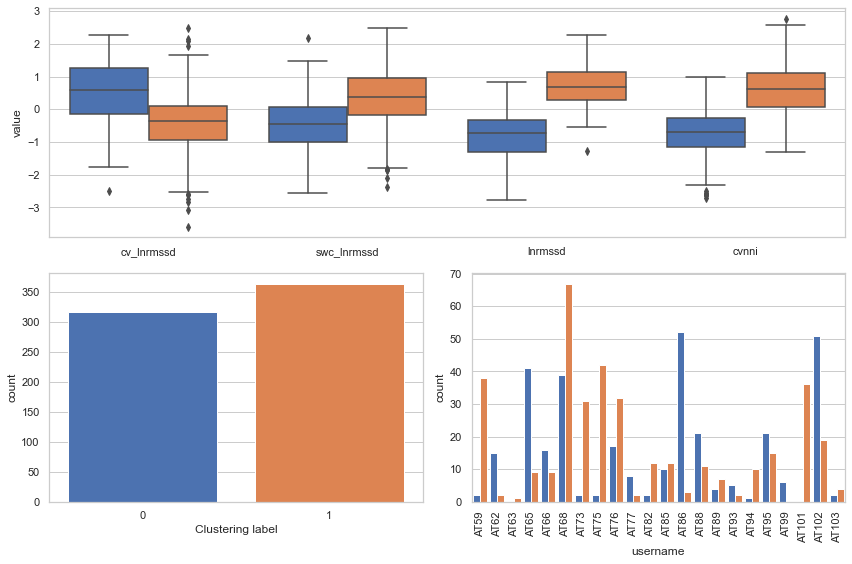

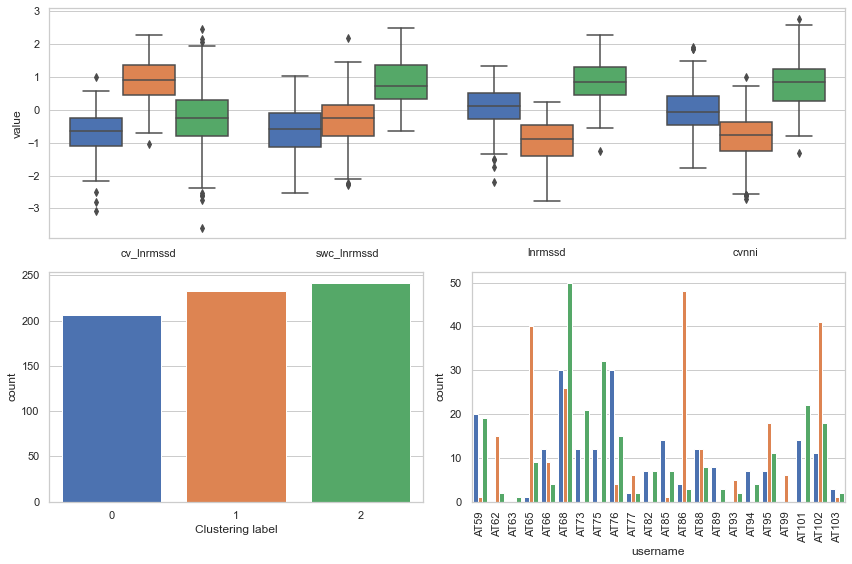

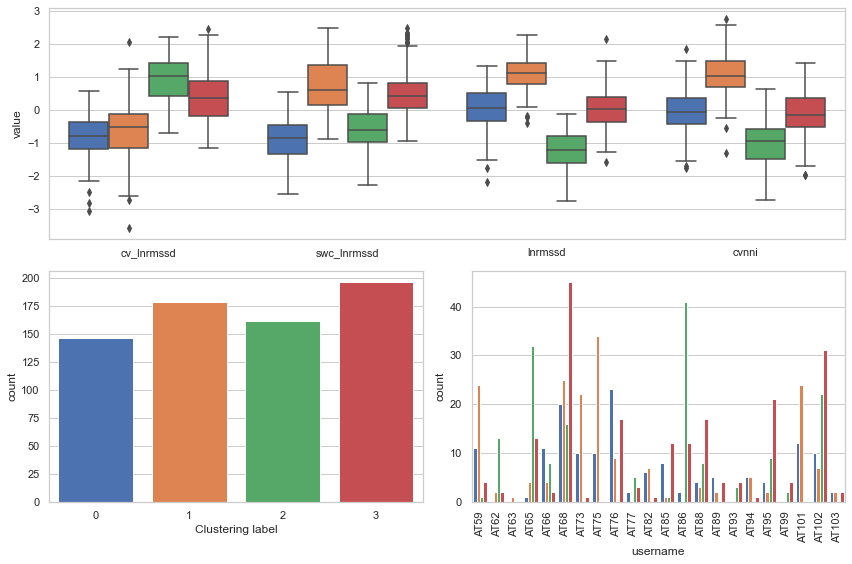

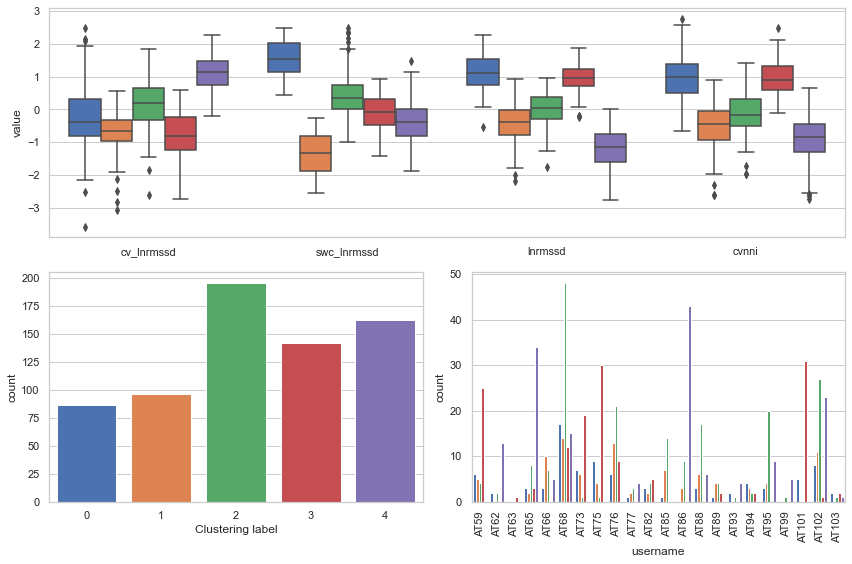

In [98]:
import matplotlib.gridspec as gridspec

## Filter data
df = daily_records.loc[condition, columns]

# Standardization (zero mean and unit variance)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df.drop('username', axis=1).values)
df_standardized = scaler.transform(df.drop('username', axis=1).values)

df_standardized = pd.DataFrame(df_standardized, columns=df.columns.values[1:])
df_standardized['username'] = df['username'].values
df_plot = df_standardized.copy()

df_silhouette = pd.DataFrame()

## K-means
from sklearn.cluster import KMeans

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))

    # Assign new label to dataset
    df_plot['label'] = kmeans.labels_

    if n_clusters == 4:
        labels_hrv_all = kmeans.labels_

    # Create 2x2 sub plots
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(12,8)) #gridspec_kw={'width_ratios': [6, 4]})
    ax1 = fig.add_subplot(gs[0, :]) # row 0, col 0
    ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
    ax3 = fig.add_subplot(gs[1, 1]) # row 1, span all columns
    

    # Main plot
    id_vars = ['label', 'username']
    variables = columns_hrv_continuous
    df_cluster = df_plot.melt(id_vars=id_vars, value_vars=variables).dropna()

    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax1, saturation=1)
    ax1.get_legend().remove()
    ax1.set_xlabel('')

    # Label count plot
    df_cluster = df_plot
    sns.countplot(x='label', data=df_cluster,
                  saturation=1, ax=ax2)
    ax2.set_xlabel('Clustering label')

    # Label count by patient plot
    sns.countplot(x='username', hue='label', data=df_cluster,
                  saturation=1, ax=ax3)
    ax3.tick_params('x', rotation=90)
    ax3.get_legend().remove()

    fig.tight_layout()
    fig.savefig('viz/clustering-l01c-'+str(n_clusters)+'.pdf', bbox_inches='tight')

    ## Model Performance
    from sklearn.metrics import silhouette_score
    silh = silhouette_score(df_standardized.drop('username', axis=1), kmeans.labels_, metric='euclidean')
    df_silhouette.loc[n_clusters, 'silhouette'] = silh

df_silhouette.index.name='n_clusters'
df_silhouette = df_silhouette.reset_index()
df_silhouette.to_latex('tab/silhouette-l01c.tex', index=False)
df_silhouette

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Save for later comparison
daily_records.loc[condition, 'label_hrv'] = kmeans.labels_


# Random forests models
clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                            max_depth=5, min_samples_leaf=5, 
                            min_samples_split=10, max_features='auto',
                            bootstrap=True,oob_score=True,
                            random_state=42,
                            class_weight='balanced'
                            )

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.8748488393312798


In [100]:
# Feature importance

fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = e.feature_importances_
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-l01c-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                                   
                               CV1    CV2    CV3    CV4    CV5   Mean
cv_lnrmssd                   19.39  23.93  22.16  21.23  19.14  21.17
swc_lnrmssd                  26.98  26.36  27.47  25.97  25.64  26.49
lnrmssd                      38.54  33.69  36.22  36.85  38.46  36.75
cvnni                        15.08  16.02  14.16  15.94  16.76  15.59

In [101]:
# Value ranges
df_description = df.reset_index(drop=True).copy()
df_description['label'] = df_plot['label']

# Transform variables
columns_to_transform = ['cv_lnrmssd', 'cvnni']
df_description[columns_to_transform] = df_description[columns_to_transform].apply(np.exp)
df_description['cvnni'] = df_description['cvnni']*100
df_description = df_description.rename({'cvnni':'cvnni (x100)'}, axis=1)

#  Describe the clusters by variable
if 'level_0' in df_description.columns:
    df_description = df_description.drop(['level_0'], axis=1)
if 'index' in df_description.columns:
    df_description = df_description.drop(['index'], axis=1)

df_description = df_description.groupby('label').describe().round(2).T
df_description.to_latex('tab/cd-l01c-'+str(n_clusters)+'.tex') # cluster description
df_description

label                    0       1       2       3
cv_lnrmssd   count  146.00  178.00  161.00  196.00
             mean     4.75    5.59   12.95    9.76
             std      1.56    2.66    4.54    4.19
             min      1.26    0.94    4.82    3.75
             25%      3.63    3.72    9.05    6.48
             50%      4.54    5.38   12.71    8.84
             75%      5.78    6.72   15.91   11.71
             max      9.94   23.09   25.07   28.92
swc_lnrmssd  count  146.00  178.00  161.00  196.00
             mean    -1.27    1.06   -0.81    0.77
             std      0.97    1.14    0.89    0.90
             min     -3.49   -1.17   -3.14   -1.29
             25%     -1.82    0.22   -1.33    0.13
             50%     -1.14    0.86   -0.82    0.60
             75%     -0.61    1.91   -0.13    1.18
             max      0.78    3.48    1.16    3.47
lnrmssd      count  146.00  178.00  161.00  196.00
             mean     3.51    4.15    2.69    3.48
             std      0.40    0.32    0.38    0.32
             min      2.10    3.22    1.74    2.49
             25%      3.26    3.97    2.46    3.25
             50%      3.52    4.18    2.71    3.49
             75%      3.79    4.36    2.98    3.73
             max      4.31    4.89    3.40    4.81
cvnni (x100) count  146.00  178.00  161.00  196.00
             mean     5.89    9.65    3.84    5.74
             std      1.71    2.85    1.14    1.63
             min      2.66    3.27    1.76    2.45
             25%      4.78    7.79    3.01    4.62
             50%      5.64    9.02    3.82    5.38
             75%      6.74   11.00    4.48    6.72
             max     12.88   19.29    7.66   10.69

#### Wellness (L02)
##### All Raw wellness variables (L02A)

In [102]:
columns_basic = ['username']

columns_training = ['session_number', 'recommendation_level', 'training_borg']

columns_hrv_categorical = ['swc_lnrmssd_ok', 'cv_lnrmssd_ok',]
columns_hrv_continuous = ['cv_lnrmssd',  'swc_lnrmssd', 'lnrmssd', 'cvnni', 
       'lf_hf_ratio', 'max_hr', 'mean_hr']

columns_questions = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue']

columns_fitbit_steps = ['steps_total_yesterday', 'steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_sleep = ['sleep_total', 'sleep_deep', 'sleep_light', 'sleep_rem',
       'sleep_wake']

In [103]:
# Prepare filters
condition_hrv = daily_records['cv_lnrmssd'].notna()
# condition_fitbit_steps = daily_records['steps_total_yesterday'].notna()
# condition_fitbit_sleep = daily_records['sleep_total'].notna()

condition = condition_hrv # & condition_fitbit_sleep & condition_fitbit_steps

print('Total sample:')
n_samples = sum(condition)
print(n_samples)

# Select columns
columns = columns_basic + columns_questions

Total sample:
681


n_clusters  silhouette
0           2    0.374903
1           3    0.271060
2           4    0.223430
3           5    0.211223

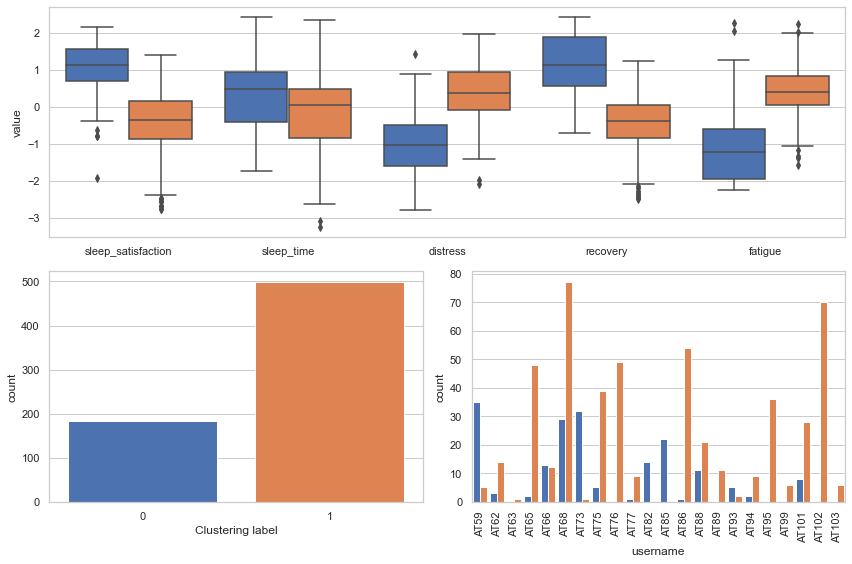

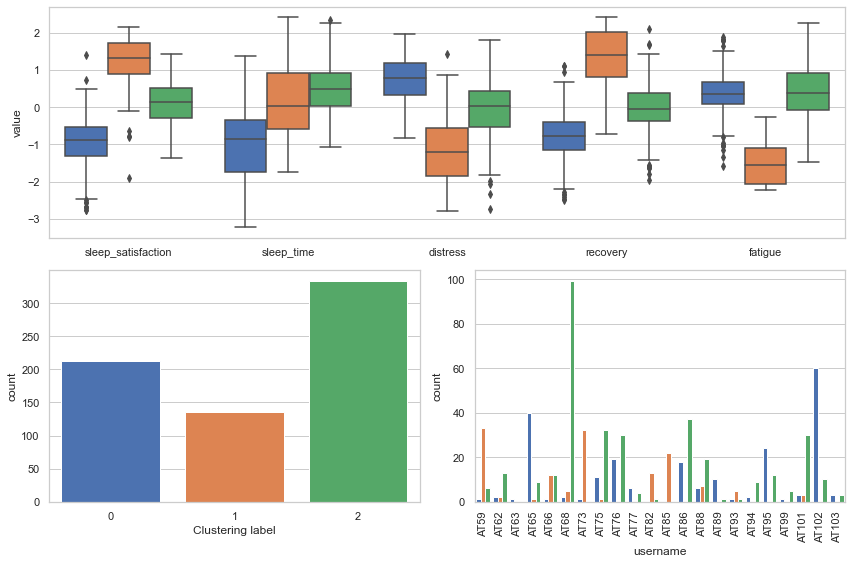

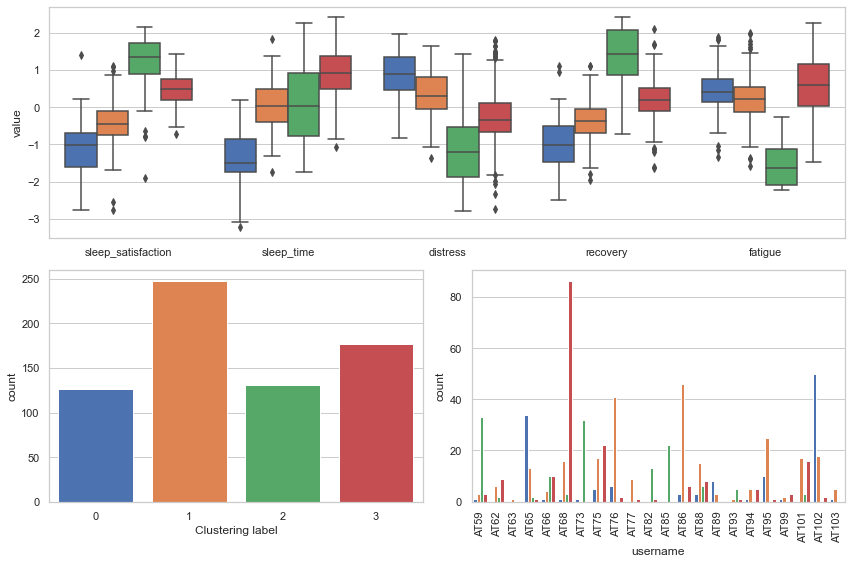

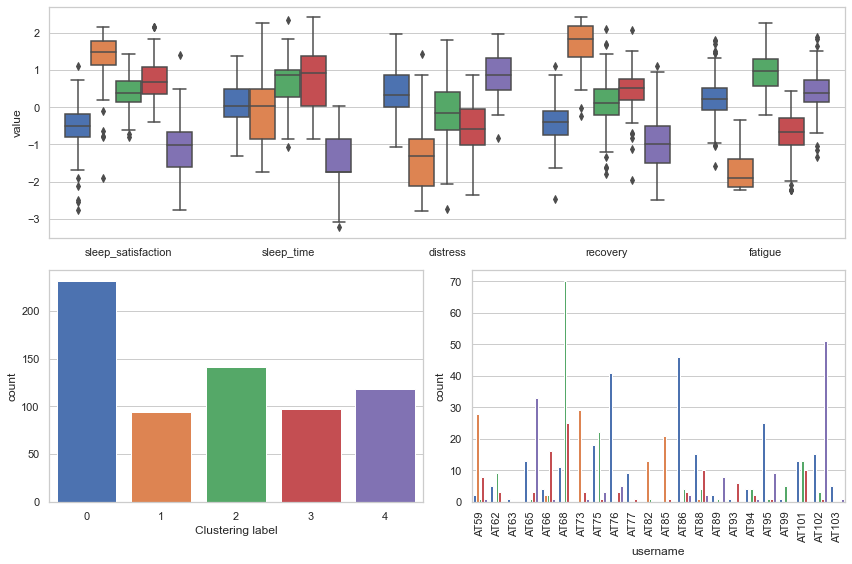

In [104]:
import matplotlib.gridspec as gridspec

## Filter data
df = daily_records.loc[condition, columns]

# Standardization (zero mean and unit variance)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df.drop('username', axis=1).values)
df_standardized = scaler.transform(df.drop('username', axis=1).values)

df_standardized = pd.DataFrame(df_standardized, columns=df.columns.values[1:])
df_standardized['username'] = df['username'].values
df_plot = df_standardized.copy()

df_silhouette = pd.DataFrame()

## K-means
from sklearn.cluster import KMeans

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))

    # Assign new label to dataset
    df_plot['label'] = kmeans.labels_

    if n_clusters == 4:
        labels_hrv_all = kmeans.labels_

    # Create 2x2 sub plots
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(12,8)) #gridspec_kw={'width_ratios': [6, 4]})
    ax1 = fig.add_subplot(gs[0, :]) # row 0, col 0
    ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
    ax3 = fig.add_subplot(gs[1, 1]) # row 1, span all columns
    

    # Main plot
    id_vars = ['label', 'username']
    variables = columns_questions
    df_cluster = df_plot.melt(id_vars=id_vars, value_vars=variables).dropna()

    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax1, saturation=1)
    ax1.get_legend().remove()
    ax1.set_xlabel('')

    # Label count plot
    df_cluster = df_plot
    sns.countplot(x='label', data=df_cluster,
                  saturation=1, ax=ax2)
    ax2.set_xlabel('Clustering label')

    # Label count by patient plot
    sns.countplot(x='username', hue='label', data=df_cluster,
                  saturation=1, ax=ax3)
    ax3.tick_params('x', rotation=90)
    ax3.get_legend().remove()

    fig.tight_layout()
    fig.savefig('viz/clustering-l02a-'+str(n_clusters)+'.pdf', bbox_inches='tight')

    ## Model Performance
    from sklearn.metrics import silhouette_score
    silh = silhouette_score(df_standardized.drop('username', axis=1), kmeans.labels_, metric='euclidean')
    df_silhouette.loc[n_clusters, 'silhouette'] = silh

df_silhouette.index.name='n_clusters'
df_silhouette = df_silhouette.reset_index()
df_silhouette.to_latex('tab/silhouette-l02a.tex', index=False)
df_silhouette

###### Feature Importance Random Forests

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Random forests models
clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                            max_depth=5, min_samples_leaf=5, 
                            min_samples_split=10, max_features='auto',
                            bootstrap=True,oob_score=True,
                            random_state=42,
                            class_weight='balanced'
                            )

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.8988266429163762


In [106]:
# Feature importance

fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = e.feature_importances_
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-l02a-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                                   
                                      CV1    CV2    CV3    CV4    CV5   Mean
sleep_satisfaction                  24.79  18.78  25.13  26.60  22.23  23.51
sleep_time                          20.17  23.69  21.38  17.78  18.52  20.31
distress                             8.00   8.01   7.06   7.29   9.54   7.98
recovery                            19.74  19.90  17.97  19.36  21.65  19.72
fatigue                             27.30  29.62  28.46  28.98  28.06  28.48

###### Feature Importance SVM

In [107]:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Random forests models
clf = svm.SVC(random_state=42, class_weight='balanced', kernel = 'linear')

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.9679949282151572


In [108]:
# Feature importance

fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fi_cv = pd.DataFrame(abs(e.coef_), columns=x.columns).apply(lambda srs: srs/srs.sum(), axis=1).mean()
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = fi_cv
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-svm-l02a-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                                   
                                      CV1    CV2    CV3    CV4    CV5   Mean
sleep_satisfaction                  23.95  21.58  23.55  25.11  23.44  23.53
sleep_time                          17.22  16.20  16.63  16.32  17.35  16.74
distress                            15.21  16.31  17.14  14.93  16.72  16.06
recovery                            23.39  25.04  24.03  23.96  24.69  24.23
fatigue                             20.23  20.87  18.64  19.68  17.80  19.44

In [109]:
# Value ranges
df_description = df.reset_index(drop=True).copy()
df_description['label'] = df_plot['label']

# Transform variables
columns_to_transform = ['distress']
df_description[columns_to_transform] = df_description[columns_to_transform].apply(np.exp)

#  Describe the clusters by variable
if 'level_0' in df_description.columns:
    df_description = df_description.drop(['level_0'], axis=1)
if 'index' in df_description.columns:
    df_description = df_description.drop(['index'], axis=1)

df_description = df_description.groupby('label').describe().round(2).T
df_description.to_latex('tab/cd-l02a-'+str(n_clusters)+'.tex') # cluster description
df_description

label                          0       1       2
sleep_satisfaction count  212.00  136.00  333.00
                   mean     4.37    8.36    6.31
                   std      1.24    1.19    1.04
                   min      1.11    2.66    3.67
                   25%      3.75    7.73    5.56
                   50%      4.53    8.50    6.39
                   75%      5.14    9.23    7.06
                   max      8.65   10.00    8.69
sleep_time         count  212.00  136.00  333.00
                   mean     5.93    7.17    7.53
                   std      0.91    1.10    0.74
                   min      3.33    5.00    5.75
                   25%      5.00    6.29    7.00
                   50%      6.00    7.00    7.50
                   75%      6.58    8.00    8.00
                   max      8.50    9.67    9.58
distress           count  212.00  136.00  333.00
                   mean     4.02    1.07    2.43
                   std      1.80    0.85    1.51
                   min      1.10    0.24    0.26
                   25%      2.63    0.50    1.38
                   50%      3.75    0.82    2.09
                   75%      5.08    1.35    2.85
                   max      9.13    6.10    8.18
recovery           count  212.00  136.00  333.00
                   mean     4.53    8.17    5.83
                   std      1.07    1.21    1.01
                   min      1.75    4.70    2.64
                   25%      3.97    7.24    5.26
                   50%      4.61    8.20    5.83
                   75%      5.21    9.24    6.53
                   max      7.73    9.90    9.38
fatigue            count  212.00  136.00  333.00
                   mean     4.93    1.33    5.05
                   std      1.11    1.10    1.32
                   min      1.26    0.00    1.46
                   25%      4.43    0.31    4.13
                   50%      4.96    1.31    4.99
                   75%      5.54    2.17    6.04
                   max      7.88    3.74    8.56

##### Remove sleep time (L02B)

In [110]:
columns_basic = ['username']

columns_training = ['session_number', 'recommendation_level', 'training_borg']

columns_hrv_categorical = ['swc_lnrmssd_ok', 'cv_lnrmssd_ok',]
columns_hrv_continuous = ['cv_lnrmssd',  'swc_lnrmssd', 'lnrmssd', 'cvnni', 
       'lf_hf_ratio', 'max_hr', 'mean_hr']

columns_questions = ['sleep_satisfaction', 'distress', 'recovery',
       'fatigue'] # sleep_time

columns_fitbit_steps = ['steps_total_yesterday', 'steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_sleep = ['sleep_total', 'sleep_deep', 'sleep_light', 'sleep_rem',
       'sleep_wake']

In [111]:
# Prepare filters
condition_hrv = daily_records['cv_lnrmssd'].notna()
# condition_fitbit_steps = daily_records['steps_total_yesterday'].notna()
# condition_fitbit_sleep = daily_records['sleep_total'].notna()

condition = condition_hrv # & condition_fitbit_sleep & condition_fitbit_steps

print('Total sample:')
n_samples = sum(condition)
print(n_samples)

# Select columns
columns = columns_basic + columns_questions

Total sample:
681


n_clusters  silhouette
0           2    0.442257
1           3    0.279222
2           4    0.248510
3           5    0.248656

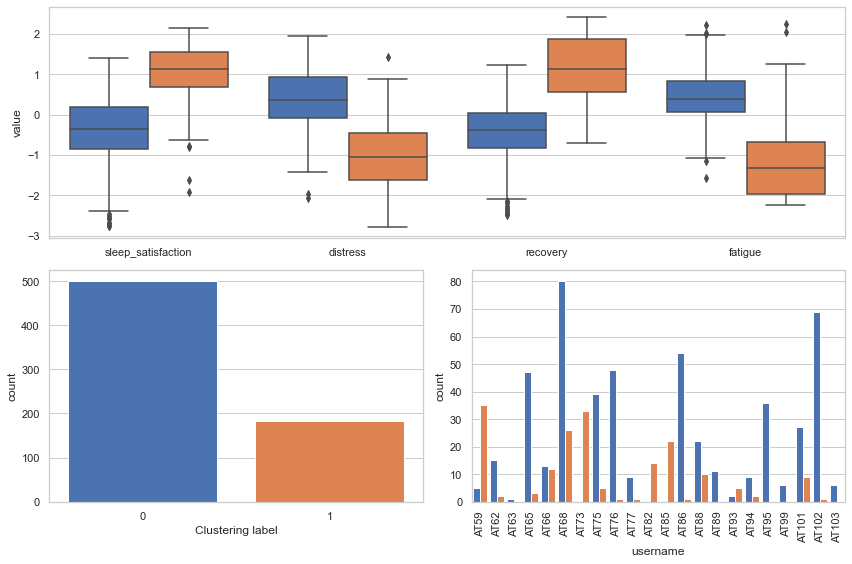

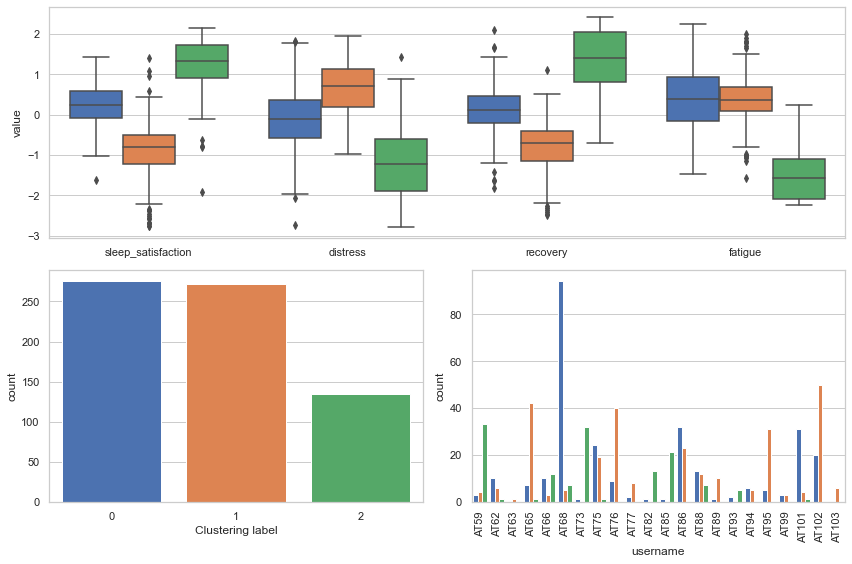

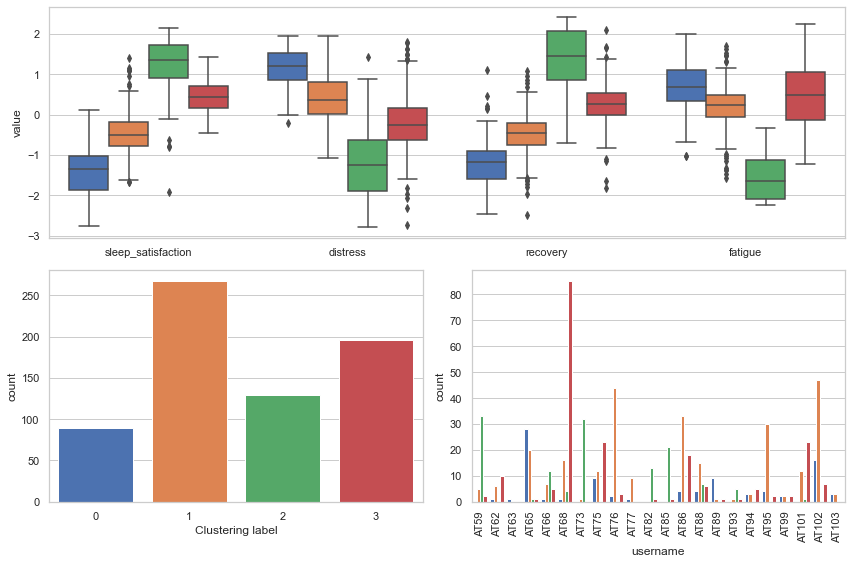

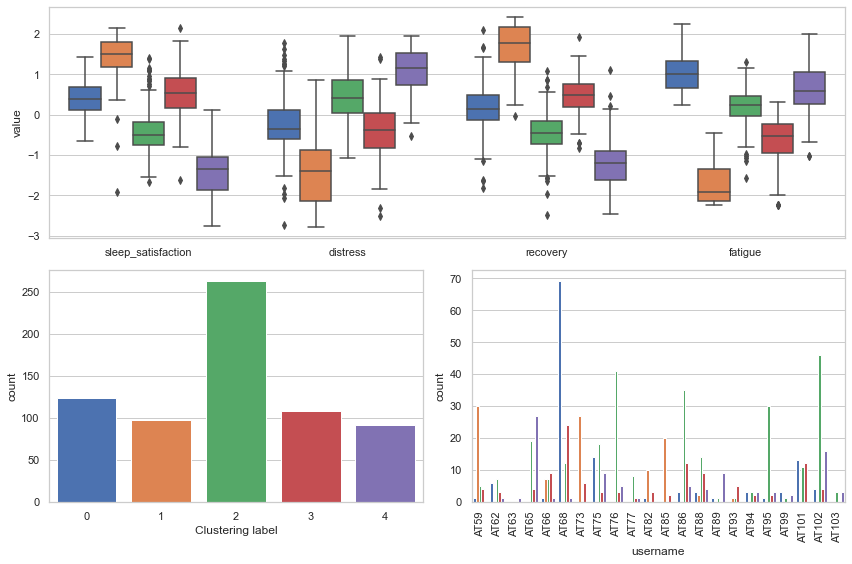

In [112]:
import matplotlib.gridspec as gridspec

## Filter data
df = daily_records.loc[condition, columns]

# Standardization (zero mean and unit variance)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df.drop('username', axis=1).values)
df_standardized = scaler.transform(df.drop('username', axis=1).values)

df_standardized = pd.DataFrame(df_standardized, columns=df.columns.values[1:])
df_standardized['username'] = df['username'].values
df_plot = df_standardized.copy()

df_silhouette = pd.DataFrame()

## K-means
from sklearn.cluster import KMeans

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))

    # Assign new label to dataset
    df_plot['label'] = kmeans.labels_

    if n_clusters == 4:
        labels_hrv_all = kmeans.labels_

    # Create 2x2 sub plots
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(12,8)) #gridspec_kw={'width_ratios': [6, 4]})
    ax1 = fig.add_subplot(gs[0, :]) # row 0, col 0
    ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
    ax3 = fig.add_subplot(gs[1, 1]) # row 1, span all columns
    

    # Main plot
    id_vars = ['label', 'username']
    variables = columns_questions
    df_cluster = df_plot.melt(id_vars=id_vars, value_vars=variables).dropna()

    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax1, saturation=1)
    ax1.get_legend().remove()
    ax1.set_xlabel('')

    # Label count plot
    df_cluster = df_plot
    sns.countplot(x='label', data=df_cluster,
                  saturation=1, ax=ax2)
    ax2.set_xlabel('Clustering label')

    # Label count by patient plot
    sns.countplot(x='username', hue='label', data=df_cluster,
                  saturation=1, ax=ax3)
    ax3.tick_params('x', rotation=90)
    ax3.get_legend().remove()

    fig.tight_layout()
    fig.savefig('viz/clustering-l02b-'+str(n_clusters)+'.pdf', bbox_inches='tight')

    ## Model Performance
    from sklearn.metrics import silhouette_score
    silh = silhouette_score(df_standardized.drop('username', axis=1), kmeans.labels_, metric='euclidean')
    df_silhouette.loc[n_clusters, 'silhouette'] = silh

df_silhouette.index.name='n_clusters'
df_silhouette = df_silhouette.reset_index()
df_silhouette.to_latex('tab/silhouette-l02b.tex', index=False)
df_silhouette

###### Feature Importance Random Forests

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Save for later comparison
daily_records.loc[condition, 'label_baseline_wellness'] = kmeans.labels_


# Random forests models
clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                            max_depth=5, min_samples_leaf=5, 
                            min_samples_split=10, max_features='auto',
                            bootstrap=True,oob_score=True,
                            random_state=42,
                            class_weight='balanced'
                            )

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.920343380030425


In [114]:
# Feature importance

fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = e.feature_importances_
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-l02b-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                                   
                                      CV1    CV2    CV3    CV4    CV5   Mean
sleep_satisfaction                  34.78  29.38  34.79  38.09  29.34  33.28
distress                            10.11  11.52  15.35   9.23  11.59  11.56
recovery                            24.86  28.77  20.09  19.68  26.72  24.02
fatigue                             30.25  30.34  29.77  33.00  32.35  31.14

###### Feature Importance SVM

In [115]:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Random forests models
clf = svm.SVC(random_state=42, class_weight='balanced', kernel = 'linear')

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.9648133612772376


In [116]:
# Feature importance

fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fi_cv = pd.DataFrame(abs(e.coef_), columns=x.columns).apply(lambda srs: srs/srs.sum(), axis=1).mean()
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = fi_cv
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-svm-l02b-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                                   
                                      CV1    CV2    CV3    CV4    CV5   Mean
sleep_satisfaction                  32.52  28.31  29.89  29.17  29.80  29.94
distress                            21.79  20.22  24.93  22.73  21.88  22.31
recovery                            24.82  29.34  25.04  25.25  27.44  26.38
fatigue                             20.88  22.13  20.14  22.85  20.88  21.37

In [117]:
# Value ranges
df_description = df.reset_index(drop=True).copy()
df_description['label'] = df_plot['label']

# Transform variables
columns_to_transform = ['distress']
df_description[columns_to_transform] = df_description[columns_to_transform].apply(np.exp)

#  Describe the clusters by variable
if 'level_0' in df_description.columns:
    df_description = df_description.drop(['level_0'], axis=1)
if 'index' in df_description.columns:
    df_description = df_description.drop(['index'], axis=1)

df_description = df_description.groupby('label').describe().round(2).T
df_description.to_latex('tab/cd-l02b-'+str(n_clusters)+'.tex') # cluster description
df_description

label                          0       1       2
sleep_satisfaction count  275.00  272.00  134.00
                   mean     6.57    4.54    8.39
                   std      0.91    1.20    1.18
                   min      3.19    1.11    2.66
                   25%      5.96    3.92    7.76
                   50%      6.54    4.68    8.53
                   75%      7.18    5.20    9.24
                   max      8.69    8.65   10.00
distress           count  275.00  272.00  134.00
                   mean     2.25    3.86    1.04
                   std      1.40    1.78    0.84
                   min      0.26    0.98    0.24
                   25%      1.32    2.35    0.49
                   50%      1.91    3.55    0.80
                   75%      2.72    4.84    1.29
                   max      8.18    9.13    6.10
recovery           count  275.00  272.00  134.00
                   mean     6.08    4.58    8.17
                   std      0.93    0.98    1.22
                   min      2.89    1.75    4.70
                   25%      5.54    3.99    7.23
                   50%      6.07    4.72    8.22
                   75%      6.67    5.20    9.29
                   max      9.38    7.73    9.90
fatigue            count  275.00  272.00  134.00
                   mean     5.00    4.98    1.32
                   std      1.39    1.09    1.12
                   min      1.46    1.26    0.00
                   25%      3.96    4.43    0.30
                   50%      5.03    4.95    1.28
                   75%      6.04    5.59    2.15
                   max      8.56    8.07    4.74

#### Wellness Z-scored by user (L03)

In [118]:
columns_basic = ['username']

columns_training = ['session_number', 'recommendation_level', 'training_borg']

columns_hrv_categorical = ['swc_lnrmssd_ok', 'cv_lnrmssd_ok',]
columns_hrv_continuous = ['cv_lnrmssd',  'swc_lnrmssd', 'lnrmssd', 'cvnni', 
       'lf_hf_ratio', 'max_hr', 'mean_hr']

columns_questions = ['sleep_satisfaction', 'distress', 'recovery', # 'sleep_time',
       'fatigue']
columns_questions_zscored = [name + '_zscored' for name in columns_questions]

columns_fitbit_steps = ['steps_total_yesterday', 'steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_sleep = ['sleep_total', 'sleep_deep', 'sleep_light', 'sleep_rem',
       'sleep_wake']

columns_hrv_continuous.remove('max_hr')
columns_hrv_continuous.remove('mean_hr')
columns_hrv_continuous.remove('cvnni')

# Remove sleep time
# columns_questions.remove('sleep_time')

In [119]:
# Prepare filters
condition_hrv = daily_records['cv_lnrmssd'].notna()
# condition_fitbit_steps = daily_records['steps_total_yesterday'].notna()
# condition_fitbit_sleep = daily_records['sleep_total'].notna()

condition = condition_hrv # & condition_fitbit_sleep & condition_fitbit_steps

print('Total sample:')
n_samples = sum(condition)
print(n_samples)

# Select columns
columns = columns_basic + columns_questions_zscored

Total sample:
681


n_clusters  silhouette
0           2    0.266132
1           3    0.210561
2           4    0.196307
3           5    0.201947

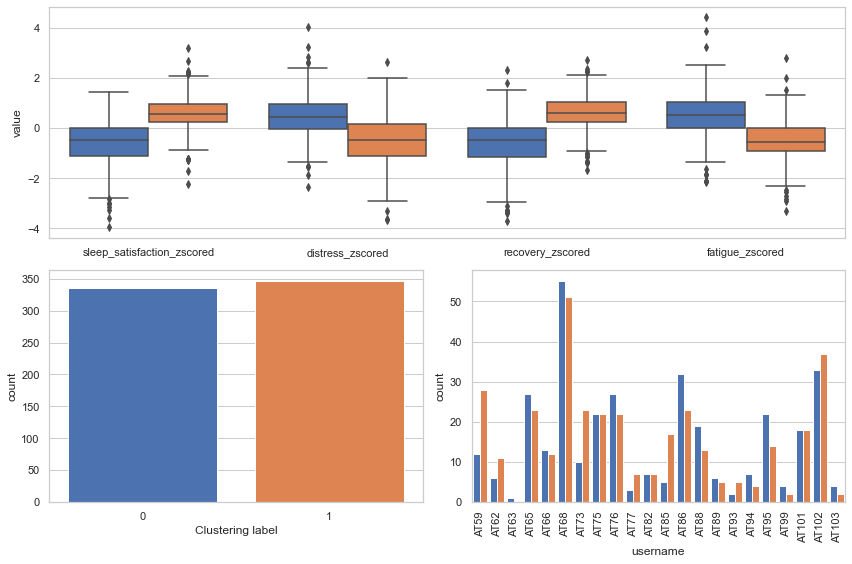

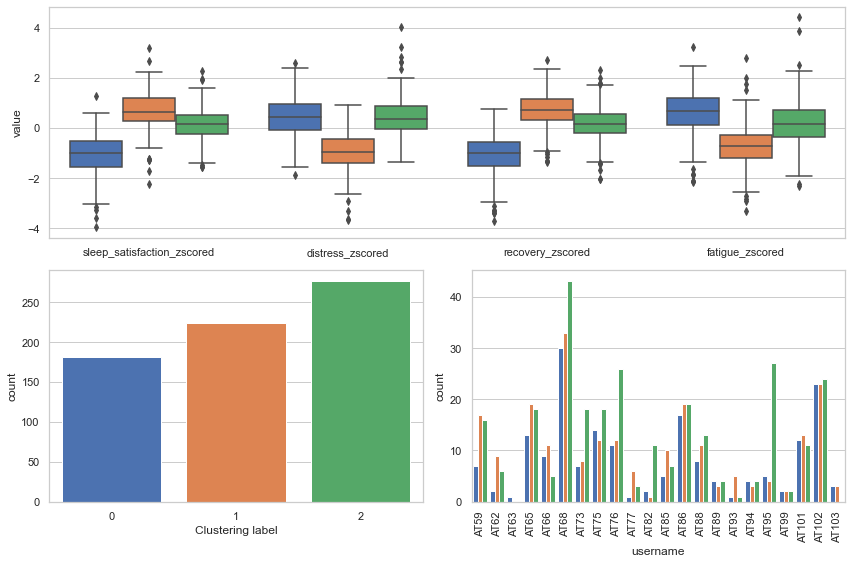

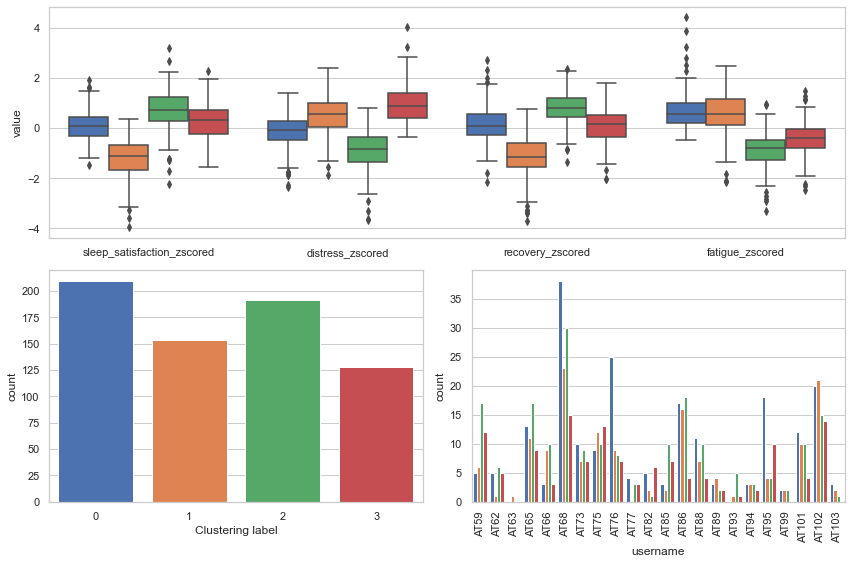

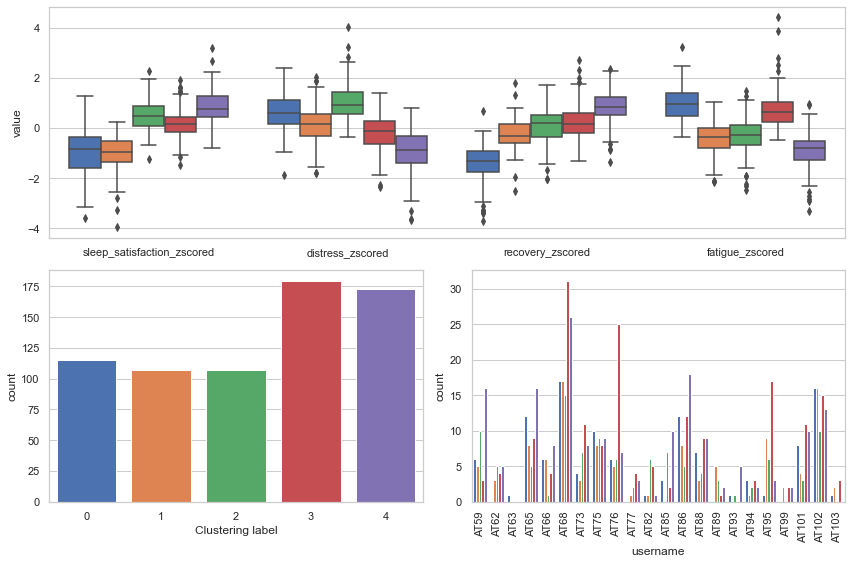

In [120]:
import matplotlib.gridspec as gridspec

## Filter data
df = daily_records.loc[condition, columns]

# Standardization (zero mean and unit variance)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df.drop('username', axis=1).values)
df_standardized = scaler.transform(df.drop('username', axis=1).values)

df_standardized = pd.DataFrame(df_standardized, columns=df.columns.values[1:])
df_standardized['username'] = df['username'].values
df_plot = df_standardized.copy()

df_silhouette = pd.DataFrame()

## K-means
from sklearn.cluster import KMeans

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))

    # Assign new label to dataset
    df_plot['label'] = kmeans.labels_

      
    # Create 2x2 sub plots
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(12,8)) #gridspec_kw={'width_ratios': [6, 4]})
    ax1 = fig.add_subplot(gs[0, :]) # row 0, col 0
    ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
    ax3 = fig.add_subplot(gs[1, 1]) # row 1, span all columns
    

    # Main plot
    id_vars = ['label', 'username']
    variables = columns_questions_zscored
    df_cluster = df_plot.melt(id_vars=id_vars, value_vars=variables).dropna()

    sns.boxplot(data=df_cluster, x='variable', y='value', hue=id_vars[0],
                #showmeans=True, 
                ax=ax1, saturation=1)
    ax1.get_legend().remove()
    ax1.set_xlabel('')

    # Label count plot
    df_cluster = df_plot
    sns.countplot(x='label', data=df_cluster,
                  saturation=1, ax=ax2)
    ax2.set_xlabel('Clustering label')

    # Label count by patient plot
    sns.countplot(x='username', hue='label', data=df_cluster,
                  saturation=1, ax=ax3)
    ax3.tick_params('x', rotation=90)
    ax3.get_legend().remove()

    fig.tight_layout()
    fig.savefig('viz/clustering-l03a-'+str(n_clusters)+'.pdf', bbox_inches='tight')

    ## Model Performance
    from sklearn.metrics import silhouette_score
    silh = silhouette_score(df_standardized.drop('username', axis=1), kmeans.labels_, metric='euclidean')
    df_silhouette.loc[n_clusters, 'silhouette'] = silh

df_silhouette.index.name='n_clusters'
df_silhouette = df_silhouette.reset_index()
df_silhouette.to_latex('tab/silhouette-l03a.tex', index=False)
df_silhouette

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

# Clustering model to analyze
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(df_standardized.drop('username', axis=1))
df_plot['label'] = kmeans.labels_

# Save for later comparison
daily_records.loc[condition, 'label_normalized_wellness'] = kmeans.labels_

# Random forests models
clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                            max_depth=5, min_samples_leaf=5, 
                            min_samples_split=10, max_features='auto',
                            bootstrap=True,oob_score=True,
                            random_state=42,
                            class_weight='balanced'
                            )

x = df_plot.drop(['username', 'label'], axis=1)
y = df_plot[['label']]

# Cross validation
cv_results = cross_validate(clf, x, y['label'], cv=5,
                            scoring='f1_weighted', return_estimator=True)
print('Mean F1 score:')
print(cv_results['test_score'].mean())

Mean F1 score:
0.8998303360566501


In [122]:
# Feature importance

fe = pd.DataFrame(index=x.columns.values.tolist())
for i, e in enumerate(cv_results['estimator']):
    fe.loc[x.columns.values.tolist(), 'CV'+str(i+1)] = e.feature_importances_
    # pd.DataFrame(, index=x.columns))
fe['Mean'] = fe.apply(np.mean, axis=1)

# Adapt to latex
columns_fe = fe.columns.to_list()
new_level = ['Feature importance (%)' for i in range(len(columns_fe))]
arrays = [new_level, columns_fe]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
fe.columns = mi
fe = fe.apply(lambda srs: srs*100).round(2)
fe.to_latex('tab/fi-l03a-'+str(n_clusters)+'.tex')
fe

Feature importance (%)                              \
                                              CV1    CV2    CV3    CV4    CV5   
sleep_satisfaction_zscored                  29.30  30.57  28.82  26.00  27.50   
distress_zscored                            27.13  31.61  27.67  29.85  31.69   
recovery_zscored                            26.90  26.10  27.38  29.92  27.26   
fatigue_zscored                             16.68  11.71  16.13  14.22  13.55   

                                   
                             Mean  
sleep_satisfaction_zscored  28.44  
distress_zscored            29.59  
recovery_zscored            27.51  
fatigue_zscored             14.46

In [123]:
# Value ranges
df_description = df.reset_index(drop=True).copy()
df_description['label'] = df_plot['label']

# Transform variables
# columns_to_transform = ['distress_zscored']
# df_description[columns_to_transform] = df_description[columns_to_transform].apply(np.exp)

#  Describe the clusters by variable
if 'level_0' in df_description.columns:
    df_description = df_description.drop(['level_0'], axis=1)
if 'index' in df_description.columns:
    df_description = df_description.drop(['index'], axis=1)

df_description = df_description.groupby('label').describe().round(2).T
df_description.to_latex('tab/cd-l03a-'+str(n_clusters)+'.tex') # cluster description
df_description

label                                  0       1       2
sleep_satisfaction_zscored count  181.00  224.00  276.00
                           mean    -1.03    0.68    0.17
                           std      0.80    0.74    0.59
                           min     -3.80   -2.14   -1.49
                           25%     -1.47    0.27   -0.22
                           50%     -0.96    0.65    0.18
                           75%     -0.50    1.17    0.52
                           max      1.25    3.10    2.22
distress_zscored           count  181.00  224.00  276.00
                           mean     0.43   -0.84    0.42
                           std      0.69    0.70    0.69
                           min     -1.70   -3.35   -1.24
                           25%     -0.07   -1.28   -0.04
                           50%      0.41   -0.87    0.32
                           75%      0.87   -0.41    0.80
                           max      2.38    0.86    3.69
recovery_zscored           count  181.00  224.00  276.00
                           mean    -1.00    0.63    0.16
                           std      0.76    0.66    0.60
                           min     -3.39   -1.25   -1.86
                           25%     -1.39    0.30   -0.19
                           50%     -0.90    0.68    0.16
                           75%     -0.50    1.06    0.52
                           max      0.72    2.50    2.13
fatigue_zscored            count  181.00  224.00  276.00
                           mean     0.58   -0.62    0.19
                           std      0.79    0.80    0.73
                           min     -1.93   -2.98   -2.07
                           25%      0.14   -1.07   -0.29
                           50%      0.62   -0.62    0.16
                           75%      1.11   -0.23    0.66
                           max      2.96    2.57    4.02

#### Internal validation and Confusion matrix exploration
This section explores how much correspondence there is between HRV and wellness labels. More precisely, we want to ses if "good" hrv labels match "good" wellness labels (which we end up seeing  it does not happen).

##### Confusion matrix of wellness with absolute number of incidences

In [124]:
from sklearn.metrics import confusion_matrix
# daily_records[['label_questions_raw', 'label_hrv']].value_counts()
# cm = confusion_matrix(daily_records[['label_hrv']].dropna(), daily_records[['label_baseline_wellness']].dropna())
# cm
pd.crosstab(daily_records['label_hrv'], daily_records['label_baseline_wellness'])

label_baseline_wellness  0.0  1.0  2.0
label_hrv                             
0.0                       51   51   44
1.0                       75   47   56
2.0                       72   82    7
3.0                       77   92   27

##### Confusion matrix of wellness with percentage of number by incidence
Numbers in a row must sum 100%, that is, we are measuring how wellness labels are distributed across HRV labels

In [127]:
vcount_questions = daily_records['label_baseline_wellness'].value_counts()
vcount_questions

0.0    275
1.0    272
2.0    134
Name: label_baseline_wellness, dtype: int64

In [128]:
# Normalize confusion matrix by questions class incidence
ct = pd.crosstab(daily_records['label_hrv'], daily_records['label_baseline_wellness'])
f0 = 1
f1 = vcount_questions[0]/vcount_questions[1]
f2 = vcount_questions[0]/vcount_questions[2]
ct.loc[:,1] = ct.loc[:,1]*f1
ct.loc[:,2] = ct.loc[:,2]*f2

# Adjust to percentage
cm = ct.apply(lambda srs: 100*srs/srs.sum(), axis=1).round(2)

# Labels
cm.columns = cm.columns.set_names('')
cm.index = cm.index.set_names('Label HRV')

# Adapt to latex
columns_cm = cm.columns.to_list()
new_level = ['Label baseline wellness' for i in range(len(columns_cm))]
arrays = [new_level, columns_cm]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
cm.columns = mi
#cm = cm.apply(lambda srs: srs*100).round(2)
cm.to_latex('tab/cm-hrv+baseline.tex')
cm

Label baseline wellness              
                              0.0    1.0    2.0
Label HRV                                      
0.0                         26.44  26.74  46.82
1.0                         31.59  20.01  48.40
2.0                         42.54  48.98   8.49
3.0                         34.16  41.26  24.58

##### Confusion matrix of normalized wellness with absolute number of incidences

In [ ]:
from sklearn.metrics import confusion_matrix
# daily_records[['label_questions_raw', 'label_hrv']].value_counts()
# cm = confusion_matrix(daily_records[['label_hrv']].dropna(), daily_records[['label_baseline_wellness']].dropna())
# cm
pd.crosstab(daily_records['label_hrv'], daily_records['label_normalized_wellness'])

label_normalized_wellness  0.0  1.0  2.0
label_hrv                               
0.0                         37   48   61
1.0                         46   62   70
2.0                         49   57   55
3.0                         49   57   90

##### Confusion matrix of normalized wellness with percentage of incidences

In [ ]:
vcount_questions = daily_records['label_normalized_wellness'].value_counts()
vcount_questions

2.0    276
1.0    224
0.0    181
Name: label_normalized_wellness, dtype: int64

In [ ]:
# Normalize confusion matrix by questions class incidence
ct = pd.crosstab(daily_records['label_hrv'], daily_records['label_normalized_wellness'])
f0 = 1
f1 = vcount_questions[0]/vcount_questions[1]
f2 = vcount_questions[0]/vcount_questions[2]
ct.loc[:,1] = ct.loc[:,1]*f1
ct.loc[:,2] = ct.loc[:,2]*f2

# Adjust to percentage
cm = ct.apply(lambda srs: 100*srs/srs.sum(), axis=1).round(2)

# Labels
cm.columns = cm.columns.set_names('')
cm.index = cm.index.set_names('Label HRV')

# Adapt to latex
columns_cm = cm.columns.to_list()
new_level = ['Label normalized wellness' for i in range(len(columns_cm))]
arrays = [new_level, columns_cm]
mi = pd.MultiIndex.from_arrays(arrays, names=('', ''))
cm.columns = mi
#cm = cm.apply(lambda srs: srs*100).round(2)
cm.to_latex('tab/cm-hrv+normalized.tex')
cm

Label normalized wellness              
                                0.0    1.0    2.0
Label HRV                                        
0.0                           31.95  33.50  34.55
1.0                           32.39  35.28  32.33
2.0                           37.37  35.12  27.51
3.0                           31.80  29.89  38.31

##### Longitudinal analysis for HRV
We use AT65, AT86, and AT102 as an example of how patients do not match the HRV and the self-reports.

In [144]:
df = daily_records[['username', 'study_day', 'label_hrv']].dropna().sort_values(['username', 'study_day'])
df = df.pivot_table(index='username', columns='study_day', values='label_hrv')
df = df.loc[['AT65', 'AT86', 'AT102'], 0:92]

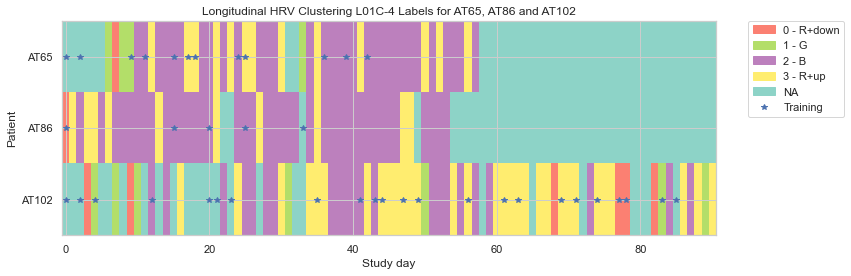

In [145]:
import matplotlib.patches as mpatches

# Prepare nv_days_bool for plotting
df.fillna(-1, inplace=True)  # Codes non available day as -1

# Plot matrix as an image
fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(df, cmap='Set3', interpolation='nearest', aspect='auto')
plt.yticks(range(df.shape[0]), df.index.values)
# plt.xticks(range(df.shape[1]), df.columns.values)
plt.ylabel('Patient')
plt.xlabel('Study day')
plt.title('Longitudinal HRV Clustering L01C-4 Labels for AT65, AT86 and AT102')

# get the colors of the values, according to the 
# colormap used by imshow
values = [0,1,2,3,-1]
colors = [im.cmap(im.norm(value)) for value in values]
labels = ['0 - R+down', '1 - G', '2 - B', '3 - R+up', 'NA']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(colors)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

patients = ['AT65', 'AT86', 'AT102']

dd = pd.DataFrame()
# Print training
for i, patient in enumerate(patients):
    # print(str(i) + ' - ' + patient)
    c = daily_records['username']==patient
    d = daily_records.loc[c, ['study_day', 'training_borg']].dropna()
    d['training_borg'] = d['training_borg'] > 0
    d = d[d['training_borg']>0]
    d['training_borg'] = d['training_borg'].replace(True, i)
    dd = pd.concat([dd, d])
dd

ax.plot(dd['study_day'], dd['training_borg'], linestyle='', marker='*', label='Training')
handles, labels = ax.get_legend_handles_labels()

# Complete legend
patches.append(handles[0])
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
fig.tight_layout()
fig.savefig('viz/hrv-labels-longitudinal-exploration.pdf')

In [ ]:
condition = daily_records['username'] == 'AT86'
condition = condition | (daily_records['username'] == 'AT65')
condition = condition | (daily_records['username'] == 'AT102')
daily_records.loc[condition, ['username', 'label_hrv']].groupby(['label_hrv']).count()

username
label_hrv          
0.0              13
1.0              11
2.0              95
3.0              56

##### Longitudinal analysis for Wellness

In [ ]:
df = daily_records[['username', 'study_day', 'label_baseline_wellness']].dropna().sort_values(['username', 'study_day'])
df = df.pivot_table(index='username', columns='study_day', values='label_baseline_wellness')

df = df.loc[['AT65', 'AT86', 'AT102'], 0:92]

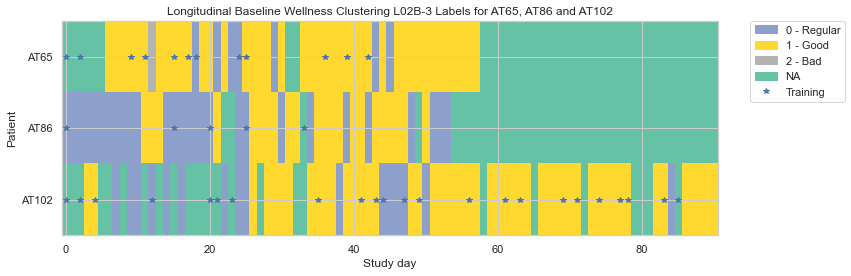

In [ ]:
import matplotlib.patches as mpatches

# Prepare nv_days_bool for plotting
df.fillna(-1, inplace=True)  # Codes non available day as -1

# Plot matrix as an image
fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(df, cmap='Set2', interpolation='nearest', aspect='auto')
plt.yticks(range(df.shape[0]), df.index.values)
# plt.xticks(range(df.shape[1]), df.columns.values)
plt.ylabel('Patient')
plt.xlabel('Study day')
plt.title('Longitudinal Baseline Wellness Clustering L02B-3 Labels for AT65, AT86 and AT102')

# get the colors of the values, according to the 
# colormap used by imshow
values = [0,1,2,-1]
colors = [im.cmap(im.norm(value)) for value in values]
labels = ['0 - Regular', '1 - Good', '2 - Bad', 'NA']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(colors)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

patients = ['AT65', 'AT86', 'AT102']

dd = pd.DataFrame()
# Print training
for i, patient in enumerate(patients):
    # print(str(i) + ' - ' + patient)
    c = daily_records['username']==patient
    d = daily_records.loc[c, ['study_day', 'training_borg']].dropna()
    d['training_borg'] = d['training_borg'] > 0
    d = d[d['training_borg']>0]
    d['training_borg'] = d['training_borg'].replace(True, i)
    dd = pd.concat([dd, d])
dd

ax.plot(dd['study_day'], dd['training_borg'], linestyle='', marker='*', label='Training')
handles, labels = ax.get_legend_handles_labels()

# Complete legend
patches.append(handles[0])
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
fig.tight_layout()
fig.savefig('viz/wellness-labels-longitudinal-exploration.pdf')

##### Longitudinal analysis for normalized Wellness

In [131]:
df = daily_records[['username', 'study_day', 'label_normalized_wellness']].dropna().sort_values(['username', 'study_day'])
df = df.pivot_table(index='username', columns='study_day', values='label_normalized_wellness')

df = df.loc[['AT65', 'AT86', 'AT102'], 0:92]

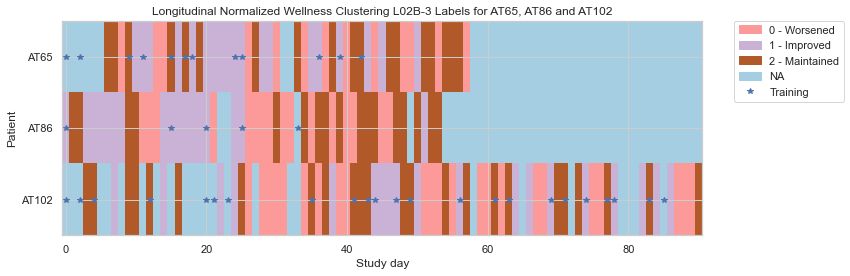

In [142]:
import matplotlib.patches as mpatches

# Prepare nv_days_bool for plotting
df.fillna(-1, inplace=True)  # Codes non available day as -1

# Plot matrix as an image
fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(df, cmap='Paired', interpolation='nearest', aspect='auto')
plt.yticks(range(df.shape[0]), df.index.values)
# plt.xticks(range(df.shape[1]), df.columns.values)
plt.ylabel('Patient')
plt.xlabel('Study day')
plt.title('Longitudinal Normalized Wellness Clustering L02B-3 Labels for AT65, AT86 and AT102')

# get the colors of the values, according to the 
# colormap used by imshow
values = [0,1,2,-1]
colors = [im.cmap(im.norm(value)) for value in values]
labels = ['0 - Worsened', '1 - Improved', '2 - Maintained', 'NA']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(colors)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

patients = ['AT65', 'AT86', 'AT102']

dd = pd.DataFrame()
# Print training
for i, patient in enumerate(patients):
    # print(str(i) + ' - ' + patient)
    c = daily_records['username']==patient
    d = daily_records.loc[c, ['study_day', 'training_borg']].dropna()
    d['training_borg'] = d['training_borg'] > 0
    d = d[d['training_borg']>0]
    d['training_borg'] = d['training_borg'].replace(True, i)
    dd = pd.concat([dd, d])
dd

ax.plot(dd['study_day'], dd['training_borg'], linestyle='', marker='*', label='Training')
handles, labels = ax.get_legend_handles_labels()

# Complete legend
patches.append(handles[0])
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
fig.tight_layout()
fig.savefig('viz/wellness-normalized-labels-longitudinal-exploration.pdf')

##### Longitudinal analysis combined

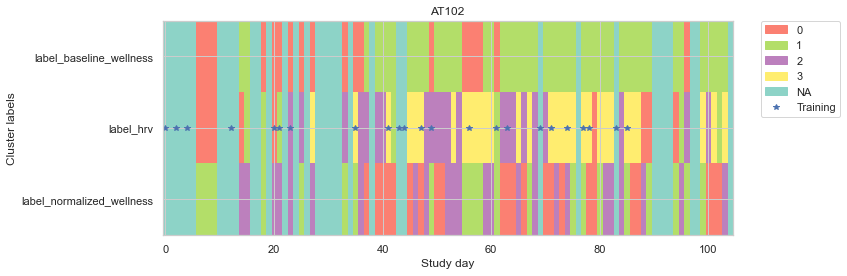

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Prepare data for patient
patient = 'AT102'
df = daily_records[['username', 'study_day', 'label_hrv', 'label_baseline_wellness', 'label_normalized_wellness']].sort_values(['username', 'study_day']).fillna(-1)
df = df[df['username']==patient]

df = df.melt(value_vars=['label_hrv', 'label_baseline_wellness', 'label_normalized_wellness'], id_vars='study_day')
df = df.pivot_table(index='variable', columns='study_day', values='value')
# df = df.loc[['AT65', 'AT86', 'AT102'], 0:92]

# Prepare nv_days_bool for plotting
# df.fillna(-1, inplace=True)  # Codes not label as -1

# Plot matrix as an image
fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(df, cmap='Set3', interpolation='nearest', aspect='auto')
plt.yticks(range(df.shape[0]), df.index.values)
# plt.xticks(range(df.shape[1]), df.columns.values)
plt.ylabel('Cluster labels')
plt.xlabel('Study day')
plt.title(patient)

# get the colors of the values, according to the 
# colormap used by imshow
values = [0,1,2,3, -1]
colors = [im.cmap(im.norm(value)) for value in values]
labels = ['0', '1', '2', '3', 'NA']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(colors)) ]
# patches.append('training')
# put those patched as legend-handles into the legend
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

# Print training
c = daily_records['username']==patient
d = daily_records.loc[c, ['study_day', 'training_borg']].dropna()
d['training_borg'] = d['training_borg'] > 0
d = d[d['training_borg']>0]
d['training_borg'] = d['training_borg'].replace(True, 1)
ax.plot(d['study_day'], d['training_borg'], linestyle='', marker='*', label='Training')
handles, labels = ax.get_legend_handles_labels()

# Complete legend
patches.append(handles[0])
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
fig.tight_layout()

In [ ]:
daily_records[(daily_records['username']=='AT65')].session_type.unique()

array([nan, 'preparatory_training', 'adjusted_training'], dtype=object)

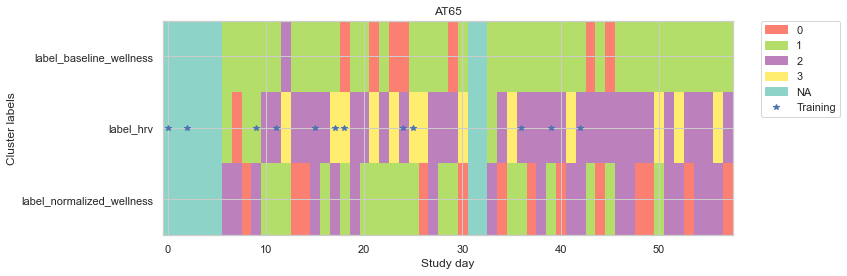

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Prepare data for patient
patient = 'AT65'
df = daily_records[['username', 'study_day', 'label_hrv', 'label_baseline_wellness', 'label_normalized_wellness']].sort_values(['username', 'study_day']).fillna(-1)
df = df[df['username']==patient]

df = df.melt(value_vars=['label_hrv', 'label_baseline_wellness', 'label_normalized_wellness'], id_vars='study_day')
df = df.pivot_table(index='variable', columns='study_day', values='value')
# df = df.loc[['AT65', 'AT86', 'AT102'], 0:92]

# Prepare nv_days_bool for plotting
# df.fillna(-1, inplace=True)  # Codes not label as -1

# Plot matrix as an image
fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(df, cmap='Set3', interpolation='nearest', aspect='auto')
plt.yticks(range(df.shape[0]), df.index.values)
# plt.xticks(range(df.shape[1]), df.columns.values)
plt.ylabel('Cluster labels')
plt.xlabel('Study day')
plt.title(patient)

# get the colors of the values, according to the 
# colormap used by imshow
values = [0,1,2,3, -1]
colors = [im.cmap(im.norm(value)) for value in values]
labels = ['0', '1', '2', '3', 'NA']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(colors)) ]
# patches.append('training')
# put those patched as legend-handles into the legend
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

# Print training
c = daily_records['username']==patient
d = daily_records.loc[c, ['study_day', 'training_borg']].dropna()
d['training_borg'] = d['training_borg'] > 0
d = d[d['training_borg']>0]
d['training_borg'] = d['training_borg'].replace(True, 1)
ax.plot(d['study_day'], d['training_borg'], linestyle='', marker='*', label='Training')
handles, labels = ax.get_legend_handles_labels()

# Complete legend
patches.append(handles[0])
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
fig.tight_layout()

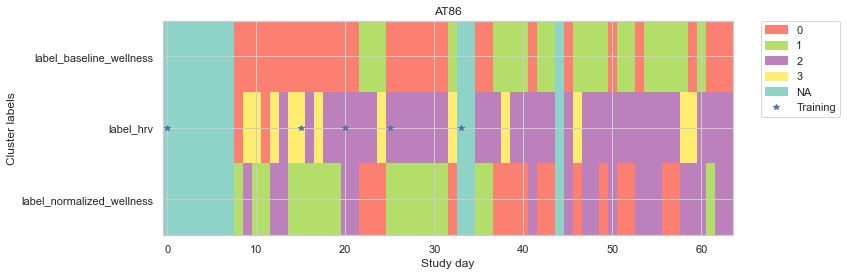

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Prepare data for patient
patient = 'AT86'
df = daily_records[['username', 'study_day', 'label_hrv', 'label_baseline_wellness', 'label_normalized_wellness']].sort_values(['username', 'study_day']).fillna(-1)
df = df[df['username']==patient]

df = df.melt(value_vars=['label_hrv', 'label_baseline_wellness', 'label_normalized_wellness'], id_vars='study_day')
df = df.pivot_table(index='variable', columns='study_day', values='value')
# df = df.loc[['AT65', 'AT86', 'AT102'], 0:92]

# Prepare nv_days_bool for plotting
# df.fillna(-1, inplace=True)  # Codes not label as -1

# Plot matrix as an image
fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(df, cmap='Set3', interpolation='nearest', aspect='auto')
plt.yticks(range(df.shape[0]), df.index.values)
# plt.xticks(range(df.shape[1]), df.columns.values)
plt.ylabel('Cluster labels')
plt.xlabel('Study day')
plt.title(patient)

# get the colors of the values, according to the 
# colormap used by imshow
values = [0,1,2,3, -1]
colors = [im.cmap(im.norm(value)) for value in values]
labels = ['0', '1', '2', '3', 'NA']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(colors)) ]
# patches.append('training')
# put those patched as legend-handles into the legend
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

# Print training
c = daily_records['username']==patient
d = daily_records.loc[c, ['study_day', 'training_borg']].dropna()
d['training_borg'] = d['training_borg'] > 0
d = d[d['training_borg']>0]
d['training_borg'] = d['training_borg'].replace(True, 1)
ax.plot(d['study_day'], d['training_borg'], linestyle='', marker='*', label='Training')
handles, labels = ax.get_legend_handles_labels()

# Complete legend
patches.append(handles[0])
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
fig.tight_layout()